# Итоговая работа по модулю 6 Ефимова Олега

<b> Оглавление </b>

[Импорт, настройки, функции](#settings)  
[Чтение данных и удаление ненужных признаков](#read_data)  
[Анализ и подготовка данных](#analysis)  
-    [price](#price), [model_name & model_info](#model), [bodyType](#bodyType), [brand](#brand), [color](#color),
[enginePower](#enginePower), [engineDisplacement](#engineDisplacement), [fuelType](#fuelType), [Привод](#Привод), 
[vehicleTransmission](#vehicleTransmission), [vehicleConfiguration](#vehicleConfiguration), [numberOfDoors](#numberOfDoors),
[mileage](#mileage), [modelDate](#modelDate), [productionDate](#productionDate), [Владельцы](#Владельцы), [ПТС](#ПТС), 
[Руль](#Руль), [Владение](#Владение), [description](#description), [complectation & equipment](#equip), 
[name](#name), [super_gen](#super_gen), [vendor](#vendor)   

[Анализ значимости и выбор признаков](#impotance)   
-    [Корреляция и значимость признаков в старых наборах](#imp_old)   
-    [Корреляция и значимость признаков в новых наборах](#imp_new)   
-    [Подготовка и разбиение данных для старого набора](#prep_old)   
-    [Подготовка и разбиение данных для нового набора](#prep_new)  

[Подбор моделей](#modeling)   
-    [Random Forest](#forest)   
-    [Cat Boosting](#cat)   
-    [Extra Trees](#extra)   
-    [Gradient Boosting](#gradient)  
-    [XGB](#xgb)   
-    [KNeihgbors](#kn)  

[Бэггинг](#bagging)   
-    [Бэггинг для Random Forest](#baggingRF)   
-    [Бэггинг для Cat Boosting](#baggingCB)   
-    [Бэггинг для XGB](#baggingXGB)  

[Стекинг](#stacking)   
[Улучшение метрики](#best)   
-    [Включение статистик](#stat)   
-    [Дублирование тренировочного набора](#dubl)  
-    [Анализ текста TF_IDF и снижение размерности](#tfidf)   
-    [Добавление средней цены по категориям в новом наборе](#stat_new)  
-    [Включение полиномиальных признаков](#poly)  

[Submission](#submit)   
[Резюме по проекту](#result) 

<a id='settings'></a>
# Импорт, настройки, функции

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from pandas import Series

from datetime import datetime, timedelta
import itertools
import ast
from itertools import combinations
from scipy.stats import ttest_ind, pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler

from wordcloud import WordCloud, STOPWORDS 
import string
import re
import nltk
from nltk.util import ngrams
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures

import json

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5


In [3]:
RANDOM_SEED = 42
VAL_SIZE   = 0.20   # 20%

In [4]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

In [5]:
# Функции

# Вычисление метрики
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


# Преобразование в None для строковых признаков
def set_None(value):
    if value is None:
        return value
    else:        
        str_value = str(value).strip()
        if str_value == '' or str_value.lower() == 'nan':
            return None
        else:
            return str_value


# перевод в нижний регистр
def set_lower(value):
    if value is None:
        return value
    else:
        return value.lower()
    
    
# Выделение вида кузова
def get_body(value):
    if value is None:
        return value
    else:
        main_value = str(value).strip().split()[0].split('-')[0]
        return main_value
    
# Выделение списка оборудования
def get_complect(value):
    astr = value.replace(' ','')
    b1 = astr.find("'available_options':") 
    e1 = astr.find(",'vendor_colors'")
    
    b2 = astr.find('"available_options":') 
    e2 = astr.find(',"vendor_colors"')
    
    if b1>=0 and e1>=0:
        return astr[b1+21:e1-1].replace("'","").split(',')
    elif b2>=0 and e2>=0:
        return astr[b2+21:e2-1].replace('"','').split(',')
    else:
        return []
    

# Выделение признаков из списочных столбцов
# col - внешняя переменная, соответствует текущему столбцу для признака
def find_eq_test(row):
    find = 0 
    
    if not(row['equipment_dict'] is None):
        for eq in row['equipment_dict']:
            if re.search(col,eq):
                find = 1
                break
            
    if find == 0 and not(row['complectation_dict'] is None):
        for eq in row['complectation_dict']:
            if re.search(col,eq):
                find = 1
                break
                
    if find == 0 and not(row['equipment_dict_y'] is None):
        for eq in row['equipment_dict_y']:
            if re.search(col,eq):
                find = 1
                break
                
    if find == 0 and not(row['complectation_dict_y'] is None):
        for eq in row['complectation_dict_y']:
            if re.search(col,eq):
                find = 1
                break
                
    return find        

def find_eq_train(row):
    find = 0 
    
    if not(row['complectation_dict'] is None):
        for eq in row['complectation_dict']:
            if re.search(col,eq):
                find = 1
                break
                    
    return find        

def find_eq_train21(row):
    find = 0 
    
    if not(row['equipment_dict'] is None):
        for eq in row['equipment_dict']:
            if re.search(col,eq):
                find = 1
                break
            
    if find == 0 and not(row['complectation_dict'] is None):
        for eq in row['complectation_dict']:
            if re.search(col,eq):
                find = 1
                break
               
    return find        
    
# Определение выбросов
def get_outlier(df, col):
    Q3 = pd.DataFrame.quantile(df, q=0.75, axis=0, numeric_only=True, interpolation='midpoint')[col]
    Q1 = pd.DataFrame.quantile(df, q=0.25, axis=0, numeric_only=True, interpolation='midpoint')[col]
    IQR = round(Q3-Q1,1)
    return df[~df[col].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)][col], Q1 - 1.5*IQR, Q3 + 1.5*IQR


# Информация о выбросах с графиками
def show_info(df, col, show=True):
    # Выводим количество выбросов и их границы
    out, lim1, lim2 = get_outlier(df, col)
    minCol = df[col].min()
    maxCol = df[col].max()
    median = df[col].median()
    nulCol = sum(pd.isnull(df[col]))
    
    cnt = min(int(df[col].value_counts().count()),2000)
    
    if show:
        print('Не заполнено: ', nulCol)
        print('Минимум: ', minCol)
        print('Максимум: ', maxCol)
        print('Медиана: ', median)
        print('Количество выбросов: ', len(out))
        if len(out) > 0:
            print('Нижняя граница выбросов: ', lim1)
            print('Верхняя граница выбросов: ', lim2)

        # Выводим графики: гистограмму и боксплот
        fig, axes = plt.subplots(1,2,figsize=(12,4))
        axes[0].hist(df[col], bins=cnt)
        axes[1].boxplot(df[col])
    
    return {'med': median, 'lm1': lim1, 'lm2': lim2}


# График с боксплотами
def show_boxplot(df, x_col, y_col):
    plt.figure(figsize=(12, 8))
    g = sns.boxplot(y=y_col, x=x_col, data=df, color='yellow')
    g.set_title(y_col + ' of ' + x_col, fontsize=20)
    g.set_ylabel(y_col, fontsize=15)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    plt.show()
    
# Сравнение двух графиков 
def val_log_plot(df, col):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].hist(df[col], rwidth=0.9, alpha=0.7, bins=15)
    ax[0].set_title(col)

    ax[1].hist(np.log(df[col]+1), rwidth=0.9, alpha=0.7, bins=15)
    ax[1].set_title('log of '+col)

    plt.show()
    

# Сбор информации о всех данных
def describe_data(df):
    information = pd.DataFrame(columns=['name','type','count','isnull','unique',
                                    'min','max','mean','mode',
                                    '25','50','75', 'len_out', 'out_1','out_2'
                                       ])
    types = df.dtypes
    columns = df.columns
    for col in columns:
        mode = np.NaN
        try:  
            mode = df[col].mode()[0]
        except:  
            pass
        
    
        if str(df.dtypes[col]) == 'object' or str(df.dtypes[col]) == 'bool':
            information.loc[len(information)] = [col, 
                                         str(df.dtypes[col]), 
                                         len(df[~df[col].isnull()]), 
                                         len(df[df[col].isnull()]), 
                                         len(df[col].unique()), 
                                         np.NaN, 
                                         np.NaN, 
                                         np.NaN, 
                                         mode ,
                                         np.NaN, 
                                         np.NaN, 
                                         np.NaN,
                                         np.NaN,
                                         np.NaN,
                                         np.NaN
                                                ] 
        else:
            out, lim1, lim2 = get_outlier(df, col)
            if len(out) == 0:
                lim1 = np.NaN
                lim2 = np.NaN
    
            information.loc[len(information)] = [col, 
                                         str(df.dtypes[col]), 
                                         df.describe().loc['count',col], 
                                         len(df[df[col].isnull()]), 
                                         len(df[col].unique()), 
                                         df.describe().loc['min',col], 
                                         df.describe().loc['max',col], 
                                         df.describe().loc['mean',col], 
                                         mode,
                                         df.describe().loc['25%',col], 
                                         df.describe().loc['50%',col], 
                                         df.describe().loc['75%',col],
                                         len(out),
                                         lim1,
                                         lim2
                                                ] 
    return information 

            
# функция вычисления попарного p_value при множественном значении категориального столбца
def get_stat_dif(df, columns, col_target):
    
    p_list =[]
    res = '' 
    for col in columns:
        cols = df.loc[:, col].value_counts().index
        combinations_all = list(combinations(cols, 2))
        if len(combinations_all)==0:
            res = col + ': значимости нет'
            print(res)
            continue
        
        conv = 0.05 / len(combinations_all) # пороговый уровень значимости с поправкой Бонферрони
    
        for comb in combinations_all:
            p_value = ttest_ind(df.loc[df.loc[:, col] == comb[0], col_target], 
                     df.loc[df.loc[:, col] == comb[1], col_target]).pvalue
            p_list.append(p_value)
        
            if p_value < conv:
                res = ', значимость есть: для ' + str(comb) + ' p_value=' + str(p_value)
            else:
                res = ', значимости нет'
            break
            
        if res == '':
            res = ', значимости нет: min(p_value)=' + str(min(p_list))
    
        res = col + ': порог=' + str(round(conv,6)) + res
        print(res)
        

# функция выявления значимости числовых столбцов по корреляции по Пирсону
def get_stat_corr(df, columns, col_target):
    
    for col in columns:
        p_value = pearsonr(df[col], df[col_target])[1]
    
        if (p_value / len(columns)) < 0.05:
            print(col + ' для ' + col_target + ' - значимость есть')
        else:
            print(col + ' для ' + col_target + ' - значимости нет')
        

In [6]:
VERSION    = 16
DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/'
DIR_TRAIN_2021_02  = '../input/data25022021/'
#DIR_TRAIN_2021_02  = '../input/datamskspb-18-02-2021/'
#DIR_TRAIN  = '../input/moscow-auto-15-02-2021/'
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
DIR_EQ     = '../input/equipment/'
DIR_INFO   = '../input/infoauto/'

<a id='read_data'></a>
# Чтение данных и удаление ненужных признаков

Строить модель будем сразу на двух наборах - наборе по умолчанию и наборе, скачанном с Авто.ру в феврале. Набор по умолчанию имеет мало признаков, но зато в нем цены соответствуют ценам из валидационного набора при сабмите. Скачанный набор имеет полное соответствие валидационному по составу признаков, но цены в нем уже другие.

In [7]:
# Тренировочный набор по умолчанию
train = pd.read_csv(DIR_TRAIN + 'all_auto_ru_09_09_2020.csv') 

# Тренировочный набор, скачанный с Авто.ру 15-18 февраля 2021 г.
train21 = pd.read_csv(DIR_TRAIN_2021_02 + 'dataAll.csv') 

# Валидационный набор
test = pd.read_csv(DIR_TEST + 'test.csv') 

# Расширение валидационного набора, скачанное с Авто.ру по ссылкам из набора
eq = pd.read_csv(DIR_EQ + 'equipment.csv')

# Заготовка для сабмита
sample_submission = pd.read_csv(DIR_TEST + 'sample_submission.csv')

In [8]:
train = train.rename(columns={'Комплектация': 'complectation_dict', 'model': 'model_name'})

In [9]:
train21.shape

(105551, 34)

In [10]:
# Удалим дубли в спарсенном с авто.ру наборе
train21 = train21.drop_duplicates(subset=['sell_id'], keep='first')
train21.shape

(100649, 34)

In [11]:
# Удалим строки, пересекающиеся с валидационным набором
df = train21.merge(test, on=['sell_id'], how='left')
df['mileage_y'] = df['mileage_y'].fillna(-100)
train21['dubl'] = df['mileage_y'].apply(lambda x: 0 if x==-100 else 1)
train21 = train21[train21['dubl']==0]
train21.shape

(91389, 35)

In [12]:
# Проверим, сколько городов в наборе
train21.msk.unique()

array([1, 0, 2, 3, 4])

In [13]:
train21 = train21.drop(['dubl'], axis=1)

In [14]:
eq = eq[['car_url', 'complectation_dict_y', 'equipment_dict_y']]
eq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   car_url               34686 non-null  object
 1   complectation_dict_y  11543 non-null  object
 2   equipment_dict_y      28247 non-null  object
dtypes: object(3)
memory usage: 813.1+ KB


In [15]:
test = test.merge(eq, on=['car_url'], how='left')

In [16]:
# Сводная информация о тренировочных данных старых для проверки пустых значений и пр.
describe_data(train)

,name,type,count,isnull,unique,min,max,mean,mode,25,50,75,len_out,out_1,out_2
0,bodyType,object,89377,1,169,NaN,NaN,NaN,Внедорожник 5 дв.,NaN,NaN,NaN,NaN,NaN,NaN
1,brand,object,89378,0,36,NaN,NaN,NaN,MERCEDES,NaN,NaN,NaN,NaN,NaN,NaN
2,color,object,89378,0,16,NaN,NaN,NaN,040001,NaN,NaN,NaN,NaN,NaN,NaN
3,fuelType,object,89378,0,6,NaN,NaN,NaN,бензин,NaN,NaN,NaN,NaN,NaN,NaN
4,modelDate,float64,89377,1,79,1904,2020,2008.54,2006,2005,2009,2014,2334,1991.50,2027.50
5,name,object,89377,1,4485,NaN,NaN,NaN,2.0 AT (150 л.с.),NaN,NaN,NaN,NaN,NaN,NaN
6,numberOfDoors,float64,89377,1,6,0,5,4.51047,5,4,5,5,1895,2.50,6.50
7,productionDate,int64,89378,0,80,1904,2020,2010.83,2020,2007,2011,2016,1856,1993.50,2029.50
8,vehicleConfiguration,object,89377,1,1861,NaN,NaN,NaN,SEDAN MECHANICAL 1.6,NaN,NaN,NaN,NaN,NaN,NaN
9,vehicleTransmission,object,89377,1,5,NaN,NaN,NaN,AUTOMATIC,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Сводная информация о тренировочных данных новых
describe_data(train21)

,name,type,count,isnull,unique,min,max,mean,mode,25,50,75,len_out,out_1,out_2
0,acceleration,object,91360,29,615,NaN,NaN,NaN,11.5,NaN,NaN,NaN,NaN,NaN,NaN
1,bodyType,object,91388,1,27,NaN,NaN,NaN,Седан,NaN,NaN,NaN,NaN,NaN,NaN
2,brand,object,91388,1,37,NaN,NaN,NaN,Kia,NaN,NaN,NaN,NaN,NaN,NaN
3,car_url,object,91389,0,91389,NaN,NaN,NaN,https://auto.ru/cars/used/sale/audi/100/104378...,NaN,NaN,NaN,NaN,NaN,NaN
4,clearance_min,object,91360,29,350,NaN,NaN,NaN,160,NaN,NaN,NaN,NaN,NaN,NaN
5,color,object,91388,1,17,NaN,NaN,NaN,чёрный,NaN,NaN,NaN,NaN,NaN,NaN
6,complectation_dict,object,91385,4,5718,NaN,NaN,NaN,"{""id"":""0""}",NaN,NaN,NaN,NaN,NaN,NaN
7,description,object,88565,2824,83380,NaN,NaN,NaN,Если Вы хотите приобрести автомобиль с пробего...,NaN,NaN,NaN,NaN,NaN,NaN
8,engineDisplacement,float64,91388,1,88,0.6,761,2.35194,1.6,1.6,2,2.4,5495,4.000000e-01,3.600000e+00
9,enginePower,object,91388,1,946,NaN,NaN,NaN,150,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Сводная информация об улучшенных тестовых данных
describe_data(test)

,name,type,count,isnull,unique,min,max,mean,mode,25,50,75,len_out,out_1,out_2
0,bodyType,object,34686,0,24,NaN,NaN,NaN,седан,NaN,NaN,NaN,NaN,NaN,NaN
1,brand,object,34686,0,12,NaN,NaN,NaN,BMW,NaN,NaN,NaN,NaN,NaN,NaN
2,car_url,object,34686,0,34686,NaN,NaN,NaN,https://auto.ru/cars/used/sale/audi/100/101694...,NaN,NaN,NaN,NaN,NaN,NaN
3,color,object,34686,0,16,NaN,NaN,NaN,чёрный,NaN,NaN,NaN,NaN,NaN,NaN
4,complectation_dict,object,6418,28268,2365,NaN,NaN,NaN,"{""id"":""4562904"",""name"":""Elegance"",""available_o...",NaN,NaN,NaN,NaN,NaN,NaN
5,description,object,34686,0,31732,NaN,NaN,NaN,Выгода до 82 000 руб. при обмене на Ваш автомо...,NaN,NaN,NaN,NaN,NaN,NaN
6,engineDisplacement,object,34686,0,55,NaN,NaN,NaN,2.0 LTR,NaN,NaN,NaN,NaN,NaN,NaN
7,enginePower,object,34686,0,315,NaN,NaN,NaN,249 N12,NaN,NaN,NaN,NaN,NaN,NaN
8,equipment_dict,object,24690,9996,23706,NaN,NaN,NaN,"{""leather"":true}",NaN,NaN,NaN,NaN,NaN,NaN
9,fuelType,object,34686,0,5,NaN,NaN,NaN,бензин,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# parsing_unixtime - это время сбора данных с сайта
test.parsing_unixtime.apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

0        2020-10-20 20:37:53
1        2020-10-20 20:37:57
2        2020-10-20 20:38:00
3        2020-10-20 20:38:04
4        2020-10-20 20:38:08
                ...         
34681    2020-10-26 10:20:43
34682    2020-10-26 10:20:51
34683    2020-10-26 10:24:03
34684    2020-10-26 10:25:09
34685    2020-10-26 11:04:24
Name: parsing_unixtime, Length: 34686, dtype: object

Столбцы car_url, sell_id, image, hidden, parsing_unixtime, start_date, car_url - не несут значимой для данного исследования информации. Избавимся от них.

В столбце priceCurrency на test лежит единственное значение - рубль.
Попробуем понять, что за валюта лежит в train. Если есть маленькие суммы - это, может быть, не рубль.

In [20]:
# Посмотрим на очень маленькие цены до 30 тыс. (если это в долларах, то эта сумма примерно = 2 млн.)
train[(train.price<30000) ]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model_name
151,Седан,AUDI,FAFBFB,бензин,1978.0,1.8 MT (90 л.с.),4.0,1983,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,25000.0,2020-05-20T10:37:22Z,NaN,80
11842,Лифтбек,CHERY,CACECB,бензин,2003.0,1.6 MT (88 л.с.),5.0,2007,LIFTBACK MECHANICAL 1.6,MECHANICAL,...,LEFT,NaN,3.0,DUPLICATE,True,"{'year': 2017, 'month': 6}",28000.0,2020-07-23T21:05:30Z,NaN,AMULET
17470,Седан,DAEWOO,FAFBFB,бензин,1990.0,2.0 AT (105 л.с.),4.0,1999,SEDAN AUTOMATIC 2.0,AUTOMATIC,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,21000.0,2020-08-29T23:02:38Z,NaN,ESPERO
17479,Седан,DAEWOO,CACECB,бензин,1990.0,2.0 MT (105 л.с.),4.0,1993,SEDAN MECHANICAL 2.0,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,28000.0,2020-08-14T09:04:24Z,NaN,ESPERO
19178,Хэтчбек 5 дв.,FORD,CACECB,бензин,1995.0,1.6 MT (90 л.с.),5.0,1997,HATCHBACK_5_DOORS MECHANICAL 1.6,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,25000.0,2020-03-23T08:24:22Z,NaN,ESCORT
30232,Седан,HYUNDAI,4A2197,бензин,1993.0,2.0 MT (105 л.с.),4.0,1996,SEDAN MECHANICAL 2.0,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,20000.0,2020-05-03T12:00:20Z,NaN,SONATA
46062,Хэтчбек 5 дв.,NISSAN,0000CC,бензин,1995.0,1.4 MT (87 л.с.),5.0,1998,HATCHBACK_5_DOORS MECHANICAL 1.4,MECHANICAL,...,LEFT,NaN,2.0,ORIGINAL,True,NaN,25000.0,2020-09-01T05:21:37Z,NaN,ALMERA
48445,Седан,NISSAN,97948F,бензин,1990.0,1.6 MT (90 л.с.),4.0,1991,SEDAN MECHANICAL 1.6,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,25000.0,2020-05-04T11:29:00Z,NaN,PRIMERA
54301,Универсал 5 дв.,OPEL,040001,бензин,1994.0,2.0 AT (136 л.с.),5.0,1998,WAGON_5_DOORS AUTOMATIC 2.0,AUTOMATIC,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,25000.0,2020-09-09T09:47:17Z,NaN,OMEGA
54521,Седан,OPEL,97948F,бензин,1988.0,1.6 MT (75 л.с.),4.0,1989,SEDAN MECHANICAL 1.6,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,29000.0,2020-08-28T10:14:22Z,NaN,VECTRA


In [21]:
train[(train.price<100000) & (train.productionDate>2015)]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model_name


Все маленькие цены - это стоимость очень старых машин в плохом состоянии.
Это значит, все цены в train тоже в рублях и столбец с валютой тоже можно удалить.

In [22]:
test.super_gen.value_counts().head(10)

{"id":"6214876","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"MECHANICAL","power":105,"power_kvt":77,"human_name":"1.6 MT (105 л.с.)","acceleration":10.5,"clearance_min":170,"fuel_rate":6.5}        193
{"id":"20726520","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"AUTOMATIC","power":110,"power_kvt":81,"human_name":"1.6 AT (110 л.с.)","acceleration":11.7,"clearance_min":163,"fuel_rate":5.9}        159
{"id":"4561004","displacement":1798,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"AUTOMATIC","power":152,"power_kvt":112,"human_name":"1.8 AT (152 л.с.)","acceleration":8.8,"clearance_min":164,"fuel_rate":7.7}         148
{"id":"7277667","displacement":1598,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"VARIATOR","power":117,"power_kvt":86,"human_name":"1.6 CVT (117 л.с.)","acceleration":11.5,"clearance_min":180,"fuel_rate":6.3}         139
{"id":"24049

In [23]:
train21.super_gen.value_counts()

{"id":"2308252","name":"H Рестайлинг","year_from":2006,"year_to":2014,"price_segment":"MEDIUM"}                               924
{"id":"20113124","name":"V Рестайлинг","ru_name":"5 Рестайлинг","year_from":2014,"year_to":2020,"price_segment":"ECONOMY"}    788
{"id":"7306596","name":"III","ru_name":"3","year_from":2011,"year_to":2015,"price_segment":"MEDIUM"}                          691
{"id":"21028015","name":"IV","ru_name":"4","year_from":2017,"year_to":2020,"price_segment":"MEDIUM"}                          686
{"id":"2417263","name":"I","year_from":2002,"year_to":2009,"price_segment":"ECONOMY"}                                         593
                                                                                                                             ... 
{"id":"21405804","name":"III","ru_name":"3","year_from":1995,"year_to":1998,"price_segment":"ECONOMY"}                          1
{"id":"3492961","name":"I","ru_name":"1","year_from":1997,"year_to":2003,"price_segment":"

В столбце в test есть очень полезные характеристики: клиренс, тип зубчатой передачи, расход топлива и т.д.
С другой стороны, некоторая информация повторяется в других столбцах: тип топлива, привод, мощность. В test удалим этом столбец, так как его нет в train, а в новых наборах оставим.

В train21 из-за изменения сайта лежит совсем другое, там теперь нет клиренса, разгона и расход топлива, эти данные были закачаны дополнительно в train21 в виде отдельных столбцов.

In [24]:
# Поле "Состояние" в train и test пустое или с единственным значением
print(test.Состояние.unique())
print(train.Состояние.unique())
print(train21.Состояние.unique())

['Не требует ремонта']
[nan]
['Не требует ремонта' nan]


Поле "Состояние" тожно можно удалить, так как оно не несет информации.

In [25]:
# Таможня
print(test.Таможня.unique())
print(train.Таможня.unique())
print(train21.Таможня.unique())

['Растаможен']
[ True]
['Растаможен' nan]


Поле "Таможня" тожно можно удалить, так как оно также не несет информации.

In [26]:
# Удаляем все указанные столбцы. 
# Комплектацию и оборудование, несмотря на разные названия столбцов, пока не трогаем, они очень любопытны.

test21 = test.copy()

# Для старого набора
train = train.drop(['start_date','hidden', 'Состояние', 'Таможня'],axis=1)

test = test.drop(['image', 'Состояние', 'car_url', 
           'parsing_unixtime', 'priceCurrency', 'Таможня',
           'sell_id', 'super_gen', 'vendor', 'Состояние'],axis=1)


# Для нового набора
test21 = test21.drop(['image', 'Состояние', 'car_url', 
           'parsing_unixtime', 'priceCurrency', 'Таможня',
           'sell_id', 'Состояние'],axis=1)


train21 = train21.drop(['Состояние', 'car_url', 
           'parsing_unixtime', 'priceCurrency', 'Таможня',
           'sell_id', 'Состояние'],axis=1)


<a id='analysis'></a>
# Анализ и подготовка данных

<a id='price'></a>
## price

In [27]:
# Удалим строки с пустыми значениями целевой переменной
train.dropna(subset=['price'], inplace=True)
train21.dropna(subset=['price'], inplace=True)

In [28]:
# Разброс цен очень большой
# Введем еще одну переменную - логарифм цены
train['price_log'] = np.log(train['price']+1)
train21['price_log'] = np.log(train21['price']+1)

Не заполнено:  0
Минимум:  9.680406499268875
Максимум:  18.410630418199872
Медиана:  13.384729180332174
Количество выбросов:  459
Нижняя граница выбросов:  10.665691290604371
Верхняя граница выбросов:  16.307553321415746


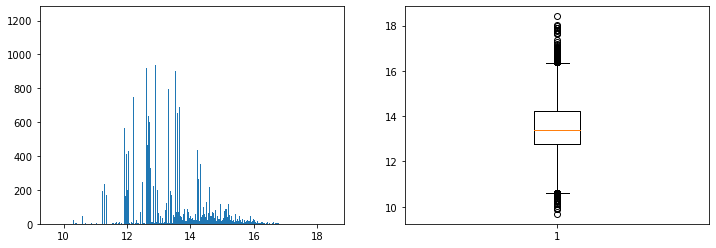

In [29]:
# Распределение для логарифма цены
d = show_info(train, 'price_log')

Количество выбросов значительно уменьшилось.
Надо обучать не для цены, а для ее логарифма, а потом брать экспоненту от результата.

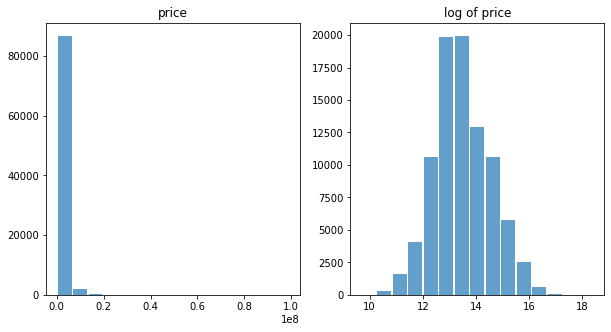

In [30]:
# Наглядное влияние логарифма
val_log_plot(train, 'price')

Не заполнено:  0
Минимум:  9.90353755128617
Максимум:  18.197537205138154
Медиана:  13.399996629152975
Количество выбросов:  924
Нижняя граница выбросов:  10.993862088206214
Верхняя граница выбросов:  15.838654909278162


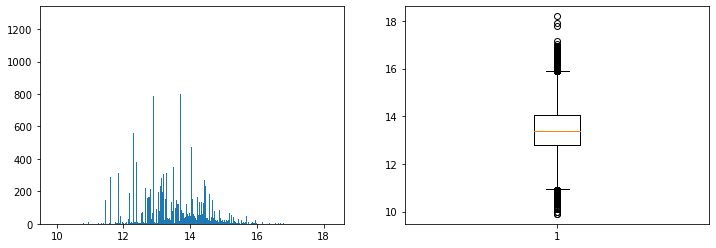

In [31]:
d = show_info(train21, 'price_log')

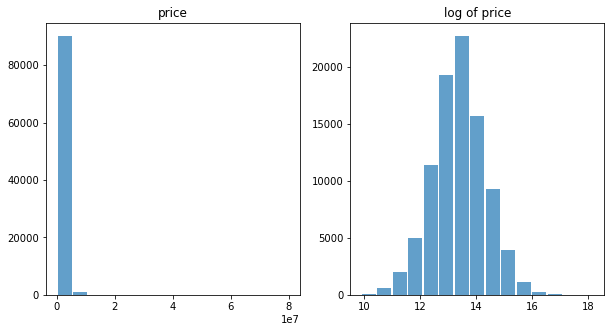

In [32]:
val_log_plot(train21, 'price')

<a id='model'></a>
## model_name и model_info

In [33]:
# Проверим, что находится в столбце model_name
display(train['model_name'].unique()[:50])
display(train21['model_name'].unique()[:50])
display(test['model_name'].unique()[:50])
display(test21['model_name'].unique()[:50])

array(['100', '200', '80', '90', '920', 'A1', 'A2', 'A3', 'A4',
       'A4_ALLROAD', 'A5', 'A6', 'ALLROAD', 'A7', 'A8', 'COUPE', 'E_TRON',
       'Q3', 'Q3_SPORTBACK', 'Q5', 'Q7', 'Q8', 'R8', 'RS3', 'RS4', 'RS5',
       'RS6', 'RS7', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'SQ5', 'TT',
       'TT_RS', 'TTS', 'V8', '02', '1ER', 'M1', '2ER', '2ACTIVETOURER',
       '2GRANDTOURER', '3ER', '321', '326', '340', '4'], dtype=object)

array(['A4\xa0', 'S5\xa0', 'Q5\xa0', 'Q3\xa0', 'A7\xa0', 'A3\xa0',
       'Q8\xa0', 'A8\xa0', 'TT\xa0', '100\xa0', 'A6\xa0', 'Q7\xa0',
       'A5\xa0', 'A1\xa0', 'RS 4\xa0', 'A6 allroad\xa0', 'SQ8\xa0',
       'A4 allroad\xa0', 'e-tron\xa0', 'S4\xa0', '80\xa0', 'RS Q3\xa0',
       'RS 7\xa0', 'R8\xa0', 'S8\xa0', 'RS 6\xa0', 'SQ5\xa0', 'S7\xa0',
       'RS 5\xa0', 'RS 3\xa0', 'S2\xa0', 'S6\xa0', '920\xa0', 'S3\xa0',
       '200\xa0', '90\xa0', 'Coupe\xa0', 'X5\xa0', '3 серии\xa0',
       'X6\xa0', 'X1\xa0', 'X3\xa0', '5 серии\xa0', '7 серии\xa0',
       '1 серии\xa0', '8 серии\xa0', 'X4\xa0', '4 серии\xa0',
       '2 серии\xa0', 'M4\xa0'], dtype=object)

array(['OCTAVIA', 'SUPERB', 'OCTAVIA_RS', 'YETI', 'KODIAQ', 'RAPID',
       'FABIA', 'ROOMSTER', 'FELICIA', 'KAROQ', 'FABIA_RS', '120',
       '100_SERIES', 'FAVORIT', 'POPULAR', 'Q5', 'R8', 'Q7', 'Q3', 'A4',
       'A3', 'A5', 'A6', 'RS7', 'S6', 'RS6', 'ALLROAD', 'TT', 'S5', 'S8',
       'A1', 'A8', '80', 'A7', 'RSQ3', 'RS3', 'A4_ALLROAD', 'Q8', '100',
       'SQ5', 'S4', 'TT_RS', 'RS4', 'S7', 'RS5', '90', 'COUPE', 'A2',
       'TTS', '920'], dtype=object)

array(['OCTAVIA', 'SUPERB', 'OCTAVIA_RS', 'YETI', 'KODIAQ', 'RAPID',
       'FABIA', 'ROOMSTER', 'FELICIA', 'KAROQ', 'FABIA_RS', '120',
       '100_SERIES', 'FAVORIT', 'POPULAR', 'Q5', 'R8', 'Q7', 'Q3', 'A4',
       'A3', 'A5', 'A6', 'RS7', 'S6', 'RS6', 'ALLROAD', 'TT', 'S5', 'S8',
       'A1', 'A8', '80', 'A7', 'RSQ3', 'RS3', 'A4_ALLROAD', 'Q8', '100',
       'SQ5', 'S4', 'TT_RS', 'RS4', 'S7', 'RS5', '90', 'COUPE', 'A2',
       'TTS', '920'], dtype=object)

In [34]:
# Переведем все наименования в нижний регистр
train['model_name'] = train['model_name'].apply(set_lower)
test['model_name'] = test['model_name'].apply(set_lower)
train21['model_name'] = train21['model_name'].apply(set_lower)
test21['model_name'] = test21['model_name'].apply(set_lower)

In [35]:
# Удалим хвосты из нового тренировочного набора и кое-что поправим
train21['model_name'] = train21['model_name'].apply(lambda x: x.replace('\xa0',''))
train21['model_name'] = train21['model_name'].apply(lambda x: x.replace(' ','_').replace('-','_'))

В поле model_name лежит очень много несовпадающих формально, но одинаковых фактически названий.
Например 1_класс и 1er - это одна и та же марка для BMW
Попробуем извлечь название модели из другого поля: model_info

In [36]:
# Проверим одинаковые ли коды 
display(train21[train21.model_name == '5_серии'].model_info)
display(test21[test21.model_name == '5er'].model_info)

2391     {"code":"5ER","name":"5 серии","ru_name":"5 се...
2400     {"code":"5ER","name":"5 серии","ru_name":"5 се...
2406     {"code":"5ER","name":"5 серии","ru_name":"5 се...
2413     {"code":"5ER","name":"5 серии","ru_name":"5 се...
2417     {"code":"5ER","name":"5 серии","ru_name":"5 се...
                               ...                        
90681    {"code":"5ER","name":"5 серии","ru_name":"5 се...
90684    {"code":"5ER","name":"5 серии","ru_name":"5 се...
90688    {"code":"5ER","name":"5 серии","ru_name":"5 се...
90689    {"code":"5ER","name":"5 серии","ru_name":"5 се...
90691    {"code":"5ER","name":"5 серии","ru_name":"5 се...
Name: model_info, Length: 1313, dtype: object

7483     {"code":"5ER","name":"5 серии","ru_name":"5 се...
7485     {"code":"5ER","name":"5 серии","ru_name":"5 се...
7488     {"code":"5ER","name":"5 серии","ru_name":"5 се...
7492     {"code":"5ER","name":"5 серии","ru_name":"5 се...
7493     {"code":"5ER","name":"5 серии","ru_name":"5 се...
                               ...                        
34662    {"code":"5ER","name":"5 серии","ru_name":"5 се...
34668    {"code":"5ER","name":"5 серии","ru_name":"5 се...
34678    {"code":"5ER","name":"5 серии","ru_name":"5 се...
34682    {"code":"5ER","name":"5 серии","ru_name":"5 се...
34683    {"code":"5ER","name":"5 серии","ru_name":"5 се...
Name: model_info, Length: 1026, dtype: object

In [37]:
# Почистим данные и преобразуем в словарь
test21['model_info'] = test21['model_info'].apply(set_None)
test21['model_name'] = test21['model_name'].apply(set_None)
# test21['model_info'] = test21['model_info'].apply(lambda x: x.replace('"',"'"))
# test21['model_info'].apply(lambda x: None if x is None else json.loads(x)) не сработало, ошибка EOF

test21['model_info'] = test21.apply(lambda row: row['model_info'] if not(row['model_info'] is None) \
                                                else "'code':'"+ row['model_name'].upper()+"',fake" \
                                                if not(row['model_name'] is None) \
                                                else "'code': '"+ row['brand'].upper()+"',fake", axis=1)
test21['model_info'] = test21['model_info'].apply(lambda x: x.replace('"',"'"))

In [38]:
intab = "{}:'" 
outtab = "    " 
trantab = str.maketrans(intab, outtab)
test21.model_name = test21.model_info.apply(lambda x: x.translate(trantab).replace('code','').split(',')[0].replace(' ','').upper())

In [39]:
train21['model_info'] = train21['model_info'].apply(lambda x: x.replace('"',"'"))
train21.model_name = train21.model_info.apply(lambda x: x.translate(trantab).replace('code','').split(',')[0].replace(' ','').upper())

In [40]:
# Сравним средние цены по моделям с пробегом в разных тренировочных наборах
df = (train[train.mileage>0].groupby('model_name')['price'].mean().to_frame()).reset_index()
df21 = (train21.groupby('model_name')['price'].mean().to_frame()).reset_index()

df['model_name'] = df['model_name'].apply(lambda x: x.upper())

df_outer = df21.merge(df, on=['model_name'], how='inner')
df_outer['coeff'] = df_outer['price_x']/df_outer['price_y']

display(df_outer)
print(df_outer['coeff'].mean())
print(train21.price.mean() / train[train.mileage>0].price.mean())

,model_name,price_x,price_y,coeff
0,100,1.211729e+05,1.264352e+05,0.958380
1,1007,3.525000e+05,4.075000e+05,0.865031
2,100NX,1.325000e+05,1.800000e+05,0.736111
3,100_SERIES,2.500000e+05,1.500000e+05,1.666667
4,106,9.900000e+04,5.750000e+04,1.721739
...,...,...,...,...
1001,Z3,1.131000e+06,1.000500e+06,1.130435
1002,Z3M,2.266666e+06,1.999999e+06,1.133334
1003,Z4,2.043615e+06,1.321809e+06,1.546074
1004,ZAFIRA,5.145439e+05,4.525762e+05,1.136922


1.1512622862030526
1.1918741704591576


Так как валидационный набор test собирался в одно время с train, надо будет учесть, что в новом собранном наборе цены отличаются от сентябрьских примерно в 1.15 - 1.20 раз. Лучше всего будет применять свой коэффициент для каждой отдельной модели.

<a id='bodyType'></a>
## bodyType

In [41]:
display(train['bodyType'].value_counts())
display(train21['bodyType'].value_counts())
display(test['bodyType'].value_counts())

Внедорожник 5 дв.                   31748
Седан                               30458
Хэтчбек 5 дв.                        8613
Универсал 5 дв.                      3370
Лифтбек                              3111
                                    ...  
Седан Latio                             1
Пикап Полуторная кабина Club Cab        1
Минивэн Brawny                          1
Минивэн Regius                          1
Седан LWB                               1
Name: bodyType, Length: 168, dtype: int64

Седан                       33279
Внедорожник 5 дв.           29053
Хэтчбек 5 дв.               11524
Универсал 5 дв.              3792
Лифтбек                      3675
Минивэн                      2535
Компактвэн                   2310
Хэтчбек 3 дв.                1932
Купе                         1311
Пикап двойная кабина          619
Внедорожник 3 дв.             356
Фургон                        258
Купе-хардтоп                  203
Кабриолет                     178
Родстер                       119
Микровэн                       55
Седан-хардтоп                  51
Пикап полуторная кабина        36
Внедорожник открытый           28
Пикап одинарная кабина         17
Хэтчбек 4 дв.                  13
Седан 2 дв.                    12
Тарга                           6
Лимузин                         4
Универсал 3 дв.                 2
Фастбек                         1
Name: bodyType, dtype: int64

седан                      13147
внедорожник 5 дв.          12228
лифтбек                     2232
хэтчбек 5 дв.               2124
универсал 5 дв.             1276
минивэн                      995
купе                         824
компактвэн                   489
хэтчбек 3 дв.                485
пикап двойная кабина         280
купе-хардтоп                 158
внедорожник 3 дв.            115
родстер                       99
фургон                        97
кабриолет                     90
седан-хардтоп                 12
микровэн                       7
седан 2 дв.                    6
лимузин                        6
пикап полуторная кабина        5
пикап одинарная кабина         5
внедорожник открытый           3
тарга                          2
фастбек                        1
Name: bodyType, dtype: int64

In [42]:
# Немного обработаем данные
train['bodyType'] = train['bodyType'].apply(set_None)
train21['bodyType'] = train21['bodyType'].apply(set_None)
test['bodyType'] = test['bodyType'].apply(set_None)
test21['bodyType'] = test21['bodyType'].apply(set_None)

train.dropna(subset=['bodyType'], inplace=True)
train21.dropna(subset=['bodyType'], inplace=True)

train['bodyType'] = train['bodyType'].apply(set_lower)
test['bodyType'] = test['bodyType'].apply(set_lower)
train21['bodyType'] = train21['bodyType'].apply(set_lower)
test21['bodyType'] = test21['bodyType'].apply(set_lower)

In [43]:
# Выделим крупные группы кузовов. Для этого возьмем первые слова в их названиях
train['body'] = train['bodyType'].apply(get_body)
test['body'] = test['bodyType'].apply(get_body)

train21['body'] = train21['bodyType'].apply(get_body)
test21['body'] = test21['bodyType'].apply(get_body)

In [44]:
test.iloc[149,:]['bodyType'], test.iloc[149,:]['body'], 

('универсал 5 дв.', 'универсал')

In [45]:
# Пометим значения из тестового набора 
bodyTest = list(test['bodyType'].unique())
train['bodyTest'] = train['bodyType'].apply(lambda x: 1 if x in bodyTest else 0)
test['bodyTest'] = 1

bodyTest = list(test21['bodyType'].unique())
train21['bodyTest'] = train21['bodyType'].apply(lambda x: 1 if x in bodyTest else 0)
test21['bodyTest'] = 1

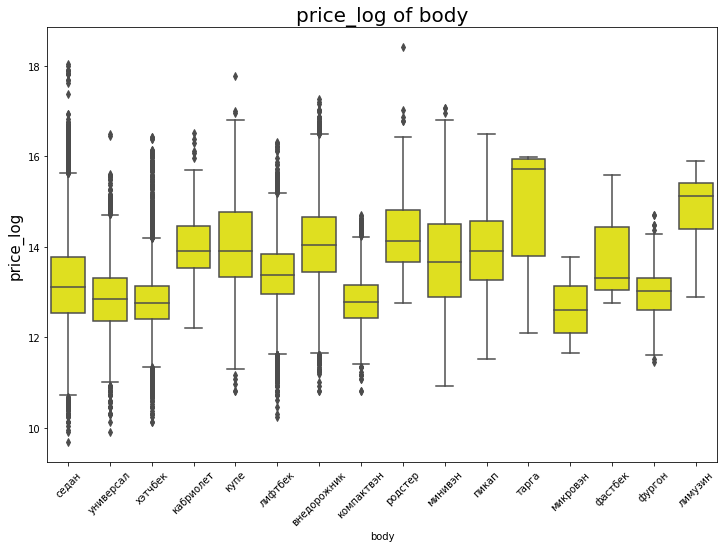

In [46]:
# Ради любопытства, посмотрим, какой кузов дороже
show_boxplot(train, 'body', 'price_log')

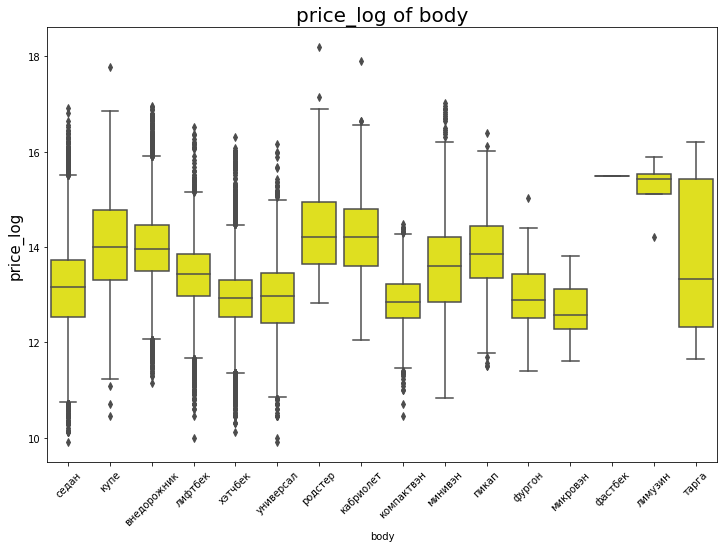

In [47]:
show_boxplot(train21, 'body', 'price_log')

<a id='brand'></a>
## brand

In [48]:
print(train['brand'].unique())
print(train21['brand'].unique())
print(test['brand'].unique())

['AUDI' 'BMW' 'CADILLAC' 'CHERY' 'CHEVROLET' 'CHRYSLER' 'CITROEN' 'DAEWOO'
 'DODGE' 'FORD' 'GEELY' 'HONDA' 'HYUNDAI' 'INFINITI' 'JAGUAR' 'JEEP' 'KIA'
 'LEXUS' 'MAZDA' 'MINI' 'MITSUBISHI' 'NISSAN' 'OPEL' 'PEUGEOT' 'PORSCHE'
 'RENAULT' 'SKODA' 'SUBARU' 'SUZUKI' 'TOYOTA' 'VOLKSWAGEN' 'VOLVO'
 'GREAT_WALL' 'LAND_ROVER' 'MERCEDES' 'SSANG_YONG']
['Audi\xa0' 'BMW\xa0' 'Chery\xa0' 'Chevrolet\xa0' 'Chrysler\xa0'
 'Citroen\xa0' 'Daewoo\xa0' 'Dodge\xa0' 'Ford\xa0' 'Geely\xa0'
 'SsangYong\xa0' 'Honda\xa0' 'Hyundai\xa0' 'Infiniti\xa0' 'Jaguar\xa0'
 'Jeep\xa0' 'Kia\xa0' 'Land Rover\xa0' 'Lexus\xa0' 'Mazda\xa0'
 'Mercedes-Benz\xa0' 'MINI\xa0' 'Mitsubishi\xa0' 'Nissan\xa0' 'Opel\xa0'
 'Peugeot\xa0' 'Porsche\xa0' 'Renault\xa0' 'Skoda\xa0' 'Subaru\xa0'
 'Suzuki\xa0' 'Cadillac\xa0' 'Toyota\xa0' 'Volkswagen\xa0' 'Volvo\xa0'
 'Great Wall\xa0']
['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI']


In [49]:
# В новом наборе приведем данные к стандартным
train21['brand'] = train21['brand'].apply(lambda x: x.replace('\xa0','').replace('mercedes-benz','mercedes').upper())
train21['brand'] = train21['brand'].apply(lambda x: x.replace('MERCEDES-BENZ','MERCEDES'))
train21['brand'] = train21['brand'].apply(lambda x: x.replace('SSANGYONG','SSANG_YONG'))
train21['brand'] = train21['brand'].apply(lambda x: x.replace(' ','_'))

In [50]:
# Пометим значения из тестового набора 
brandTest = list(test['brand'].unique())
train['brandTest'] = train['brand'].apply(lambda x: 1 if x in brandTest else 0)
test['brandTest'] = 1
train21['brandTest'] = train21['brand'].apply(lambda x: 1 if x in brandTest else 0)
test21['brandTest'] = 1

In [51]:
# Разобьем на четыре бренда по примерному уровню цен 
brand_0 = [ 'DAEWOO', 'SSANG_YONG','CHERY', 'GREAT_WALL', 'GEELY']
brand_1 = ['KIA', 'CHEVROLET', 'RENAULT', 'PEUGEOT','CITROEN',
       'DODGE','OPEL', 'MINI', 'HYUNDAI', 'FORD', 'SKODA']
brand_2 = ['AUDI', 'BMW','MAZDA', 'SUBARU', 'SUZUKI', 'TOYOTA', 'VOLKSWAGEN',
           'VOLVO','CHRYSLER','HONDA',  'MITSUBISHI', 'NISSAN', 'MERCEDES']
brand_3 = ['LAND_ROVER', 'PORSCHE', 'CADILLAC', 
           'JAGUAR', 'INFINITI', 'JEEP','LEXUS']


train['brandRang'] = train['brand'].apply(lambda x: \
                                0 if x in brand_0 else \
                                1 if x in brand_1 else \
                                2 if x in brand_2 else 3)

test['brandRang'] = test['brand'].apply(lambda x: \
                                0 if x in brand_0 else \
                                1 if x in brand_1 else \
                                2 if x in brand_2 else 3)

train21['brandRang'] = train21['brand'].apply(lambda x: \
                                0 if x in brand_0 else \
                                1 if x in brand_1 else \
                                2 if x in brand_2 else 3)

test21['brandRang'] = test21['brand'].apply(lambda x: \
                                0 if x in brand_0 else \
                                1 if x in brand_1 else \
                                2 if x in brand_2 else 3)

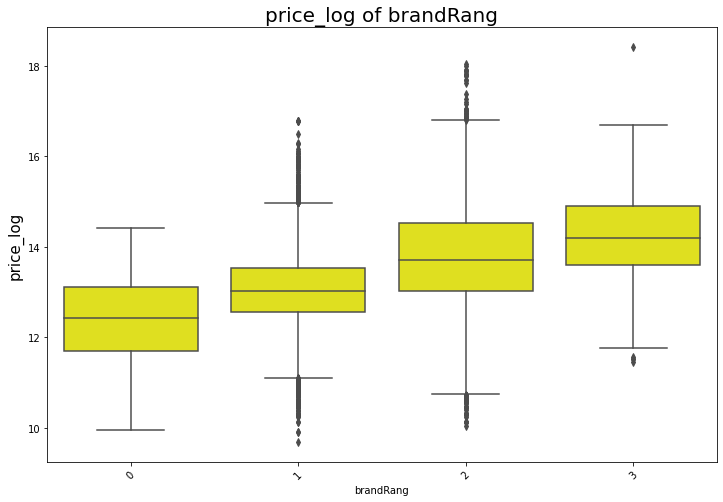

In [52]:
# Ради любопытства, посмотрим, какой бренд дороже
show_boxplot(train, 'brandRang', 'price_log')

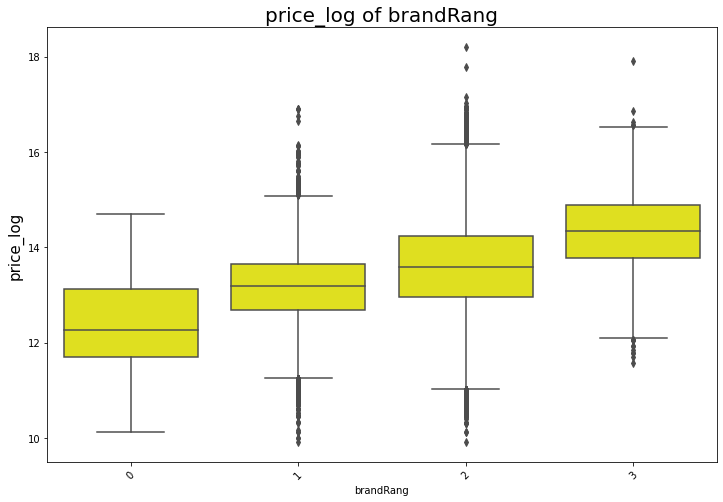

In [53]:
show_boxplot(train21, 'brandRang', 'price_log')

In [54]:
train['brand'] = train['brand'].apply(set_lower)
test['brand'] = test['brand'].apply(set_lower)
train21['brand'] = train21['brand'].apply(set_lower)
test21['brand'] = test21['brand'].apply(set_lower)

<a id='color'></a>
## color

In [55]:
train['color'].value_counts()

040001    25094
FAFBFB    15761
CACECB    11282
97948F    10773
0000CC     8825
EE1D19     4489
200204     3562
007F00     2592
C49648     1841
22A0F8     1392
DEA522      771
660099      746
FFD600      699
4A2197      600
FF8649      515
FFC0CB       25
Name: color, dtype: int64

In [56]:
train21['color'].value_counts()

чёрный         22820
белый          18628
серебристый    12017
серый          11355
синий           8352
красный         5191
коричневый      3769
зелёный         2569
бежевый         1970
голубой         1409
золотистый       807
пурпурный        656
жёлтый           646
фиолетовый       591
оранжевый        560
розовый           29
Name: color, dtype: int64

In [57]:
test['color'].value_counts()

чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: color, dtype: int64

В новом наборе цвета соответствуют цветам валидационного набора. В старом цвета требуют приведения к русским наименованиям.

In [58]:
# В train переименуем названия цветов
color_dict={'040001': 'чёрный', 'FAFBFB': 'белый','CACECB': 'серебристый',
            '97948F': 'серый', '0000CC': 'синий', 'EE1D19': 'красный',
            '200204': 'коричневый', '007F00': 'зелёный',
            'C49648': 'бежевый', '22A0F8': 'голубой', 'DEA522': 'золотистый', 
            '660099': 'пурпурный', 'FFD600': 'жёлтый', '4A2197': 'фиолетовый',
            'FF8649': 'оранжевый','FFC0CB': 'розовый'
            }
train['color'] = train['color'].map(color_dict)

In [59]:
# Сделаем признак популярности цвета
color_rare = ['жёлтый', 'оранжевый', 'пурпурный', 'фиолетовый', 'розовый']
color_freq = ['чёрный', 'белый', 'серебристый', 'серый', 'синий']
train['color_type'] = train['color'].apply(lambda x: 0 if x in color_freq else 2 if x in color_rare else 1)
test['color_type'] = test['color'].apply(lambda x: 0 if x in color_freq else 2 if x in color_rare else 1)
train21['color_type'] = train21['color'].apply(lambda x: 0 if x in color_freq else 2 if x in color_rare else 1)
test21['color_type'] = test21['color'].apply(lambda x: 0 if x in color_freq else 2 if x in color_rare else 1)

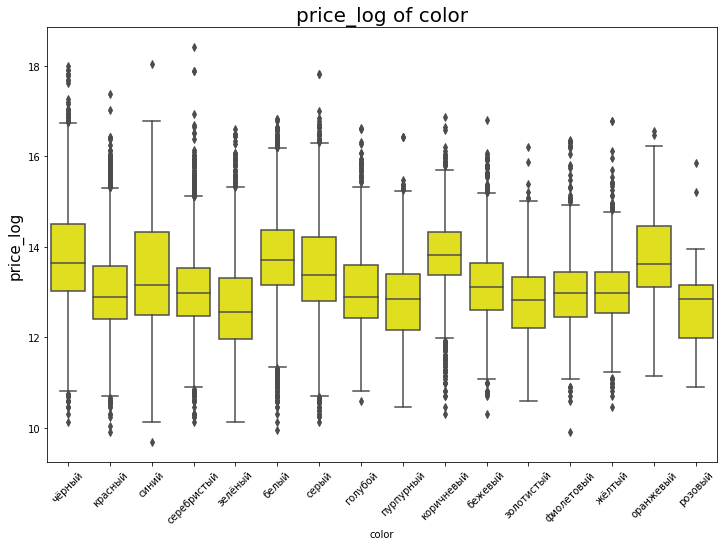

In [60]:
# Посмотрим, какие цвета дороже 
show_boxplot(train, 'color', 'price_log')

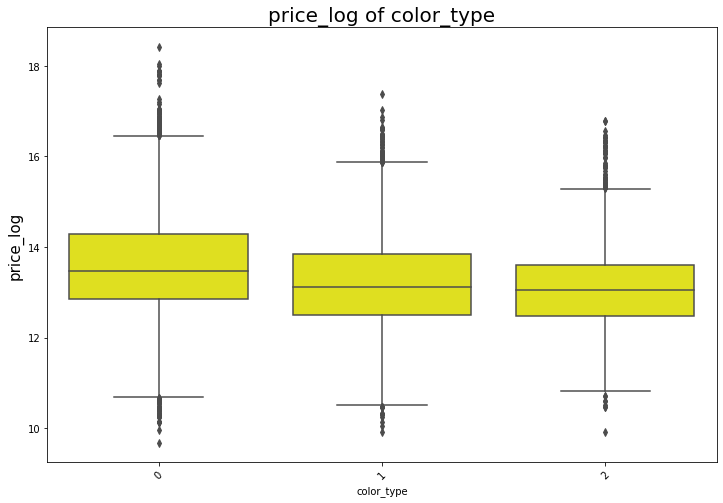

In [61]:
# Посмотрим, какие группы цветов дороже 
show_boxplot(train, 'color_type', 'price_log')

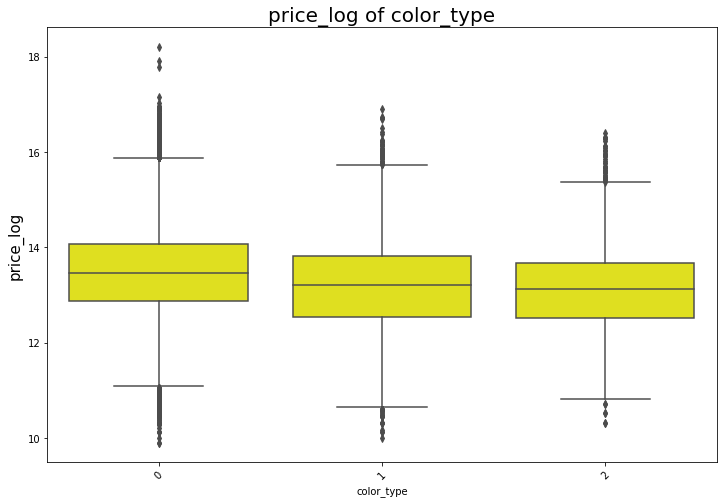

In [62]:
show_boxplot(train21, 'color_type', 'price_log')

Редкие цвета в среднем подешевле, частые цвета - подороже.

<a id='enginePower'></a>
## enginePower

In [63]:
print(train.enginePower.unique()[:20])
print(test.enginePower.unique()[:20])
print(train21.enginePower.unique()[:20])

[174.  90. 136. 101. 133. 150. 115. 137. 112. 230.  70.  88. 100.  75.
 165. 182. 170. 113.  80.  54.]
['105 N12' '110 N12' '152 N12' '200 N12' '102 N12' '150 N12' '90 N12'
 '180 N12' '220 N12' '122 N12' '70 N12' '140 N12' '125 N12' '54 N12'
 '86 N12' '75 N12' '64 N12' '95 N12' '260 N12' '170 N12']
[190 354 180 177 300 150 249 225 310 230 133 204 340 125 122 170 350 211
 239 333]


In [64]:
# В test приведем данный столбец к тому же виду, как в train
test['enginePower'] = test['enginePower'].apply(lambda x: str(x).split()[0])
test21['enginePower'] = test21['enginePower'].apply(lambda x: str(x).split()[0])

In [65]:
# Приведем к целым числам (почему-то не сработал astype)
test['enginePower'] = test['enginePower'].apply(lambda x: int(x))
test21['enginePower'] = test['enginePower'].apply(lambda x: int(x))
train['enginePower'] = train['enginePower'].apply(lambda x: int(x))

In [66]:
train21['enginePower'] = train21['enginePower'].apply(lambda x: str(x).replace('\xa0кВт',''))
train21['enginePower'] = train21['enginePower'].apply(lambda x: float(x))
train21['enginePower'] = train21['enginePower'].apply(lambda x: int(x))

In [67]:
# Есть автомобили с очень маленькой мощностью. Посмотрим на них
display(test[(test['enginePower']<=36)].iloc[:, :20])
display(train[(train['enginePower']<=36)].iloc[:, :20])
display(train21[(train21['enginePower']<=36)].iloc[:, :20])

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_info,model_name,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,Владельцы,Владение
1777,хэтчбек 3 дв.,skoda,чёрный,NaN,"Авто после длительного простоя, под восстановл...",1.1 LTR,30,NaN,бензин,14000,1934,"{""code"":""POPULAR"",""name"":""Popular"",""ru_name"":""...",popular,1.1 MT (30 л.с.),3,1939,HATCHBACK_3_DOORS MECHANICAL 1.1,механическая,3 или более,NaN
16944,кабриолет,mercedes,белый,NaN,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3 LTR,32,NaN,бензин,48000,1904,"{""code"":""SIMPLEX"",""name"":""Simplex"",""ru_name"":""...",simplex,5.3 MT (32 л.с.),0,1904,CABRIO MECHANICAL 5.3,механическая,1 владелец,6 лет и 8 месяцев


,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,complectation_dict,Привод,Руль,Владельцы,ПТС,Владение
22691,кабриолет,ford,зелёный,бензин,1908.0,2.9 MT (20 л.с.),2.0,1923,CABRIO MECHANICAL 2.9,MECHANICAL,2.9,20,1 октября 1908 Форд воплотил в жизнь свою мечт...,1000,{'id': '0'},задний,LEFT,1.0,ORIGINAL,NaN
22692,кабриолет,ford,чёрный,бензин,1908.0,2.9 MT (20 л.с.),2.0,1924,CABRIO MECHANICAL 2.9,MECHANICAL,2.9,20,"Главный автомобиль XX века, без которого, наве...",30000,{'id': '0'},задний,LEFT,1.0,ORIGINAL,NaN
59955,купе,renault,белый,электро,2011.0,Electro AT (13 кВт),2.0,2012,COUPE AUTOMATIC Electro,AUTOMATIC,Electro,17,"Твизи от дилера, остаточный ресурс батареи 95-...",1959,{'id': '0'},задний,LEFT,2.0,ORIGINAL,"{'year': 2018, 'month': 11}"
59956,купе,renault,чёрный,электро,2011.0,Electro AT (9 кВт),2.0,2016,COUPE AUTOMATIC Electro,AUTOMATIC,Electro,11,"Идеальное состояние, использовался очень береж...",1800,"{'id': '20841229', 'name': 'CARGO', 'available...",задний,LEFT,2.0,ORIGINAL,"{'year': 2018, 'month': 10}"
61846,хэтчбек 3 дв.,skoda,чёрный,бензин,1934.0,1.1 MT (30 л.с.),3.0,1939,HATCHBACK_3_DOORS MECHANICAL 1.1,MECHANICAL,1.1,30,"Авто после длительного простоя, под восстановл...",14000,{'id': '0'},задний,LEFT,3.0,ORIGINAL,NaN
88065,кабриолет,mercedes,белый,бензин,1904.0,5.3 MT (32 л.с.),0.0,1904,CABRIO MECHANICAL 5.3,MECHANICAL,5.3,32,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",48000,{'id': '0'},задний,RIGHT,1.0,ORIGINAL,"{'year': 2014, 'month': 2}"


,acceleration,bodyType,brand,clearance_min,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,fuel_rate,mileage,modelDate,model_info,model_name,numberOfDoors,price,productionDate,super_gen
3630,-,хэтчбек 3 дв.,bmw,165.0,бежевый,"{""id"":""0""}",Вашему вниманию предлагается BMW 600 выпуска 1...,0.6,19,"{""steel-wheels"":true,""combo-interior"":true}",Бензин,-,80000.0,1957.0,"{'code':'600','name':'600','ru_name':'600','mo...",600,3.0,5050000.0,1959.0,"{""id"":""20745563"",""year_from"":1957,""year_to"":19..."
10693,-,кабриолет,ford,-,зелёный,"{""id"":""0""}",1 октября 1908 Форд воплотил в жизнь свою мечт...,2.9,20,{},Бензин,-,1000.0,1908.0,"{'code':'MODEL_T','name':'Model T','ru_name':'...",MODEL_T,2.0,3800000.0,1923.0,"{""id"":""20650941"",""year_from"":1908,""year_to"":19..."
27141,110 × 140,кабриолет,mercedes,110 × 140,белый,"{""id"":""0""}","на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,32,{},Бензин,110 × 140,48000.0,1904.0,"{'code':'SIMPLEX','name':'Simplex','ru_name':'...",SIMPLEX,0.0,12000000.0,1904.0,"{""id"":""21743718"",""year_from"":1904,""year_to"":19..."
39180,3.5,купе,renault,120.0,чёрный,"{""id"":""20841229"",""name"":""CARGO"",""available_opt...","Идеальное состояние, использовался очень береж...",11.0,8,"{""computer"":true,""steel-wheels"":true,""bluetoot...",Электро,3.5,1800.0,2011.0,"{'code':'TWIZY','name':'Twizy','ru_name':'Твиз...",TWIZY,2.0,549000.0,2016.0,"{""id"":""20350345"",""year_from"":2011,""price_segme..."
44532,50,купе,toyota,130,белый,"{""id"":""0""}","автомобиль практически новый, доя передвижения...",7.0,5,{},Электро,50,700.0,2012.0,"{'code':'COMS','name':'COMS','ru_name':'КОМС',...",COMS,2.0,270000.0,2013.0,"{""id"":""21545811"",""year_from"":2012,""price_segme..."
74423,-,кабриолет,ford,-,чёрный,"{""id"":""0""}","Ford Model T – автомобиль, с которого началась...",2.9,20,{},Бензин,-,68000.0,1908.0,"{'code':'MODEL_T','name':'Model T','ru_name':'...",MODEL_T,4.0,17000000.0,1922.0,"{""id"":""20650941"",""year_from"":1908,""year_to"":19..."
76812,-,купе,volkswagen,150,красный,"{""id"":""0""}","Восстановлен в 2017, на хорошем ходу, иногда в...",1.2,34,{},Бензин,-,97000.0,1938.0,"{'code':'TYPE_1','name':'Type 1','ru_name':'та...",TYPE_1,2.0,654321.0,1978.0,"{""id"":""20343015"",""year_from"":1938,""year_to"":20..."
76825,-,купе,volkswagen,150,зелёный,"{""id"":""0""}",Продам Фольксфаген Kafer(Жук) купе 1973г/в дви...,1.2,34,"{""steel-wheels"":true,""led-lights"":true}",Бензин,-,26500.0,1938.0,"{'code':'TYPE_1','name':'Type 1','ru_name':'та...",TYPE_1,2.0,650000.0,1973.0,"{""id"":""20343015"",""year_from"":1938,""year_to"":20..."
80462,-,хэтчбек 3 дв.,opel,-,красный,"{""id"":""0""}",Opel Adam A 1928 г. в. НЕ СЕРИЙНЫЙ автомобиль....,1.2,23,{},Бензин,-,1000.0,1935.0,"{'code':'P4','name':'P4','ru_name':'П4','morph...",P4,3.0,2300000.0,1937.0,"{""id"":""20760448"",""year_from"":1935,""year_to"":19..."
97608,16,микровэн,mitsubishi,165,белый,"{""id"":""0""}",Без пробега по России. Полностью электрический...,41.0,30,"{""asr"":true,""esp"":true,""reduce-spare-wheel"":tr...",Электро,16,97000.0,1999.0,"{'code':'MINICAB','name':'Minicab','ru_name':'...",MINICAB,5.0,489196.0,2011.0,"{""id"":""20497041"",""year_from"":1999,""year_to"":20..."


In [68]:
# Видно, что большинство машин старые, раритетные, кроме современных электрических, которые выбиваются из стандартных машин. 
# В тестовом наборе нет очень маломощных электромашин. Удалим их.
train = train[train.enginePower>18]
train21 = train21[train21.enginePower>18]

In [69]:
# Добавим столбец с налоговой ставкой на мощность автомобиля
bins = [0, 100, 125, 150, 175, 200, 225, 250, 801]
labels = ['12','25','35', '45', '50', '65', '75', '150']
train['tax_rate'] = pd.cut(train['enginePower'], bins=bins, labels=labels)
train['tax_rate'] = train['tax_rate'].values.astype('int64')
test['tax_rate'] = pd.cut(test['enginePower'], bins=bins, labels=labels)
test['tax_rate'] = test['tax_rate'].values.astype('int64')
train21['tax_rate'] = pd.cut(train21['enginePower'], bins=bins, labels=labels)
train21['tax_rate'] = train21['tax_rate'].values.astype('int64')
test21['tax_rate'] = pd.cut(test21['enginePower'], bins=bins, labels=labels)
test21['tax_rate'] = test21['tax_rate'].values.astype('int64')

In [70]:
# Добавим столбец с самим налогом
train['tax'] = train['enginePower']*train['tax_rate']
test['tax'] = test['enginePower']*test['tax_rate']
train21['tax'] = train21['enginePower']*train21['tax_rate']
test21['tax'] = test21['enginePower']*test21['tax_rate']

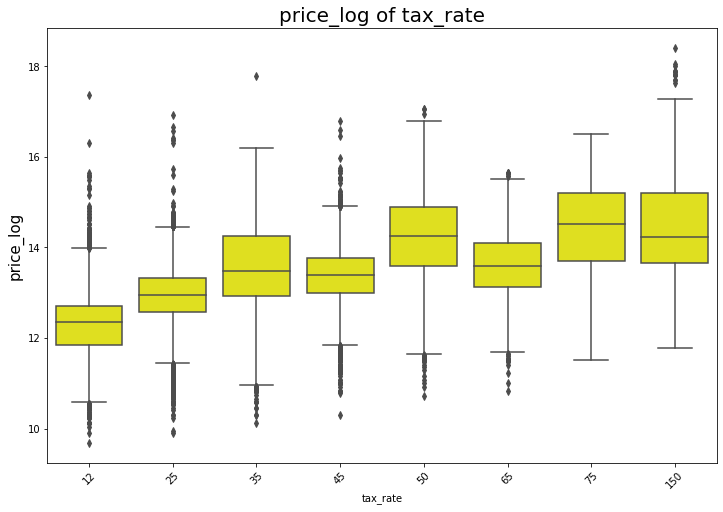

In [71]:
# Посмотрим, как ставка налога связана с ценой 
show_boxplot(train, 'tax_rate', 'price_log')

В целом, цена растет, но есть исключения. Скорее всего, тут играет роль возраст машины.

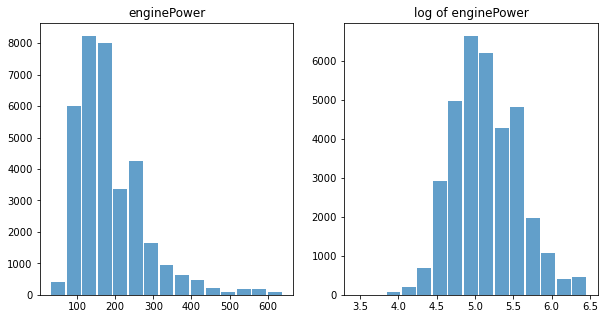

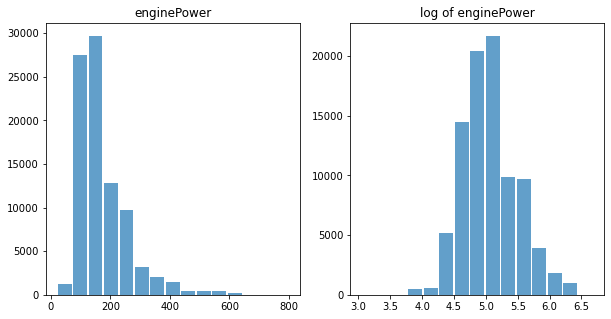

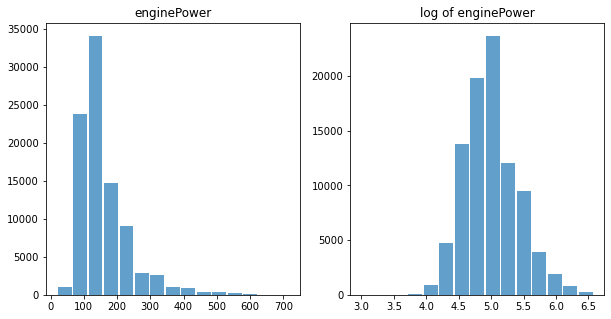

In [72]:
# Посмотрим на влияние логарифма
val_log_plot(test, 'enginePower')
val_log_plot(train, 'enginePower')
val_log_plot(train21, 'enginePower')

In [73]:
# Распределение улучшилось. Добавим столбец с логарифмом.
test['eP_log'] = np.log(test['enginePower'] + 1)
train['eP_log'] = np.log(train['enginePower'] + 1)
test21['eP_log'] = np.log(test21['enginePower'] + 1)
train21['eP_log'] = np.log(train21['enginePower'] + 1)

Не заполнено:  0
Минимум:  3.044522437723423
Максимум:  6.68586094706836
Медиана:  5.017279836814924
Количество выбросов:  2085
Нижняя граница выбросов:  4.0035901911063645
Верхняя граница выбросов:  6.048317366548036


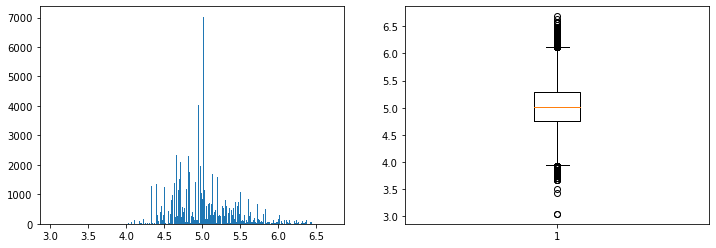

In [74]:
# Проверим наличие выбросов
d = show_info(train,'eP_log')

In [75]:
# Пометим строки с выбросами логарифма специальным признаком
d = show_info(train,'eP_log', show=False)
train['eP_log_out'] = train['eP_log'].apply(lambda x: 1 if x>d['lm2'] else 0)

d = show_info(test,'eP_log', show=False)
test['eP_log_out'] = test['eP_log'].apply(lambda x: 1 if x>d['lm2'] else 0)

d = show_info(train21,'eP_log', show=False)
train21['eP_log_out'] = train21['eP_log'].apply(lambda x: 1 if x>d['lm2'] else 0)

d = show_info(test21,'eP_log', show=False)
test21['eP_log_out'] = test21['eP_log'].apply(lambda x: 1 if x>d['lm2'] else 0)

<a id='engineDisplacement'></a>
## engineDisplacement

In [76]:
print(train.engineDisplacement.unique()[:40])
print(test.engineDisplacement.unique())
print(train21.engineDisplacement.unique()[:40])

['2.8' '1.8' '2.3' '2.0' '2.6' '2.2' 'S4' '2.0d' '2.5d' '1.9' '2.1' '2.4'
 '1.6' '1.9d' '1.6d' '1.3' '3.3' '1.4' '1.2d' 'ultra' '1.2' '3.2' '1.5'
 '8V' '3.1' '3.0d' '2.7d' '16V' '3.0' '7S-tronic' 'tiptronic' '40' '45'
 '55' '2.7' '4.2' 'S-tronic' 'Tiptronic' 'Long' '4.0']
['1.2 LTR' '1.6 LTR' '1.8 LTR' '2.0 LTR' '1.4 LTR' '1.3 LTR' '1.0 LTR'
 '3.6 LTR' '1.5 LTR' '1.9 LTR' '2.8 LTR' '1.1 LTR' '2.5 LTR' '4.2 LTR'
 '3.0 LTR' '4.0 LTR' '5.9 LTR' '2.7 LTR' '3.1 LTR' '2.4 LTR' '5.2 LTR'
 '3.2 LTR' '4.1 LTR' '6.3 LTR' '2.3 LTR' '6.0 LTR' '2.2 LTR' '3.7 LTR'
 '2.9 LTR' '5.0 LTR' '3.3 LTR' '2.1 LTR' '2.6 LTR' ' LTR' '3.5 LTR'
 '1.7 LTR' '0.7 LTR' '4.4 LTR' '4.8 LTR' '5.4 LTR' '6.6 LTR' '4.9 LTR'
 '3.8 LTR' '3.4 LTR' '3.9 LTR' '4.6 LTR' '5.6 LTR' '4.5 LTR' '5.5 LTR'
 '6.2 LTR' '4.7 LTR' '4.3 LTR' '5.8 LTR' '5.3 LTR' '5.7 LTR']
[  2.    4.2   3.    1.4   2.3   2.8   1.8   3.1   4.1   4.    2.9   3.6
   2.5   1.2   6.3   2.4 313.  408.    1.6   3.2   5.2   3.7   5.9   2.7
   5.    2.2   2.6   3.3 

Во всех наборах есть электрические автомобили с отсутствующим объемом двигателя либо с объемом больше 20. Эти объемы двигателей во всех наборах заменим на число в зависимости от мощности: разделим мощность 70. Это очень условный коэффициент, но он отображает тенденцию.

Практически та же информация об объеме лежит в другом поле. Посмотрим на поле name, оно поможет разобраться с непонятными значениями в наборе train. В наборе train21 данные уже в нужном формате.

In [77]:
print(train.name.unique()[:30])
print(test.name.unique()[:30])

['2.8 MT (174 л.с.) 4WD' '1.8 MT (90 л.с.)' '2.3 MT (136 л.с.) 4WD'
 '2.0 MT (101 л.с.)' '2.8 MT (174 л.с.)' '2.3 MT (133 л.с.)'
 '2.6 MT (150 л.с.)' '2.0 AT (115 л.с.)' '2.8 AT (174 л.с.)'
 '2.0 MT (115 л.с.)' '2.3 AT (133 л.с.)' '2.2 MT (137 л.с.)'
 '2.0 AT (112 л.с.)' '2.3 MT (133 л.с.) 4WD' 'S4 2.2 AT (230 л.с.) 4WD'
 '2.0d MT (70 л.с.)' '2.5d MT (115 л.с.)' '1.8 MT (88 л.с.)'
 '1.9 MT (100 л.с.)' '2.1 MT (115 л.с.)' '2.4 AT (136 л.с.)'
 '1.8 MT (75 л.с.)' '2.1 MT (136 л.с.)' '2.1 AT (136 л.с.)'
 '2.2 MT (165 л.с.)' '2.1 MT (182 л.с.)' '2.1 MT (170 л.с.)'
 '2.1 AT (170 л.с.)' '1.8 AT (90 л.с.)' '2.0 MT (90 л.с.)']
['1.2 AMT (105 л.с.)' '1.6 MT (110 л.с.)' 'DSG 1.8 AMT (152 л.с.)'
 '1.6 AT (110 л.с.)' '1.8 AT (152 л.с.)' '2.0 AMT (200 л.с.)'
 '1.8 AMT (152 л.с.) 4WD' '1.6 MT (102 л.с.)' '1.4 MT (150 л.с.) 4WD'
 '1.8 MT (152 л.с.) 4WD' '1.6 MT (90 л.с.)' '1.4 AMT (150 л.с.)'
 '1.8 AMT (180 л.с.)' '1.4 AMT (150 л.с.) 4WD' '1.6 AT (102 л.с.)'
 '2.0d AMT (150 л.с.) 4WD' '2.0 AMT (220 л.

In [78]:
# Объем двигателя для старых наборов заберем из столбца name
train['engineDisplacement'] = train['name'].astype(str).apply(
    lambda x: re.findall(r"(\d+\.\d+)", x.split('(')[0])).apply(lambda x: 0 if not x else x[0]).astype(float)
test['engineDisplacement'] = test['name'].astype(str).apply(
    lambda x: re.findall(r"(\d+\.\d+)", x.split('(')[0])).apply(lambda x: 0 if not x else x[0]).astype(float)
test21['engineDisplacement'] = test21['name'].astype(str).apply(
    lambda x: re.findall(r"(\d+\.\d+)", x.split('(')[0])).apply(lambda x: 0 if not x else x[0]).astype(float)

In [79]:
print(train['engineDisplacement'].unique())
print(test['engineDisplacement'].unique())
print(train21['engineDisplacement'].unique())

[2.8 1.8 2.3 2.  2.6 2.2 2.5 1.9 2.1 2.4 1.6 1.3 3.3 1.4 1.2 3.2 1.5 3.1
 3.  2.7 4.2 4.  3.9 6.3 6.  3.7 4.1 0.  3.6 5.9 5.2 2.9 5.  1.7 4.4 3.4
 3.5 4.8 5.4 6.6 0.7 4.9 4.6 6.2 4.5 6.4 8.2 5.3 5.7 7.  1.1 0.8 4.3 8.1
 6.7 3.8 1.  7.5 7.4 6.5 6.1 6.8 4.7 8.4 5.8 7.3 5.6 5.5]
[1.2 1.6 1.8 2.  1.4 1.3 1.  3.6 1.5 1.9 2.8 1.1 2.5 4.2 3.  4.  5.9 2.7
 3.1 2.4 5.2 3.2 4.1 6.3 2.3 6.  2.2 3.7 2.9 5.  3.3 2.1 2.6 0.  3.5 1.7
 0.7 4.4 4.8 5.4 6.6 4.9 3.8 3.4 3.9 4.6 5.6 4.5 5.5 6.2 4.7 4.3 5.8 5.3
 5.7]
[2.00e+00 4.20e+00 3.00e+00 1.40e+00 2.30e+00 2.80e+00 1.80e+00 3.10e+00
 4.10e+00 4.00e+00 2.90e+00 3.60e+00 2.50e+00 1.20e+00 6.30e+00 2.40e+00
 3.13e+02 4.08e+02 1.60e+00 3.20e+00 5.20e+00 3.70e+00 5.90e+00 2.70e+00
 5.00e+00 2.20e+00 2.60e+00 3.30e+00 2.10e+00 1.50e+00 6.00e+00 1.90e+00
 1.30e+00 6.60e+00 4.40e+00 4.80e+00 1.70e+02 3.40e+00 7.00e-01 4.90e+00
 3.80e+00 5.40e+00 3.90e+00 6.00e-01 1.84e+02 4.60e+00 3.50e+00 1.10e+00
 8.00e-01 1.70e+00 5.30e+00 6.20e+00 1.00e+00 5.70e+00 6.50e

In [80]:
# Заменим у электроавтомобилей объем двигателя на значение от мощности
train['engineDisplacement'] = train.apply(lambda row: row['engineDisplacement'] if row['engineDisplacement']>0 \
                                          else np.round(row['enginePower']/70, 1), axis=1)
test['engineDisplacement'] = test.apply(lambda row: row['engineDisplacement'] if row['engineDisplacement']>0 \
                                          else np.round(row['enginePower']/70, 1), axis=1)
test21['engineDisplacement'] = test21.apply(lambda row: row['engineDisplacement'] if row['engineDisplacement']>0 \
                                          else np.round(row['enginePower']/70, 1), axis=1)
train21['engineDisplacement'] = train21.apply(lambda row: row['engineDisplacement'] if row['engineDisplacement']<20 \
                                          else np.round(row['enginePower']/70, 1), axis=1)

Не заполнено:  0
Минимум:  0.4
Максимум:  8.2
Медиана:  2.0
Количество выбросов:  5350
Нижняя граница выбросов:  0.3999999999999999
Верхняя граница выбросов:  3.6


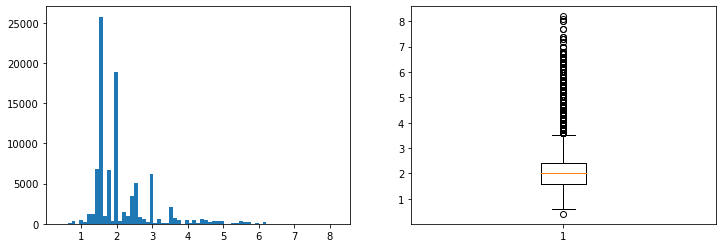

In [81]:
# Посмотрим на распределение значений признака
d = show_info(train21, 'engineDisplacement')

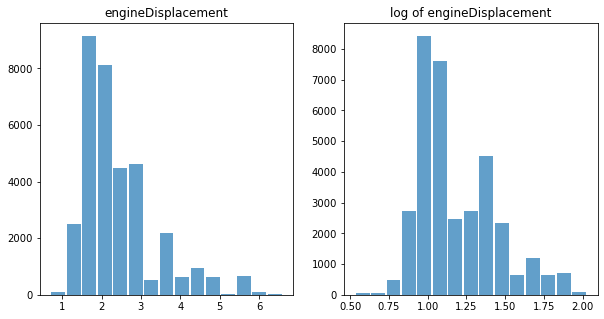

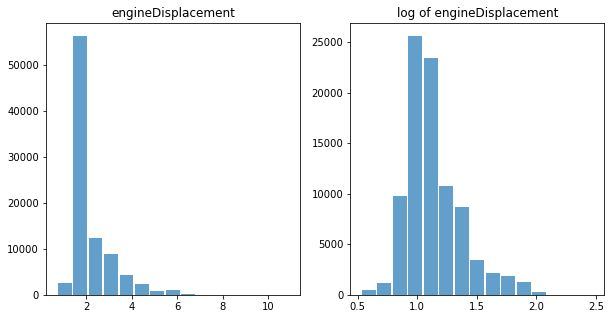

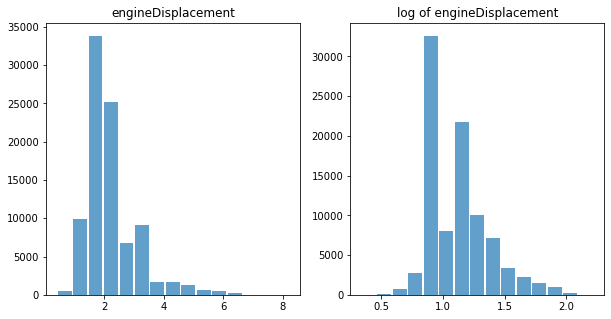

In [82]:
# Посмотрим на влияние логарифма
val_log_plot(test, 'engineDisplacement')
val_log_plot(train, 'engineDisplacement')
val_log_plot(train21, 'engineDisplacement')

Распределение немного улучшилось. Имеет смысл использовать логарифм этого признака.

In [83]:
# Новый столбец с логарифмом 
test['eD_log'] = np.log(test['engineDisplacement'] + 1)
train['eD_log'] = np.log(train['engineDisplacement'] + 1)
test21['eD_log'] = np.log(test21['engineDisplacement'] + 1)
train21['eD_log'] = np.log(train21['engineDisplacement'] + 1)

Не заполнено:  0
Минимум:  0.3364722366212129
Максимум:  2.2192034840549946
Медиана:  1.0986122886681098
Количество выбросов:  3799
Нижняя граница выбросов:  0.5055114450274364
Верхняя граница выбросов:  1.6737754316221156


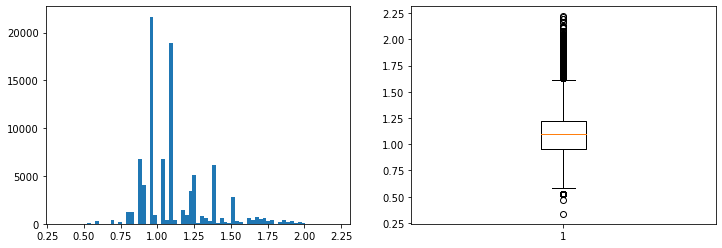

In [84]:
d = show_info(train21, 'eD_log')

Выбросов стало немного меньше. Ничего с этим не будем делать, просто пометим значения с выбросами отдельным признаком.

In [85]:
# Пометим строки с выбросами логарифма специальным признаком
d = show_info(train,'eD_log', show=False)
train['eD_log_out'] = train['eD_log'].apply(lambda x: 1 if x>d['lm2'] else 0)

d = show_info(test,'eD_log', show=False)
test['eD_log_out'] = test['eD_log'].apply(lambda x: 1 if x>d['lm2'] else 0)

d = show_info(train21,'eD_log', show=False)
train21['eD_log_out'] = train21['eD_log'].apply(lambda x: 1 if x>d['lm2'] else 0)

d = show_info(test21,'eD_log', show=False)
test21['eD_log_out'] = test21['eD_log'].apply(lambda x: 1 if x>d['lm2'] else 0)

<a id='fuelType'></a>
## fuelType

In [86]:
print(train.fuelType.unique())
print(test.fuelType.unique())
print(train21.fuelType.unique())

['бензин' 'дизель' 'электро' 'гибрид' 'газ']
['бензин' 'дизель' 'гибрид' 'электро' 'газ']
['Дизель' 'Бензин' 'Бензин,газобаллонноеоборудование' 'Электро' 'Гибрид'
 'Дизель,газобаллонноеоборудование' 'Газ,газобаллонноеоборудование' 'Газ'
 'Гибрид,газобаллонноеоборудование']


In [87]:
# В новом наборе приведем данные к стандарту
fuel_dict={'Дизель': 'дизель', 'Бензин': 'бензин', 'Газ': 'газ',
            'Бензин,газобаллонноеоборудование': 'гибрид', 
            'Электро': 'электро', 'Гибрид': 'гибрид',
            'Дизель,газобаллонноеоборудование': 'гибрид', 
            'Газ,газобаллонноеоборудование': 'газ', 
            'Гибрид,газобаллонноеоборудование': 'гибрид'
            }
train21['fuelType'] = train21['fuelType'].map(fuel_dict)

In [88]:
# Простая обработка
test['fuelType'] = test['fuelType'].apply(set_None)
test21['fuelType'] = test21['fuelType'].apply(set_None)
train['fuelType'] = train['fuelType'].apply(set_None)

In [89]:
print(train.fuelType.unique())
print(test.fuelType.unique())
print(train21.fuelType.unique())
print(test21.fuelType.unique())

['бензин' 'дизель' 'электро' 'гибрид' 'газ']
['бензин' 'дизель' 'гибрид' 'электро' 'газ']
['дизель' 'бензин' 'гибрид' 'электро' 'газ']
['бензин' 'дизель' 'гибрид' 'электро' 'газ']


In [90]:
# Проверим, что слова написаны одинаково и преобразование не требуется
set(test['fuelType'].unique()).union(set(train['fuelType'].unique()))

{'бензин', 'газ', 'гибрид', 'дизель', 'электро'}

<a id='Привод'></a>
## Привод

In [91]:
print(train.Привод.unique())
print(test.Привод.unique())
print(train21.Привод.unique())

['полный' 'передний' 'задний']
['передний' 'полный' 'задний']
['полный' 'передний' 'задний' nan]


In [92]:
# Проверим, почему в новом наборе не указан привод
train21[train21.Привод.isnull()].iloc[:, 4:20]

,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,fuel_rate,mileage,modelDate,model_info,model_name,numberOfDoors,price,productionDate,super_gen
11293,серый,"{""id"":""0""}",NaN,1.6,125,{},бензин,NaN,119000.0,NaN,"{'code':'FOCUS','name':'Focus','ru_name':'Фоку...",FOCUS,NaN,489000.0,2013.0,"{""id"":""7306596"",""name"":""III"",""ru_name"":""3"",""ye..."
12737,серебристый,"{""id"":""0""}","Торг у капота на бензин За машину не стыдно, в...",1.5,94,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,NaN,89700.0,NaN,"{'code':'MK_CROSS','name':'MK Cross','ru_name'...",MK_CROSS,NaN,290000.0,2013.0,"{""id"":""7767411"",""name"":""I"",""year_from"":2010,""y..."
15836,белый,"{""id"":""0""}",В хорошем состоянии. Есть лицензия до 2024 года.,1.4,107,{},бензин,NaN,340000.0,NaN,"{'code':'SOLARIS','name':'Solaris','ru_name':'...",SOLARIS,NaN,380000.0,2014.0,"{""id"":""20162370"",""name"":""I Рестайлинг"",""ru_nam..."
16812,серебристый,"{""id"":""0""}",1 владелец по ПТС. ПТС оригинал. Автом...,3.8,264,"{""cruise-control"":true,""engine-proof"":true,""as...",бензин,NaN,226598.0,NaN,"{'code':'IX55','name':'ix55','ru_name':'ix55',...",IX55,NaN,779990.0,2010.0,"{""id"":""4550435"",""year_from"":2008,""year_to"":201..."
37192,синий,"{""id"":""0""}",NaN,1.8,116,{},бензин,NaN,200000.0,NaN,"{'code':'VECTRA','name':'Vectra','ru_name':'Ве...",VECTRA,NaN,100000.0,1998.0,"{""id"":""3490026"",""name"":""B"",""year_from"":1995,""y..."
60896,чёрный,"{""id"":""21601582"",""name"":""GLS 400 d 4MATIC Prem...",Гарантия производителя на данный автомобиль де...,2.9,330,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",дизель,NaN,23150.0,NaN,"{'code':'GLS_KLASSE','name':'GLS','ru_name':'G...",GLS_KLASSE,NaN,7990000.0,2019.0,"{""id"":""21600734"",""name"":""II (X167)"",""ru_name"":..."
61247,синий,"{""id"":""0""}","Машина в идеальном техническом состоянии, кузо...",3.2,231,"{""electro-window-back"":true,""cruise-control"":t...",бензин,NaN,218000.0,NaN,"{'code':'S_KLASSE','name':'S-Класс','ru_name':...",S_KLASSE,NaN,750000.0,1998.0,"{""id"":""3484128"",""name"":""III (W140) Рестайлинг""..."
78415,белый,"{""id"":""0""}",Продам легендарный авто марк2 . Автомобиль в о...,2.5,200,{},бензин,NaN,320000.0,NaN,"{'code':'MARK_II','name':'Mark II','ru_name':'...",MARK_II,NaN,270000.0,1997.0,"{""id"":""8304695"",""name"":""VIII (X100)"",""ru_name""..."
96060,белый,"{""id"":""0""}",✅ УСПЕЙ КУПИТЬ ИЛИ ЗАБРОНИРОВАТЬ АВТОМОБИЛЬ ПО...,1.6,115,"{""esp"":true,""airbag-driver"":true,""electro-wind...",бензин,NaN,89049.0,NaN,"{'code':'ASTRA','name':'Astra','ru_name':'Астр...",ASTRA,NaN,473000.0,2011.0,"{""id"":""6143536"",""name"":""J"",""year_from"":2009,""y..."


In [93]:
# Удалим эти строки. В них отсутствует также количество дверей, дата модели, комплектация.
train21 = train21[~train21.Привод.isnull()]

In [94]:
# Проверим, что слова написаны одинаково и преобразование не требуется
set(test21['Привод'].unique()).union(set(train21['Привод'].unique()))

{'задний', 'передний', 'полный'}

<a id='vehicleTransmission'></a>
## vehicleTransmission

In [95]:
print(test.vehicleTransmission.unique())
print(train.vehicleTransmission.unique())
print(train21.vehicleTransmission.unique())

['роботизированная' 'механическая' 'автоматическая' 'вариатор']
['MECHANICAL' 'AUTOMATIC' 'ROBOT' 'VARIATOR']
['роботизированная' 'автоматическая' 'вариатор' 'механическая']


In [96]:
# В test и train приведем названия к более коротким и стандартизируем
tr_dict_train={'AUTOMATIC': 'AT','MECHANICAL': 'MT','ROBOT': 'RBT', 'VARIATOR': 'VRT'}
train['vehicleTransmission'] = train['vehicleTransmission'].map(tr_dict_train)

tr_dict_test={'автоматическая': 'AT','механическая': 'MT','роботизированная': 'RBT', 'вариатор': 'VRT'}
test['vehicleTransmission'] = test['vehicleTransmission'].map(tr_dict_test)
test21['vehicleTransmission'] = test21['vehicleTransmission'].map(tr_dict_test)
train21['vehicleTransmission'] = train21['vehicleTransmission'].map(tr_dict_test)

In [97]:
print(test.vehicleTransmission.unique())
print(train.vehicleTransmission.unique())
print(train21.vehicleTransmission.unique())

['RBT' 'MT' 'AT' 'VRT']
['MT' 'AT' 'RBT' 'VRT']
['RBT' 'AT' 'VRT' 'MT']


<a id='vehicleConfiguration'></a>
## vehicleConfiguration

In [98]:
print(test.vehicleConfiguration.unique()[:20])
print(train.vehicleConfiguration.unique()[:20])

['LIFTBACK ROBOT 1.2' 'LIFTBACK MECHANICAL 1.6' 'LIFTBACK ROBOT 1.8'
 'LIFTBACK AUTOMATIC 1.6' 'LIFTBACK AUTOMATIC 1.8' 'LIFTBACK ROBOT 2.0'
 'ALLROAD_5_DOORS ROBOT 1.8' 'ALLROAD_5_DOORS MECHANICAL 1.4'
 'ALLROAD_5_DOORS MECHANICAL 1.8' 'LIFTBACK ROBOT 1.4'
 'ALLROAD_5_DOORS ROBOT 1.4' 'ALLROAD_5_DOORS ROBOT 2.0'
 'ALLROAD_5_DOORS MECHANICAL 1.2' 'LIFTBACK MECHANICAL 1.4'
 'HATCHBACK_5_DOORS AUTOMATIC 1.6' 'HATCHBACK_5_DOORS MECHANICAL 1.2'
 'ALLROAD_5_DOORS ROBOT 1.2' 'SEDAN AUTOMATIC 1.8'
 'COMPACTVAN AUTOMATIC 1.6' 'WAGON_5_DOORS ROBOT 2.0']
['SEDAN MECHANICAL 2.8' 'SEDAN MECHANICAL 1.8'
 'WAGON_5_DOORS MECHANICAL 2.3' 'SEDAN MECHANICAL 2.0'
 'SEDAN MECHANICAL 2.3' 'SEDAN MECHANICAL 2.6' 'SEDAN AUTOMATIC 2.0'
 'SEDAN AUTOMATIC 2.8' 'WAGON_5_DOORS AUTOMATIC 2.3'
 'SEDAN MECHANICAL 2.2' 'SEDAN AUTOMATIC 2.3'
 'WAGON_5_DOORS MECHANICAL 2.0' 'SEDAN AUTOMATIC S4'
 'SEDAN MECHANICAL 2.0d' 'SEDAN MECHANICAL 2.5d' 'SEDAN MECHANICAL 1.9'
 'WAGON_5_DOORS MECHANICAL 2.1' 'SEDAN AUTOMATIC 2.4'


In [99]:
# Удалим столбец, так как он содержит объем двигателя, название кузова, коробку передач
# Это все есть в других столбцах
# Для нового набора этот признак не скачивался с учетом дублирования в нем информации из других признаков
train = train.drop(['vehicleConfiguration'], axis=1)
test = test.drop(['vehicleConfiguration'], axis=1)
test21 = test21.drop(['vehicleConfiguration'], axis=1)

<a id='numberOfDoors'></a>
## numberOfDoors

In [100]:
print(test.numberOfDoors.unique())
print(train.numberOfDoors.unique())
print(train21.numberOfDoors.unique())

[5 4 2 3 0]
[4. 5. 3. 2. 0.]
[4. 2. 5. 3. 0.]


In [101]:
# Приведем в старом и новом train к целому числу
train['numberOfDoors'] = train['numberOfDoors'].values.astype('int64')
train21['numberOfDoors'] = train21['numberOfDoors'].values.astype('int64')

In [102]:
# Проверим, почему у машины 0 дверей 
display(test[test.numberOfDoors==0])
display(train[train.numberOfDoors==0])
display(train21[train21.numberOfDoors==0])

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,...,bodyTest,brandTest,brandRang,color_type,tax_rate,tax,eP_log,eP_log_out,eD_log,eD_log_out
16944,кабриолет,mercedes,белый,NaN,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,32,NaN,бензин,48000,...,1,1,2,0,12,384,3.496508,0,1.84055,0


,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,...,bodyTest,brandTest,brandRang,color_type,tax_rate,tax,eP_log,eP_log_out,eD_log,eD_log_out
88065,кабриолет,mercedes,белый,бензин,1904.0,5.3 MT (32 л.с.),0,1904,MT,5.3,...,1,1,2,0,12,384,3.496508,0,1.84055,1


,acceleration,bodyType,brand,clearance_min,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,...,bodyTest,brandTest,brandRang,color_type,tax_rate,tax,eP_log,eP_log_out,eD_log,eD_log_out
27141,110 × 140,кабриолет,mercedes,110 × 140,белый,"{""id"":""0""}","на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,32,{},...,1,1,2,0,12,384,3.496508,0,1.84055,1


0 дверей - это что-то уникальное, раритетное. Это не выброс и не ошибка.

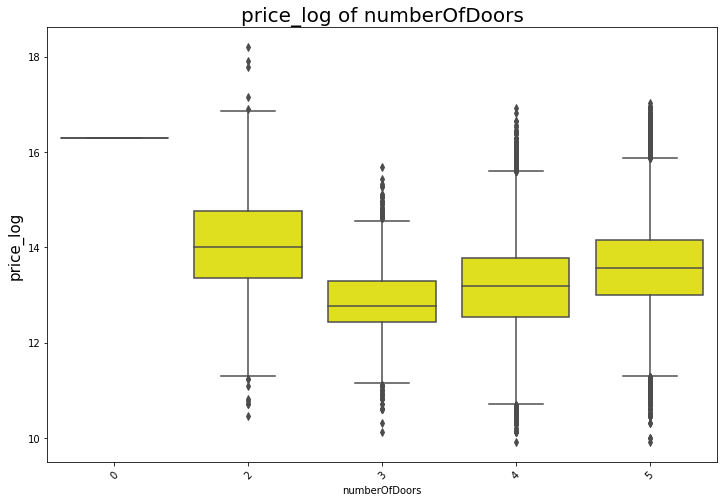

In [103]:
# Интересно, есть ли зависимость цены от количества дверей? 
show_boxplot(train21, 'numberOfDoors', 'price_log')

Выделяются раритетные и спортивные машины с 0 и 2 дверями - они дороже. остальные машины - чем больше дверей, тем дороже.

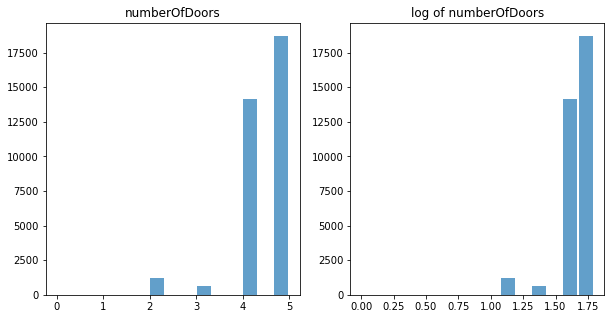

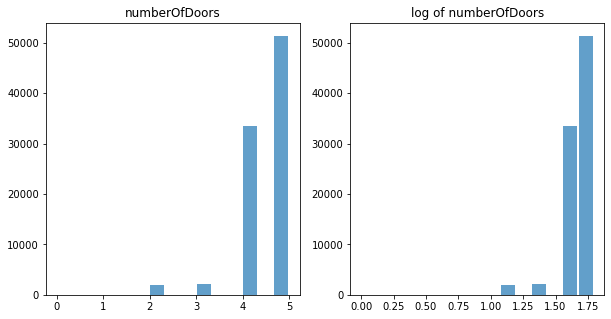

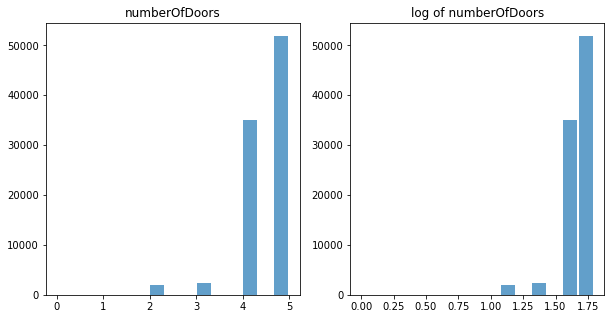

In [104]:
# Посмотрим на влияние логарифма
val_log_plot(test, 'numberOfDoors')
val_log_plot(train, 'numberOfDoors')
val_log_plot(train21, 'numberOfDoors')

Неудивительно, что логарифмирование такого простого признака с минимумом значений никак не повлияло на распределение. Логарифм добавлять не имеет смысла.

<a id='mileage'></a>
## mileage

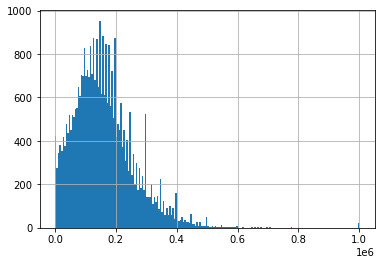

In [105]:
test.mileage.hist(bins=200)

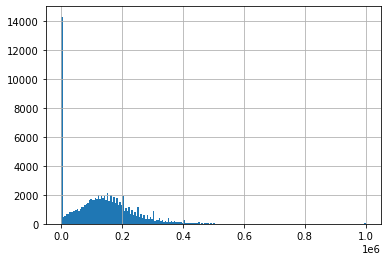

In [106]:
train.mileage.hist(bins=200)

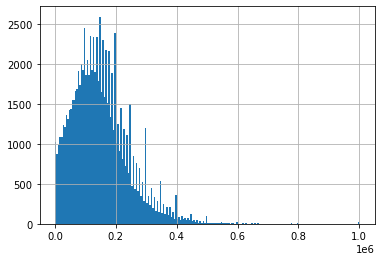

In [107]:
train21.mileage.hist(bins=200)

1. trai21 заранее скачивался только как набор машин с пробегом. Новые в него не включались. У него распределение совпадает с test.
2. В train сильно выделяются и выбиваются из нормального распределения машины с нулевым пробегом. Посмотрим, как распределятся пробеги у машин с пробегом.

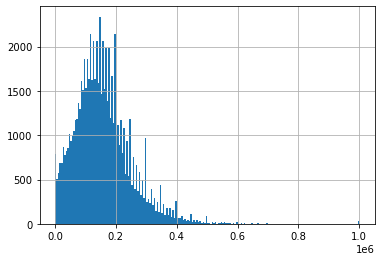

In [108]:
train[train.mileage>0].mileage.hist(bins=200)

Распределения подержанных машин практически идентичны в train и test.

In [109]:
# Посмотрим,сколько машин без пробега в train
train[train.mileage==0].shape

(13569, 33)

Не заполнено:  0
Минимум:  1
Максимум:  1000000
Медиана:  149779.5
Количество выбросов:  692
Нижняя граница выбросов:  -94607.5
Верхняя граница выбросов:  400764.5


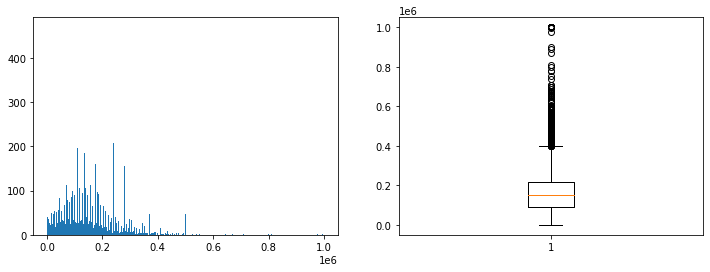

In [110]:
# Проверим выбросы в test
d = show_info(test,'mileage')

Не заполнено:  0
Минимум:  0
Максимум:  1000000
Медиана:  130000.0
Количество выбросов:  1128
Нижняя граница выбросов:  -152500.0
Верхняя граница выбросов:  403500.0


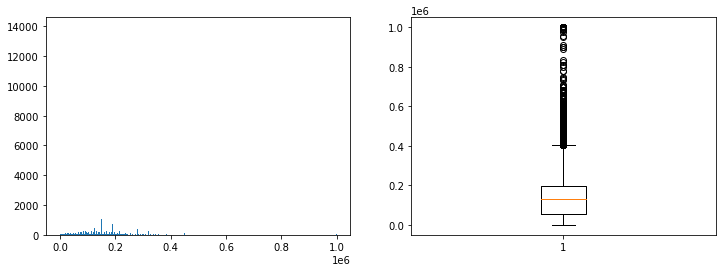

In [111]:
# Проверим выбросы в train
d = show_info(train,'mileage')

Не заполнено:  0
Минимум:  1.0
Максимум:  1000000.0
Медиана:  140000.0
Количество выбросов:  2285
Нижняя граница выбросов:  -88676.25
Верхняя граница выбросов:  373205.75


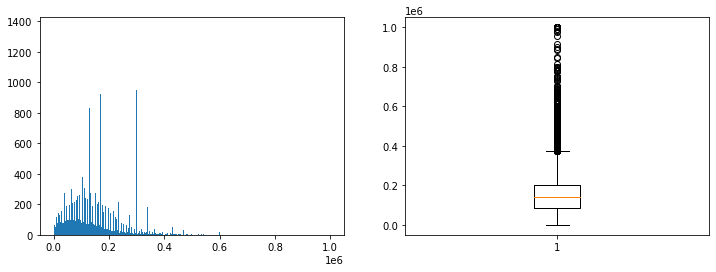

In [112]:
# Проверим выбросы в train21
d = show_info(train21,'mileage')

Пробег более, чем в примерно 400 000 тыс. км - это выбросы. В основном продают с пробегом до эого значения.

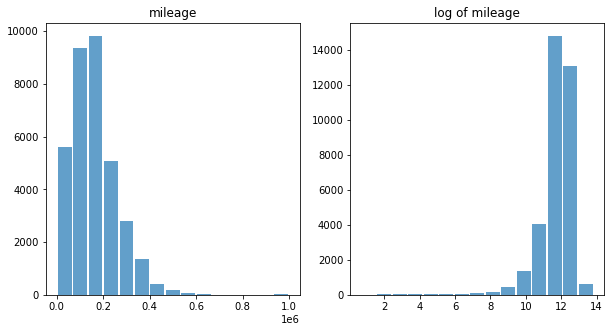

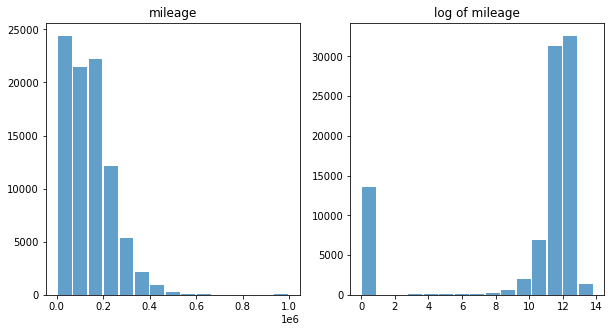

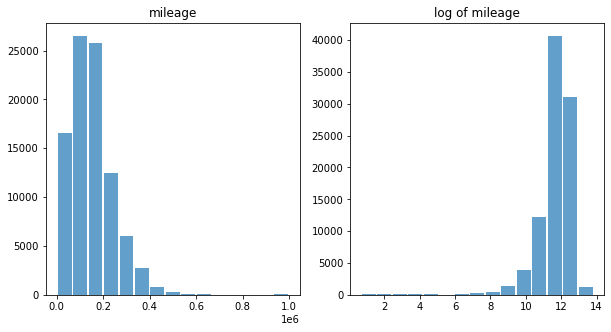

In [113]:
# Посмотрим на влияние логарифма
val_log_plot(test, 'mileage')
val_log_plot(train, 'mileage')
val_log_plot(train21, 'mileage')

Судя по графику логарифмирование ухудшает распределение. Тем не менее попробуем прологарифмировать, чтобы проверить, уменьшило ли оно выбросы.

Не заполнено:  0
Минимум:  0.0
Максимум:  13.815511557963774
Медиана:  11.775297421715827
Количество выбросов:  14745
Нижняя граница выбросов:  9.133124826700708
Верхняя граница выбросов:  13.980759965737864


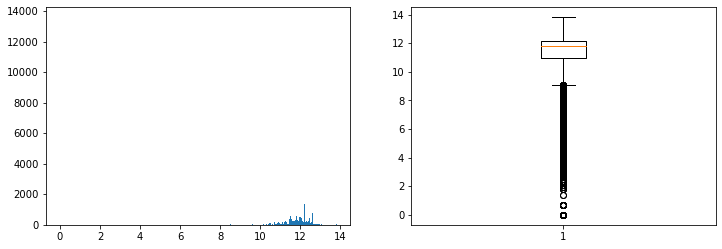

In [114]:
# Логарифмируем
train['mileage_log'] = np.log(train['mileage']+1)
d = show_info(train,'mileage_log')

Не заполнено:  0
Минимум:  0.0
Максимум:  13.815511557963774
Медиана:  11.775297421715827
Количество выбросов:  14745
Нижняя граница выбросов:  9.133124826700708
Верхняя граница выбросов:  13.980759965737864


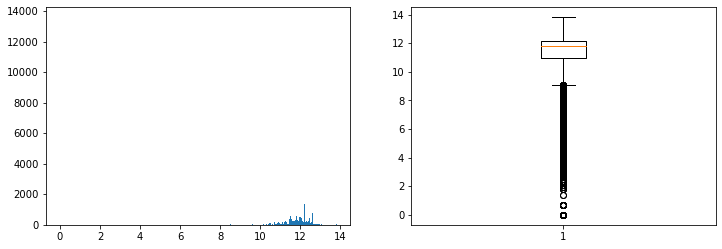

In [115]:
train21['mileage_log'] = np.log(train21['mileage']+1)
d = show_info(train,'mileage_log')

Не заполнено:  0
Минимум:  0.6931471805599453
Максимум:  13.815511557963774
Медиана:  11.91692616601575
Количество выбросов:  1684
Нижняя граница выбросов:  10.07034954072349
Верхняя граница выбросов:  13.628397958261774


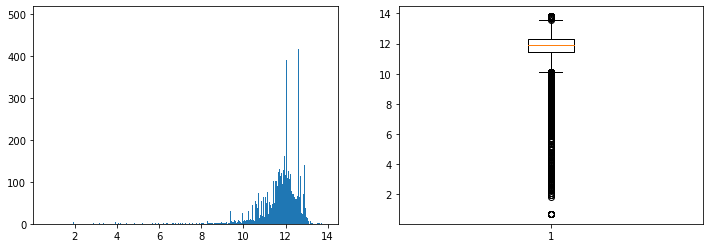

In [116]:
test['mileage_log'] = np.log(test['mileage']+1)
d = show_info(test,'mileage_log')

От логарифмирования количество выбросов не уменьшилось, а только увеличилось.

In [117]:
# Удалим логарифм пробега, он ухудшил ситуацию
train = train.drop(['mileage_log'], axis=1)
train21 = train21.drop(['mileage_log'], axis=1)
test = test.drop(['mileage_log'], axis=1)

In [118]:
# Пометим строки с выбросами специальным признаком
d = show_info(train,'mileage', show=False)
train['mileage_out'] = train['mileage'].apply(lambda x: 1 if x>d['lm2'] else 0)

d = show_info(test,'mileage', show=False)
test['mileage_out'] = test['mileage'].apply(lambda x: 1 if x>d['lm2'] else 0)

d = show_info(train21,'mileage', show=False)
train21['mileage_out'] = train21['mileage'].apply(lambda x: 1 if x>d['lm2'] else 0)

d = show_info(test21,'mileage', show=False)
test21['mileage_out'] = test21['mileage'].apply(lambda x: 1 if x>d['lm2'] else 0)

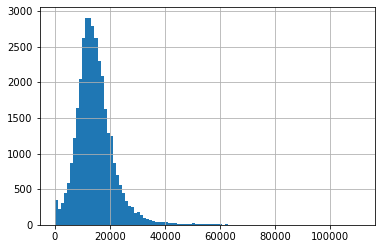

In [119]:
# Введем признак износа - сколько километров в год проезжала машина
test['milPerYear'] = test.apply(
    lambda row : 0 if row['productionDate']>2020 else row['mileage']/(2021-row['productionDate']), axis = 1)

test['milPerYear'].hist(bins=100)

In [120]:
test21['milPerYear'] = test21.apply(
    lambda row : 0 if row['productionDate']>2020 else row['mileage']/(2021-row['productionDate']), axis = 1)

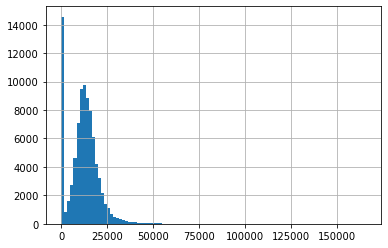

In [121]:
train['milPerYear'] = train.apply(
    lambda row : 0 if row['productionDate']>2020 else row['mileage']/(2021-row['productionDate']), axis = 1)

train['milPerYear'].hist(bins=100)

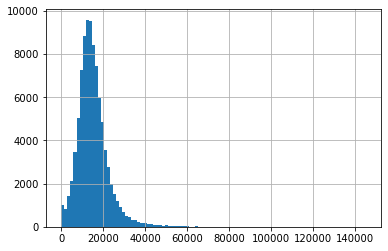

In [122]:
train21['milPerYear'] = train21.apply(
    lambda row : 0 if row['productionDate']>2020 else row['mileage']/(2021-row['productionDate']), axis = 1)

train21['milPerYear'].hist(bins=100)

Если исключить новые автомобили без пробега, то во всех наборах видно прекрасное нормальное распределение. Признак может быть очень значим.

In [123]:
# Добавим признак новой машины c минимальным пробегом
train['new_auto'] = train['mileage'].apply(lambda x: 1 if x<=100 else 0)
test['new_auto'] = test['mileage'].apply(lambda x: 1 if x<=100 else 0)
train21['new_auto'] = train21['mileage'].apply(lambda x: 1 if x<=100 else 0)
test21['new_auto'] = test21['mileage'].apply(lambda x: 1 if x<=100 else 0)

<a id='modelDate'></a>
## modelDate

In [124]:
print(test.modelDate.unique())
print(train.modelDate.unique())
print(train21.modelDate.unique())

[2013 2017 2008 2009 2016 2012 2015 2010 2006 2000 2007 1994 2004 1999
 2005 1976 2001 1969 1996 1998 1989 1934 2014 2011 2018 1986 1997 1990
 2019 2002 1991 1987 1980 1982 1938 1988 2003 1983 1978 1979 1984 1992
 1995 1993 1985 1974 1966 1977 1981 1972 1968 1975 1949 1937 1936 1973
 1959 1958 2020 1965 1971 1904 1963 1955 1951 1960]
[1990. 1982. 1988. 1976. 1983. 1979. 1986. 1991. 1978. 1987. 1992. 1938.
 2010. 2014. 2000. 2016. 2004. 2012. 2008. 1996. 2003. 2015. 2011. 2007.
 1999. 1994. 2009. 2018. 2001. 1997. 2006. 2019. 2013. 2017. 2002. 2005.
 1980. 1984. 1998. 1966. 1975. 1937. 1936. 1949. 2020. 1995. 1981. 1972.
 1977. 1989. 1968. 1985. 1958. 1971. 1956. 1955. 1970. 1963. 1973. 1964.
 1957. 1993. 1960. 1927. 1908. 1932. 1965. 1935. 1967. 1948. 1969. 1934.
 1974. 1950. 1961. 1904. 1959. 1951.]
[2015. 2007. 2012. 2014. 2010. 2016. 2018. 2011. 2013. 1990. 2004. 2008.
 2005. 2009. 2000. 2017. 1982. 2019. 1988. 1997. 2001. 1986. 1994. 2002.
 2006. 1991. 1998. 1999. 1938. 1976. 1983.

In [125]:
# Удалим единственную машину без года выпуска модели в train21 
print(train21[train21.modelDate.isnull()].shape[0])
train21 = train21[~train21.modelDate.isnull()]

1


In [126]:
# Приведем к целому типу
train['modelDate'] = train['modelDate'].values.astype('int64')
train21['modelDate'] = train21['modelDate'].values.astype('int64')
print(train.modelDate.unique())
print(train21.modelDate.unique())

[1990 1982 1988 1976 1983 1979 1986 1991 1978 1987 1992 1938 2010 2014
 2000 2016 2004 2012 2008 1996 2003 2015 2011 2007 1999 1994 2009 2018
 2001 1997 2006 2019 2013 2017 2002 2005 1980 1984 1998 1966 1975 1937
 1936 1949 2020 1995 1981 1972 1977 1989 1968 1985 1958 1971 1956 1955
 1970 1963 1973 1964 1957 1993 1960 1927 1908 1932 1965 1935 1967 1948
 1969 1934 1974 1950 1961 1904 1959 1951]
[2015 2007 2012 2014 2010 2016 2018 2011 2013 1990 2004 2008 2005 2009
 2000 2017 1982 2019 1988 1997 2001 1986 1994 2002 2006 1991 1998 1999
 1938 1976 1983 2003 1979 1996 1987 1978 1984 2020 1995 1977 1965 1968
 1957 1975 1937 1949 1936 1981 1989 1971 1970 1959 1972 1973 1963 1955
 1992 1993 1942 1964 1956 1927 1985 1908 1932 1958 1951 1904 1980 1935
 1953 1967 1952 1969 1960 1974 1950 1934]


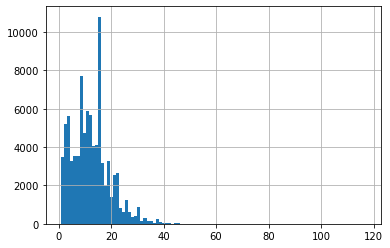

In [127]:
# Новый столбец с возрастом модели автомобиля
train['model_age'] = train['modelDate'].apply(lambda x: 2021-x)
train['model_age'].hist(bins=100)

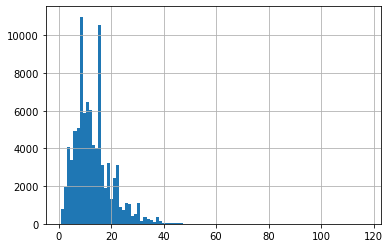

In [128]:
train21['model_age'] = train21['modelDate'].apply(lambda x: 2021-x)
train21['model_age'].hist(bins=100)

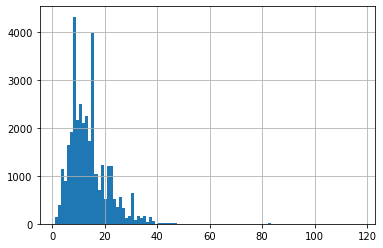

In [129]:
test['model_age'] = test['modelDate'].apply(lambda x: 2021-x)
test21['model_age'] = test21['modelDate'].apply(lambda x: 2021-x)
test['model_age'].hist(bins=100)

Распределения практически совпадают.

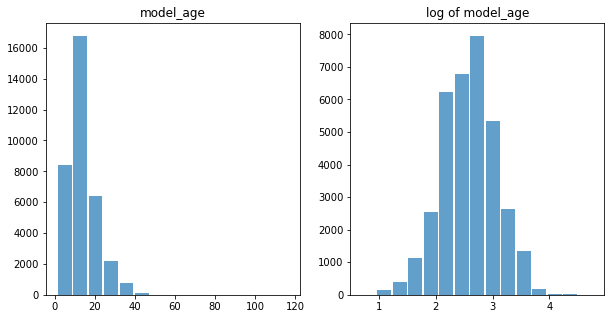

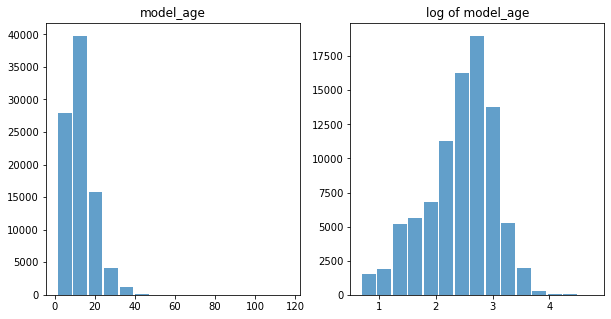

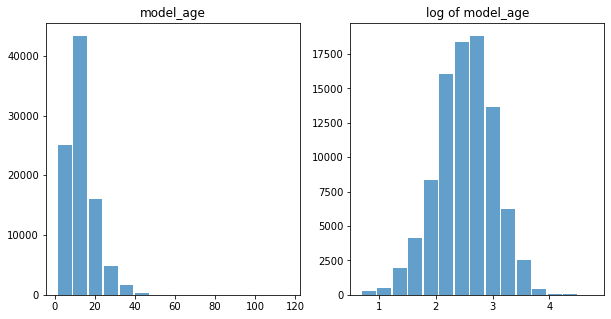

In [130]:
# Посмотрим на влияние логарифма
val_log_plot(test, 'model_age')
val_log_plot(train, 'model_age')
val_log_plot(train21, 'model_age')

Логарифмирование улучшило распределение.

In [131]:
# Новый столбец с логарифмом 
test['model_age_log'] = np.log(test['model_age'] + 1)
train['model_age_log'] = np.log(train['model_age'] + 1)
test21['model_age_log'] = np.log(test21['model_age'] + 1)
train21['model_age_log'] = np.log(train21['model_age'] + 1)

<a id='productionDate'></a>
## productionDate

In [132]:
print(test.productionDate.unique())
print(train.productionDate.unique())
print(train21.productionDate.unique())

[2014 2017 2012 2011 2019 2018 2010 2020 2016 2013 2006 2007 2015 2005
 2008 2009 1997 2004 2002 1987 2003 2001 1976 2000 1998 1995 1999 1993
 1939 1996 1984 1990 1991 1992 1989 1982 1985 1994 1938 1981 1988 1983
 1980 1986 1978 1970 1979 1977 1972 1975 1969 1950 1953 1949 1937 1959
 1968 1936 1904 1974 1967 1961 1960 1965 1963 1957 1952 1973 1948]
[1991 1986 1989 1993 1992 1994 1987 1988 1985 1983 1980 1984 1990 1981
 1995 1938 2014 2011 2013 2012 2016 2010 2002 2000 2001 2020 2008 2018
 2015 2019 2007 2003 2017 2006 2005 2004 2009 1997 1999 1998 1996 1982
 1972 1978 1937 1949 1948 1950 1953 1975 1969 1959 1974 1961 1955 1976
 1964 1971 1967 1957 1931 1927 1923 1924 1979 1970 1932 1939 1977 1951
 1973 1954 1960 1968 1904 1966 1965 1963 1936 1952]
[2018. 2010. 2015. 2011. 2017. 2019. 2013. 2012. 1993. 2014. 2007. 2020.
 2016. 2006. 2004. 2008. 2002. 2009. 1987. 1990. 2005. 2001. 2003. 1989.
 1996. 1991. 1988. 1992. 1999. 1994. 1938. 1981. 1984. 2000. 1995. 1986.
 1997. 1998. 1985. 1983

In [133]:
train21['productionDate'] = train21['productionDate'].values.astype('int64')

In [134]:
# Новый столбец с возрастом автомобиля
train['age'] = train['productionDate'].apply(lambda x: 2021-x)
train21['age'] = train21['productionDate'].apply(lambda x: 2021-x)
test['age'] = test['productionDate'].apply(lambda x: 2021-x)
test21['age'] = test21['productionDate'].apply(lambda x: 2021-x)

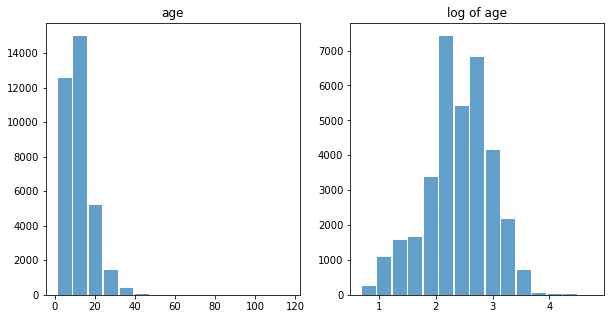

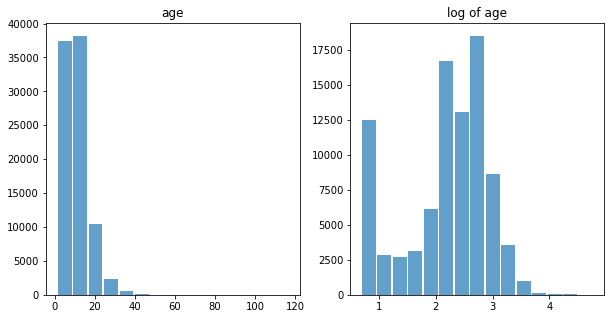

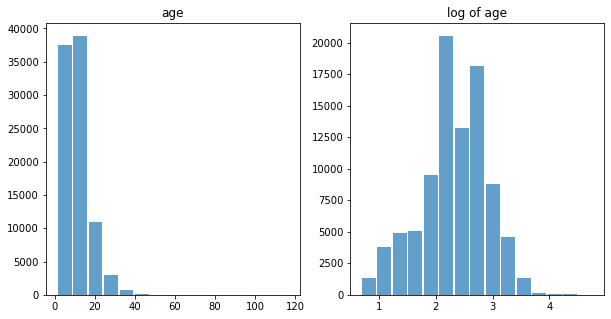

In [135]:
# Посмотрим на влияние логарифма
val_log_plot(test, 'age')
val_log_plot(train, 'age')
val_log_plot(train21, 'age')

1. Очень сильно выделяются в train новые автомобили без пробега. Таких нет в test, но очень много в train
2. Распределение улучшилось, имеет смысл взять логарифм 

In [136]:
# Новый столбец с логарифмом 
test['age_log'] = np.log(test['age'] + 1)
train['age_log'] = np.log(train['age'] + 1)
test21['age_log'] = np.log(test21['age'] + 1)
train21['age_log'] = np.log(train21['age'] + 1)

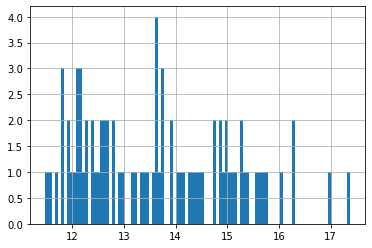

In [137]:
# Проверим распределение цен в зависимости от возраста
train.groupby('age').price_log.mean().hist(bins=100)

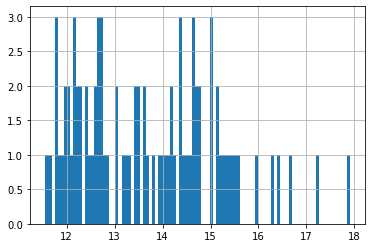

In [138]:
train21.groupby('age').price_log.mean().hist(bins=100)

Видно, что распределение как бы распадается на отдельные пики. Выделим каждый такой пик. Пики разные на разных тренировочных наборах.

In [139]:
# Добавим столбец с категорией возраста автомобиля
# bins = [0, 5, 13, 20, 50, 80, 118]
bins = [0, 5, 13, 16, 50, 80, 118]
labels = ['0','1','2', '3', '4', '5']
train['age_cat'] = pd.cut(train['age'], bins=bins, labels=labels)
train['age_cat'] = train['age_cat'].values.astype('int64')

test['age_cat'] = pd.cut(test['age'], bins=bins, labels=labels)
test['age_cat'] = test['age_cat'].values.astype('int64')


bins = [0, 5, 14, 17, 50, 80, 118]
labels = ['0','1','2', '3', '4', '5']
train21['age_cat'] = pd.cut(train21['age'], bins=bins, labels=labels)
train21['age_cat'] = train21['age_cat'].values.astype('int64')

test21['age_cat'] = pd.cut(test21['age'], bins=bins, labels=labels)
test21['age_cat'] = test21['age_cat'].values.astype('int64')

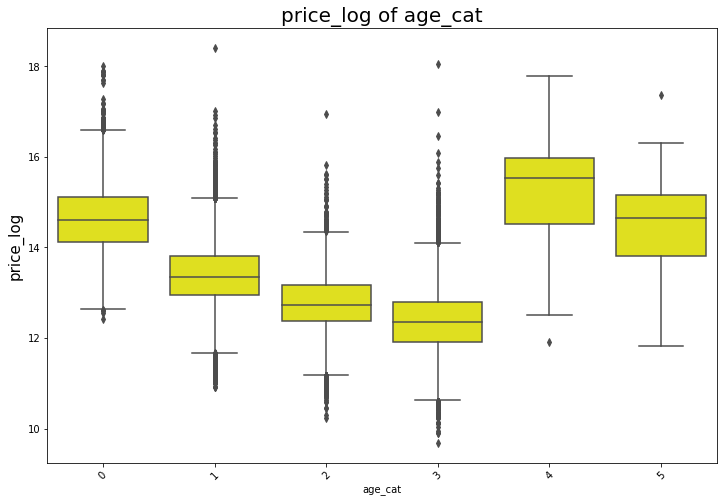

In [140]:
show_boxplot(train,'age_cat', 'price_log')

Раритетные машины стоят в среднем дороже, а не раритетные - чем старше, тем дешевле.

In [141]:
# Новый столбец с разницей между годом выпуска и годом модели
train['model_old'] = train['productionDate'] - train['modelDate']
train21['model_old'] = train21['productionDate'] - train21['modelDate']
test['model_old'] = test['productionDate'] - test['modelDate']
test21['model_old'] = test21['productionDate'] - test21['modelDate']
print(train['model_old'].unique())
print(train21['model_old'].unique())
print(test['model_old'].unique())

[ 1  4  3  2  5  0  7  6  8 10 11  9 12 -1 18 15 13 14 21 17 16 -2 -3 22
 35 46 42 34 24 29]
[ 3  1  0  4  2  5  6  7  8  9 12 10 11 17 14 20 13 23 25 18 16 15 19 24
 -2 -1 22 36 35 27 34 29 40]
[ 1  0  4  3  5  2  8  7  9  6 11 10 18 15 12 13 14 16 22 -1 35 27 46 34
 -2]


Есть несколько строк, где год модели моложе года выпуска. Оставим это как есть, потому что так есть и в test.
Разность в 15 лет и более тоже вызывает удивление.

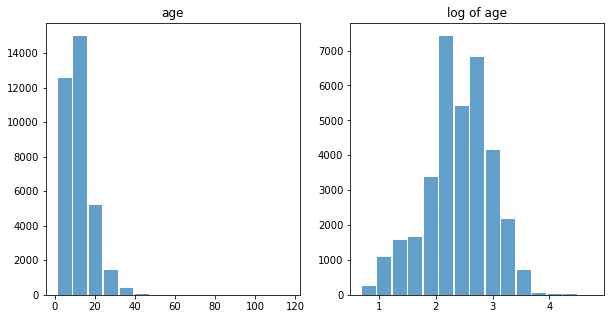

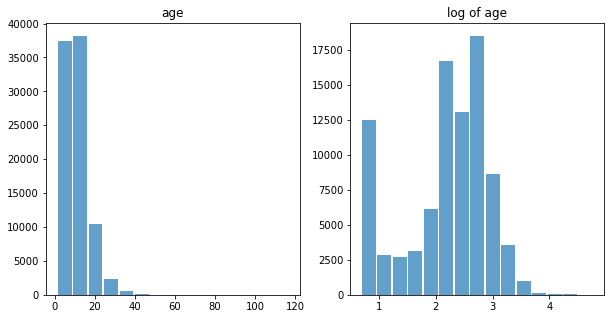

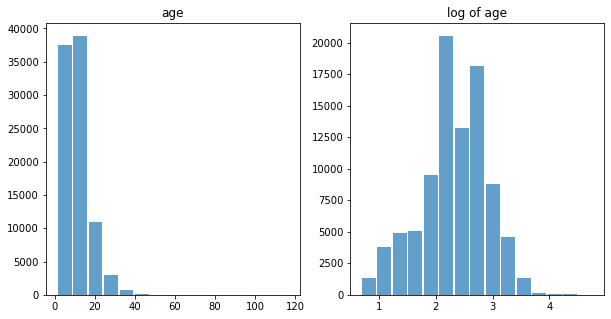

In [142]:
# Посмотрим на влияние логарифма на возраст автомобиля
val_log_plot(test, 'age')
val_log_plot(train, 'age')
val_log_plot(train21, 'age')

In [143]:
# Логарифмирование улучшило распределение. Создадим столбец с логарифмом.
test['age_log'] = np.log(test['age']+1)
train['age_log'] = np.log(train['age']+1)
test21['age_log'] = np.log(test21['age']+1)
train21['age_log'] = np.log(train21['age']+1)

<a id='Владельцы'></a>
## Владельцы

In [144]:
print(test.Владельцы.unique())
print(train.Владельцы.unique())
print(train21.Владельцы.unique())

['3 или более' '1\xa0владелец' '2\xa0владельца']
[ 3.  1.  2. nan]
['1 владелец' '3 или более' '2 владельца' nan]


In [145]:
# Посмотрим на машины без владельцев в новом наборе
train21[train21.Владельцы.isnull()].iloc[:, 8:26]

,enginePower,equipment_dict,fuelType,fuel_rate,mileage,modelDate,model_info,model_name,numberOfDoors,price,productionDate,super_gen,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод
728,360,"{""cruise-control"":true,""asr"":true,""tinted-glas...",бензин,21.7/9.5/13.9,160000.0,1999,"{'code':'S8','name':'S8','ru_name':'S8','morph...",S8,4,600000.0,2001,"{""id"":""4841650"",""name"":""I (D2) Рестайлинг"",""ru...",AT,EUROPEAN,NaN,11 лет и 1 месяц,Оригинал,полный
9300,75,{},бензин,8.2/7/7.6,200000.0,1994,"{'code':'NEXIA','name':'Nexia','ru_name':'Некс...",NEXIA,4,70000.0,1999,"{""id"":""3940451"",""name"":""I"",""ru_name"":""1"",""year...",MT,RUSSIAN,NaN,NaN,NaN,передний
11730,73,{},бензин,87.7 × 66,100000.0,1979,"{'code':'TAUNUS','name':'Taunus','ru_name':'Та...",TAUNUS,5,35000.0,1980,"{""id"":""20346573"",""name"":""III"",""ru_name"":""3"",""y...",MT,AMERICAN,NaN,NaN,Оригинал,задний
37934,116,{},бензин,10.6/6/7.7,220000.0,1999,"{'code':'406','name':'406','ru_name':'406','mo...",406,4,200000.0,2000,"{""id"":""4760476"",""name"":""I Рестайлинг"",""ru_name...",MT,EUROPEAN,NaN,NaN,Оригинал,передний
48755,152,{},бензин,9.9/5.7/7.2,107500.0,2011,"{'code':'PASSAT','name':'Passat','ru_name':'Па...",PASSAT,5,900000.0,2011,"{""id"":""7150225"",""name"":""B7"",""year_from"":2011,""...",RBT,EUROPEAN,NaN,9 лет и 5 месяцев,Оригинал,передний
49897,90,{},бензин,10.9/5.9/7.9,340000.0,1988,"{'code':'PASSAT','name':'Passat','ru_name':'Па...",PASSAT,5,70000.0,1993,"{""id"":""6391671"",""name"":""B3"",""year_from"":1988,""...",MT,EUROPEAN,NaN,NaN,Оригинал,передний
61125,150,{},дизель,9.1/5.3/6.7,240000.0,2002,"{'code':'E_KLASSE','name':'E-Класс','ru_name':...",E_KLASSE,4,488888.0,2004,"{""id"":""4601886"",""name"":""III (W211, S211)"",""ru_...",AT,EUROPEAN,NaN,NaN,Оригинал,задний


In [146]:
# Поставим примерное количество владельцев в зависимости от возраста машины в новом наборе, где машины явно имели владельцев
train21.Владельцы = train21.Владельцы.apply(set_None)
train21.Владельцы = train21.apply(lambda row: row['Владельцы'] if not(row['Владельцы'] is None) \
                                  else '1' if row['modelDate']>2010 \
                                  else '2' if row['modelDate']>1998 \
                                  else '3' , axis=1)

In [147]:
# Посмотрим на машины без владельцев в старом наборе
display(train[(train.Владельцы.isnull()) & (train.mileage>0)])

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,...,eD_log_out,mileage_out,milPerYear,new_auto,model_age,model_age_log,age,age_log,age_cat,model_old


В старом наборе отсутствующие владельцы лишь у новых, без пробега машин. Это значит, владельцев было 0.

In [148]:
# Причешем данные
train['Владельцы'] = train['Владельцы'].apply(set_None)
train['Владельцы'] = train['Владельцы'].apply(lambda x: '0.0' if x is None else str(x))

In [149]:
# Приведем к целым значениям
train['Владельцы'] = train['Владельцы'].apply(lambda x: 3 if '3' in x else 2 if '2' in x else 1 if '1' in x else 0)
test['Владельцы'] = test['Владельцы'].apply(lambda x: 3 if '3' in x else 2 if '2' in x else 1 if '1' in x else 0)
train21['Владельцы'] = train21['Владельцы'].apply(lambda x: 3 if '3' in x else 2 if '2' in x else 1 if '1' in x else 0)
test21['Владельцы'] = test21['Владельцы'].apply(lambda x: 3 if '3' in x else 2 if '2' in x else 1 if '1' in x else 0)

In [150]:
print(test.Владельцы.unique())
print(train.Владельцы.unique())
print(train21.Владельцы.unique())

[3 1 2]
[3 1 2 0]
[1 3 2]


<a id='ПТС'></a>
## ПТС

In [151]:
print(train.ПТС.unique())
print(train21.ПТС.unique())
print(test.ПТС.unique())

['ORIGINAL' 'DUPLICATE' nan]
['Оригинал' 'Дубликат' nan]
['Оригинал' 'Дубликат' nan]


In [152]:
display(test[test.ПТС.isnull()])
display(train[(train.ПТС.isnull()) & (train.mileage>0)])
display(train21[train21.ПТС.isnull()])

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,...,eD_log_out,mileage_out,milPerYear,new_auto,model_age,model_age_log,age,age_log,age_cat,model_old
10412,седан,bmw,синий,NaN,"Сделано большое Т.О. Фильтра масляный, воздушн...",2.5,170,NaN,бензин,276000,...,0,0,12545.454545,0,23,3.178054,22,3.135494,3,1


,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,...,eD_log_out,mileage_out,milPerYear,new_auto,model_age,model_age_log,age,age_log,age_cat,model_old


,acceleration,bodyType,brand,clearance_min,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,...,eD_log_out,mileage_out,milPerYear,new_auto,model_age,model_age_log,age,age_log,age_cat,model_old
9300,12.5,седан,daewoo,158.0,зелёный,"{""id"":""0""}",NaN,1.5,75,{},...,0,0,9090.909091,0,27,3.332205,22,3.135494,3,5
18224,98.5 × 81,внедорожник 5 дв.,jeep,220,красный,"{""id"":""0""}",Автомобиль 1993 года. Состояние хорошее. Порог...,2.5,130,"{""feedback-alarm"":true,""wheel-power"":true,""rem...",...,0,0,10250.000000,0,37,3.637586,28,3.367296,3,9
61092,11.5,купе,mercedes,150,фиолетовый,"{""id"":""0""}","Беспроблемный автомобиль, состояние кузова хор...",2.0,136,{},...,0,0,13541.666667,0,24,3.218876,24,3.218876,3,0
95501,14.8,хэтчбек 5 дв.,peugeot,110,серебристый,"{""id"":""0""}",NaN,1.4,75,"{""velvet-seats"":true,""remote-engine-start"":tru...",...,0,0,6500.000000,0,23,3.178054,16,2.833213,2,7
96370,14.1,универсал 5 дв.,opel,160.0,серебристый,"{""id"":""0""}",С продажей не тороплюсь . Возможен торг .,1.3,90,{},...,0,0,18214.285714,0,15,2.772589,14,2.708050,1,1


In [153]:
train[(train.ПТС.isnull()) & (train.mileage>0)]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleTransmission,engineDisplacement,...,eD_log_out,mileage_out,milPerYear,new_auto,model_age,model_age_log,age,age_log,age_cat,model_old


1. Без ПТС в train только новые машины 
2. Без ПТС в test b train21 немного каких-то старых машин

In [154]:
# Пропуск в test и train21 заполним самым частым значение = 'Оригинал'
test['ПТС'] = test['ПТС'].fillna('Оригинал')
test21['ПТС'] = test21['ПТС'].fillna('Оригинал')
train21['ПТС'] = train21['ПТС'].fillna('Оригинал')

# Пропуск в train заполним как 'NEW', поскольку ПТС новым машинам еще не выдали
train['ПТС'] = train['ПТС'].fillna('NEW')

In [155]:
pts_dict={'Оригинал': 'ORIGINAL', 'Дубликат': 'DUPLICATE'}
test['ПТС'] = test['ПТС'].map(pts_dict)
test21['ПТС'] = test21['ПТС'].map(pts_dict)
train21['ПТС'] = train21['ПТС'].map(pts_dict)

<a id='Руль'></a>
## Руль

In [156]:
print(train.Руль.unique())
print(train21.Руль.unique())
print(test.Руль.unique())

['LEFT' 'RIGHT']
['Левый' 'Правый']
['Левый' 'Правый']


In [157]:
rule_dict1={'LEFT': 0, 'RIGHT': 1}
rule_dict2={'Левый': 0, 'Правый': 1}
test['Руль'] = test['Руль'].map(rule_dict2)
test21['Руль'] = test21['Руль'].map(rule_dict2)
train21['Руль'] = train21['Руль'].map(rule_dict2)
train['Руль'] = train['Руль'].map(rule_dict1)

<a id='Владение'></a>
## Владение

In [158]:
print(train.Владение.unique()[100:120])
print(train21.Владение.unique()[:10])
print(test.Владение.unique()[:10])

["{'year': 2014, 'month': 2}" "{'year': 2012, 'month': 7}"
 "{'year': 2013, 'month': 10}" "{'year': 2012, 'month': 5}"
 "{'year': 2020, 'month': 9}" "{'year': 2013, 'month': 11}"
 "{'year': 2014, 'month': 7}" "{'year': 2005, 'month': 7}"
 "{'year': 2006, 'month': 6}" "{'year': 2015, 'month': 1}"
 "{'year': 2016, 'month': 2}" "{'year': 2011, 'month': 7}"
 "{'year': 2013, 'month': 9}" "{'year': 2014, 'month': 11}"
 "{'year': 2011, 'month': 9}" "{'year': 2015, 'month': 5}"
 "{'year': 2012, 'month': 12}" "{'year': 2015, 'month': 9}"
 "{'year': 2011, 'month': 6}" "{'year': 2002, 'month': 10}"]
['3 года' nan '10 лет и 5 месяцев' '1 год и 6 месяцев' '2 года и 3 месяца'
 '4 года и 6 месяцев' '3 года и 1 месяц' '6 месяцев' '7 лет и 2 месяца'
 '5 месяцев']
[nan '3 года и 2 месяца' '11 месяцев' '4 года и 1 месяц'
 '2 года и 4 месяца' '1 месяц' '3 года и 10 месяцев' '2 года и 6 месяцев'
 '6 лет и 4 месяца' '2 месяца']


Пропусков очень много.

In [159]:
# Пример: Владение идет 1 год 10 месяцев.
# 1 год владения = 12 месяцев
# 12+10=22. Реально владел 22 месяцев на сентябрь 2020
# 22+5=27. Реально владел 27 месяцев на февраль 2021
def get_months_y(x):
    if type(x) != list:
        return x
    elif len(x) == 2:
        return int(x[0])*12 + int(x[1]) + 5
    else:
        return int(x[0]) + 5

# Пример: Владение идет с 11 месяца 2019.
# 2020-2019 = 1 год владения = 12 месяцев
# 12+9-11=10. Реально владел 10 месяцев на сентябрь 2020
# 10+5=15. Реально владел 15 месяцев на февраль 2021
def get_months_d(x):
    if type(x) != list:
        return x
    else:
        return (2020-int(x[0]))*12 + 9 - int(x[1]) + 5 

In [160]:
# Получим список составных частей срока владения
train['own_num'] = train['Владение'].apply(lambda x: x if pd.isna(x) else re.findall(r'\d+', x))
test['own_num'] = test['Владение'].apply(lambda x: x if pd.isna(x) else re.findall(r'\d+', x))
train21['own_num'] = train21['Владение'].apply(lambda x: x if pd.isna(x) else re.findall(r'\d+', x))
test21['own_num'] = test21['Владение'].apply(lambda x: x if pd.isna(x) else re.findall(r'\d+', x))

In [161]:
# Превратим этот список в количество месяцев
train['own_num'] = train['own_num'].apply(get_months_d)
test['own_num'] = test['own_num'].apply(get_months_y)
train21['own_num'] = train21['own_num'].apply(get_months_y)
test21['own_num'] = test21['own_num'].apply(get_months_y)

In [162]:
# Отметим машины, у которых владение не указано
train['own_null'] = train['own_num'].apply(lambda x: 0 if x>0 else 1)
test['own_null'] = test['own_num'].apply(lambda x: 0 if x>0 else 1)
train21['own_null'] = train21['own_num'].apply(lambda x: 0 if x>0 else 1)
test21['own_null'] = test21['own_num'].apply(lambda x: 0 if x>0 else 1)

In [163]:
# Заполним пропуски значением в зависмости от возраста. Считаем, что в среднем владеют 5 лет=60 месяцев.
# Если возраст машины менее 5 лет, то напишем возраст машины. Иначе поставим 5 лет.
# Можно также пойти от возраста автомобиля и количества его владельцев - поделить возраст на владельцев. Непонятно, что лучше.
train21.own_num = train21.apply(lambda row: row['own_num'] if not pd.isna(row['own_num']) \
                                  else row['age']*12 if row['age']<5 \
                                  else 60, axis=1)
train.own_num = train.apply(lambda row: row['own_num'] if not pd.isna(row['own_num']) \
                                  else row['age']*12 if row['age']<5 \
                                  else 60, axis=1)
test21.own_num = test21.apply(lambda row: row['own_num'] if not pd.isna(row['own_num']) \
                                  else row['age']*12 if row['age']<5 \
                                  else 60, axis=1)
test.own_num = test.apply(lambda row: row['own_num'] if not pd.isna(row['own_num']) \
                                  else row['age']*12 if row['age']<5 \
                                  else 60, axis=1)

<a id='description'></a>
## description

Обработку полей с описанием и комплектацией будем делать по-разному для старого и нового наборов, поскольку сведения о комплектации в старом наборе отсутствуют. Их в старом наборе попробуем вытащить из описания. Для нового же набора, кроме описания, будем дополнительно обращаться непосредственно к столбцам с комплектацией.

In [164]:
# Сделаем первичную обработку
test['description'] = test['description'].apply(set_None)
test['description'] = test['description'].apply(set_lower)

train['description'] = train['description'].apply(set_None)
train['description'] = train['description'].apply(set_lower)

test21['description'] = test21['description'].apply(set_None)
test21['description'] = test21['description'].apply(set_lower)

train21['description'] = train21['description'].apply(set_None)
train21['description'] = train21['description'].apply(set_lower)

In [165]:
# Заменим None на пустую строку
test['description'] = test['description'].apply(lambda x: '' if x is None else x)
train['description'] = train['description'].apply(lambda x: '' if x is None else x)
test21['description'] = test21['description'].apply(lambda x: '' if x is None else x)
train21['description'] = train21['description'].apply(lambda x: '' if x is None else x)

In [166]:
# Заменим перевод строки '\n' и знаки препинания на ' '
intab = ".,;:!?-•–ё" 
outtab = "         е" 
trantab = str.maketrans(intab, outtab)
test['description'] = test['description'].apply(lambda x: x.replace('\n', ' '))
test['description'] = test['description'].apply(lambda x: x.translate(trantab))
test['description'] = test['description'].apply(lambda x: x.replace('\uf043\t', ' '))
test['description'] = test['description'].apply(lambda x: x.replace('\uf0fe\t', ' ').replace('  ', ' '))

In [167]:
intab = ".,;:!?-•–ё" 
outtab = "         е" 
trantab = str.maketrans(intab, outtab)
train['description'] = train['description'].apply(lambda x: x.replace('\n', ' '))
train['description'] = train['description'].apply(lambda x: x.translate(trantab))
train['description'] = train['description'].apply(lambda x: x.replace('\uf043\t', ' '))
train['description'] = train['description'].apply(lambda x: x.replace('\uf0fe\t', ' ').replace('  ', ' '))

In [168]:
test21['description'] = test21['description'].apply(lambda x: x.replace('\n', ' '))
test21['description'] = test21['description'].apply(lambda x: x.translate(trantab))
test21['description'] = test21['description'].apply(lambda x: x.replace('\uf043\t', ' '))
test21['description'] = test21['description'].apply(lambda x: x.replace('\uf0fe\t', ' ').replace('  ', ' '))

train21['description'] = train21['description'].apply(lambda x: x.replace('\n', ' '))
train21['description'] = train21['description'].apply(lambda x: x.translate(trantab))
train21['description'] = train21['description'].apply(lambda x: x.replace('\uf043\t', ' '))
train21['description'] = train21['description'].apply(lambda x: x.replace('\uf0fe\t', ' ').replace('  ', ' '))

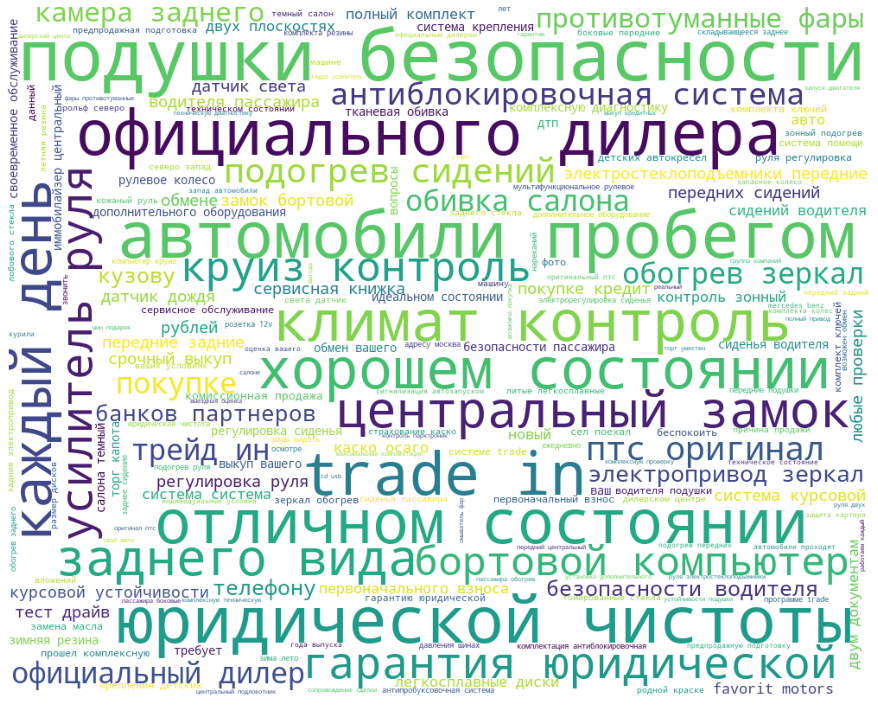

In [169]:
# Посмотрим на самые частые слова в объявлениях в train21. 
# Для train и test распределение примерно такое же. Ради быстроты проверять их не станем.
main_words = '' 
stopwords=nltk.corpus.stopwords.words('russian')
newStopWords = ['автомобиль','автомобилей', 'автомобиля', 'продаю', 'пробег', 'машина']
stopwords.extend(newStopWords)

wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=200,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(train21['description'].astype(str)))

                      
plt.figure(figsize = (12, 14), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

In [170]:
# На основании полученной картинки добавим признаки важных качеств
# Для test
test['exState'] = test.description.apply(lambda x: 1 if re.search(r'отличн.+состоян+',x) else 0)
test['goodState'] = test.description.apply(lambda x: 1 if re.search(r'хорош.+состоян+',x) else 0)
test['noSmoke'] = test.description.apply(lambda x: 1 if re.search('прокур'|'курил',x) else 0)
test['dent']= test.description.apply(lambda x: 1 if re.search('вмят'|'царап'|'трещ'|'тресн',x) else 0)
test['salon']= test.description.apply(lambda x: \
                                      1 if re.search('дилер'|'ликвидац'|'кредит'|'юридич'|'traide'|'трейд'|'официал',x) in x \
                                      else 0)
test['carter'] = test.description.apply(lambda x: 1 if re.search(r'защит.+картер+',x) else 0)

test['electro-window'] = test.description.apply(lambda x: 1 if 'электростеклоподъемник' in x else 0)
test['airbag'] = test.description.apply(lambda x: 1 if re.search(r'подушк', x) else 0)
test['wheel-power'] = test.description.apply(lambda x: 1 if re.search(r'усилител', x) and re.search(r'руля', x) else 0)
test['lock'] = test.description.apply(lambda x: 1 if re.search(r'центральн.+зам+',x) else 0)
test['help'] = test.description.apply(lambda x: 1 if re.search(r'систем.+помощ+',x) else 0)
test['climate'] = test.description.apply(lambda x: 1 if 'климат' in x else 0)
test['cruise'] = test.description.apply(lambda x: 1 if 'круиз' in x else 0)
test['computer'] = test.description.apply(lambda x: 1 if re.search(r'бортов.+компьютер+',x) else 0)
test['heat'] = test.description.apply(lambda x: 1 if 'подогрев' in x else 0)
test['electro-mirrors'] = test.description.apply(lambda x: 1 if 'электропривод зеркал' in x else 0)
test['ptf'] = test.description.apply(lambda x: 1 if 'противотуман' in x else 0)
test['abs'] = test.description.apply(lambda x: 1 if re.search('антиблокировочн'|'abs',x) else 0)
test['esp'] = test.description.apply(lambda x: 1 if re.search('курсовой устойчивости'|'esp',x) else 0)
test['condition'] = test.description.apply(lambda x: 1 if 'кондиционер' in x else 0)
test['immo'] = test.description.apply(lambda x: 1 if 'иммобил' in x else 0)
test['alarm'] = test.description.apply(lambda x: 1 if 'сигнализ' in x else 0)
test['navigation'] = test.description.apply(lambda x: 1 if 'навига' in x else 0)
test['park'] = test.description.apply(lambda x: 1 if 'парк' in x else 0)
test['audio'] = test.description.apply(lambda x: 1 if re.search('audio'|'аудио',x) else 0)
test['rain-sensor'] = test.description.apply(lambda x: 1 if re.search(r'датчик.+дождя+',x) else 0)
test['alloy-wheel-disks'] = test.description.apply(lambda x: 1 if re.search(r'легкосплавн',x) else 0)
test['camera'] = test.description.apply(lambda x: 1 if 'камера' in x else 0)
test['tyre-pressure'] = test.description.apply(lambda x: 1 if 'в шинах' in x else 0)
test['halogen'] = test.description.apply(lambda x: 1 if 'галоген' in x else 0)
test['dark'] = test.description.apply(lambda x: 1 if re.search(r'темн.+салон+',x) or re.search(r'черн.+салон+',x) else 0)
test['asr'] = test.description.apply(lambda x: 1 if re.search('антипробуксов'|'asr',x) else 0)

In [171]:
# Для train
train['exState'] = train.description.apply(lambda x: 1 if re.search(r'отличн.+состоян+',x) else 0)
train['goodState'] = train.description.apply(lambda x: 1 if re.search(r'хорош.+состоян+',x) else 0)
train['noSmoke'] = train.description.apply(lambda x: 1 if re.search('прокур'|'курил',x) else 0)
train['dent']= train.description.apply(lambda x: 1 if re.search('вмят'|'царап'|'трещ'|'тресн',x) else 0)
train['salon']= train.description.apply(lambda x: \
                                      1 if re.search('дилер'|'ликвидац'|'кредит'|'юридич'|'traide'|'трейд'|'официал',x) in x \
                                      else 0)
train['carter'] = train.description.apply(lambda x: 1 if re.search(r'защит.+картер+',x) else 0)

train['electro-window'] = train.description.apply(lambda x: 1 if 'электростеклоподъемник' in x else 0)
train['airbag'] = train.description.apply(lambda x: 1 if re.search(r'подушк', x) else 0)
train['wheel-power'] = train.description.apply(lambda x: 1 if re.search(r'усилител', x) and re.search(r'руля', x) else 0)
train['lock'] = train.description.apply(lambda x: 1 if re.search(r'центральн.+зам+',x) else 0)
train['help'] = train.description.apply(lambda x: 1 if re.search(r'систем.+помощ+',x) else 0)
train['climate'] = train.description.apply(lambda x: 1 if 'климат' in x else 0)
train['cruise'] = train.description.apply(lambda x: 1 if 'круиз' in x else 0)
train['computer'] = train.description.apply(lambda x: 1 if re.search(r'бортов.+компьютер+',x) else 0)
train['heat'] = train.description.apply(lambda x: 1 if 'подогрев' in x else 0)
train['electro-mirrors'] = train.description.apply(lambda x: 1 if 'электропривод зеркал' in x else 0)
train['ptf'] = train.description.apply(lambda x: 1 if 'противотуман' in x else 0)
train['abs'] = train.description.apply(lambda x: 1 if re.search('антиблокировочн'|'abs',x) else 0)
train['esp'] = train.description.apply(lambda x: 1 if re.search('курсовой устойчивости'|'esp',x) else 0)
train['condition'] = train.description.apply(lambda x: 1 if 'кондиционер' in x else 0)
train['immo'] = train.description.apply(lambda x: 1 if 'иммобил' in x else 0)
train['alarm'] = train.description.apply(lambda x: 1 if 'сигнализ' in x else 0)
train['navigation'] = train.description.apply(lambda x: 1 if 'навига' in x else 0)
train['park'] = train.description.apply(lambda x: 1 if 'парк' in x else 0)
train['audio'] = train.description.apply(lambda x: 1 if re.search('audio'|'аудио',x) else 0)
train['rain-sensor'] = train.description.apply(lambda x: 1 if re.search(r'датчик.+дождя+',x) else 0)
train['alloy-wheel-disks'] = train.description.apply(lambda x: 1 if re.search(r'легкосплавн',x) else 0)
train['camera'] = train.description.apply(lambda x: 1 if 'камера' in x else 0)
train['tyre-pressure'] = train.description.apply(lambda x: 1 if 'в шинах' in x else 0)
train['halogen'] = train.description.apply(lambda x: 1 if 'галоген' in x else 0)
train['dark'] = train.description.apply(lambda x: 1 if re.search(r'темн.+салон+',x) or re.search(r'черн.+салон+',x) else 0)
train['asr'] = train.description.apply(lambda x: 1 if re.search('антипробуксов'|'asr',x) else 0)

In [173]:
# Для нового набора
test21['exState'] = test21.description.apply(lambda x: 1 if re.search(r'отличн.+состоян+',x) else 0)
test21['goodState'] = test21.description.apply(lambda x: 1 if re.search(r'хорош.+состоян+',x) else 0)
test21['noSmoke'] = test21.description.apply(lambda x: 1 if re.search('прокур'|'курил',x) else 0)
test21['dent']= test21.description.apply(lambda x: 1 if re.search('вмят'|'царап'|'трещ'|'тресн',x) else 0)
test21['salon']= test21.description.apply(lambda x: \
                                      1 if re.search('дилер'|'ликвидац'|'кредит'|'юридич'|'traide'|'трейд'|'официал',x) in x \
                                      else 0)
test21['carter'] = test21.description.apply(lambda x: 1 if re.search(r'защит.+картер+',x) else 0)

test21['electro-window'] = test21.description.apply(lambda x: 1 if 'электростеклоподъемник' in x else 0)
test21['airbag'] = test21.description.apply(lambda x: 1 if re.search(r'подушк', x) else 0)
test21['wheel-power'] = test21.description.apply(lambda x: 1 if re.search(r'усилител', x) and re.search(r'руля', x) else 0)
test21['lock'] = test21.description.apply(lambda x: 1 if re.search(r'центральн.+зам+',x) else 0)
test21['help'] = test21.description.apply(lambda x: 1 if re.search(r'систем.+помощ+',x) else 0)
test21['climate'] = test21.description.apply(lambda x: 1 if 'климат' in x else 0)
test21['cruise'] = test21.description.apply(lambda x: 1 if 'круиз' in x else 0)
test21['computer'] = test21.description.apply(lambda x: 1 if re.search(r'бортов.+компьютер+',x) else 0)
test21['heat'] = test21.description.apply(lambda x: 1 if 'подогрев' in x else 0)
test21['electro-mirrors'] = test21.description.apply(lambda x: 1 if 'электропривод зеркал' in x else 0)
test21['ptf'] = test21.description.apply(lambda x: 1 if 'противотуман' in x else 0)
test21['abs'] = test21.description.apply(lambda x: 1 if re.search('антиблокировочн'|'abs',x) else 0)
test21['esp'] = test21.description.apply(lambda x: 1 if re.search('курсовой устойчивости'|'esp',x) else 0)
test21['condition'] = test21.description.apply(lambda x: 1 if 'кондиционер' in x else 0)
test21['immo'] = test21.description.apply(lambda x: 1 if 'иммобил' in x else 0)
test21['alarm'] = test21.description.apply(lambda x: 1 if 'сигнализ' in x else 0)
test21['navigation'] = test21.description.apply(lambda x: 1 if 'навига' in x else 0)
test21['park'] = test21.description.apply(lambda x: 1 if 'парк' in x else 0)
test21['audio'] = test21.description.apply(lambda x: 1 if re.search('audio'|'аудио',x) else 0)
test21['rain-sensor'] = test21.description.apply(lambda x: 1 if re.search(r'датчик.+дождя+',x) else 0)
test21['alloy-wheel-disks'] = test21.description.apply(lambda x: 1 if re.search(r'легкосплавн',x) else 0)
test21['camera'] = test21.description.apply(lambda x: 1 if 'камера' in x else 0)
test21['tyre-pressure'] = test21.description.apply(lambda x: 1 if 'в шинах' in x else 0)
test21['halogen'] = test21.description.apply(lambda x: 1 if 'галоген' in x else 0)
test21['dark'] = test21.description.apply(lambda x: 1 if re.search(r'темн.+салон+',x) or re.search(r'черн.+салон+',x) else 0)
test21['asr'] = test21.description.apply(lambda x: 1 if re.search('антипробуксов'|'asr',x) else 0)

In [172]:
train21['exState'] = train21.description.apply(lambda x: 1 if re.search(r'отличн.+состоян+',x) else 0)
train21['goodState'] = train21.description.apply(lambda x: 1 if re.search(r'хорош.+состоян+',x) else 0)
train21['noSmoke'] = train21.description.apply(lambda x: 1 if re.search('прокур'|'курил',x) else 0)
train21['dent']= train21.description.apply(lambda x: 1 if re.search('вмят'|'царап'|'трещ'|'тресн',x) else 0)
train21['salon']= train21.description.apply(lambda x: \
                                      1 if re.search('дилер'|'ликвидац'|'кредит'|'юридич'|'traide'|'трейд'|'официал',x) in x \
                                      else 0)
train21['carter'] = train21.description.apply(lambda x: 1 if re.search(r'защит.+картер+',x) else 0)

train21['electro-window'] = train21.description.apply(lambda x: 1 if 'электростеклоподъемник' in x else 0)
train21['airbag'] = train21.description.apply(lambda x: 1 if re.search(r'подушк', x) else 0)
train21['wheel-power'] = train21.description.apply(lambda x: 1 if re.search(r'усилител', x) and re.search(r'руля', x) else 0)
train21['lock'] = train21.description.apply(lambda x: 1 if re.search(r'центральн.+зам+',x) else 0)
train21['help'] = train21.description.apply(lambda x: 1 if re.search(r'систем.+помощ+',x) else 0)
train21['climate'] = train21.description.apply(lambda x: 1 if 'климат' in x else 0)
train21['cruise'] = train21.description.apply(lambda x: 1 if 'круиз' in x else 0)
train21['computer'] = train21.description.apply(lambda x: 1 if re.search(r'бортов.+компьютер+',x) else 0)
train21['heat'] = train21.description.apply(lambda x: 1 if 'подогрев' in x else 0)
train21['electro-mirrors'] = train21.description.apply(lambda x: 1 if 'электропривод зеркал' in x else 0)
train21['ptf'] = train21.description.apply(lambda x: 1 if 'противотуман' in x else 0)
train21['abs'] = train21.description.apply(lambda x: 1 if re.search('антиблокировочн'|'abs',x) else 0)
train21['esp'] = train21.description.apply(lambda x: 1 if re.search('курсовой устойчивости'|'esp',x) else 0)
train21['condition'] = train21.description.apply(lambda x: 1 if 'кондиционер' in x else 0)
train21['immo'] = train21.description.apply(lambda x: 1 if 'иммобил' in x else 0)
train21['alarm'] = train21.description.apply(lambda x: 1 if 'сигнализ' in x else 0)
train21['navigation'] = train21.description.apply(lambda x: 1 if 'навига' in x else 0)
train21['park'] = train21.description.apply(lambda x: 1 if 'парк' in x else 0)
train21['audio'] = train21.description.apply(lambda x: 1 if re.search('audio'|'аудио',x) else 0)
train21['rain-sensor'] = train21.description.apply(lambda x: 1 if re.search(r'датчик.+дождя+',x) else 0)
train21['alloy-wheel-disks'] = train21.description.apply(lambda x: 1 if re.search(r'легкосплавн',x) else 0)
train21['camera'] = train21.description.apply(lambda x: 1 if 'камера' in x else 0)
train21['tyre-pressure'] = train21.description.apply(lambda x: 1 if 'в шинах' in x else 0)
train21['halogen'] = train21.description.apply(lambda x: 1 if 'галоген' in x else 0)
train21['dark'] = train21.description.apply(lambda x: 1 if re.search(r'темн.+салон+',x) or re.search(r'черн.+салон+',x) else 0)
train21['asr'] = train21.description.apply(lambda x: 1 if re.search('антипробуксов'|'asr',x) else 0)

In [174]:
# Для всех наборов добавим столбец с длиной описания
test['desc_len'] = test.description.apply(lambda x: 0 if pd.isna(x) else len(x))
train['desc_len'] = train.description.apply(lambda x: 0 if pd.isna(x) else len(x))
test21['desc_len'] = test21.description.apply(lambda x: 0 if pd.isna(x) else len(x))
train21['desc_len'] = train21.description.apply(lambda x: 0 if pd.isna(x) else len(x))

In [175]:
# Построим разреженные матрицы слов и создадим новые признаки: 
#   среднее значение (наполненность матрицы) и количество существенных слов
vectorizer = CountVectorizer(stop_words=stopwords)

text_feat = vectorizer.fit_transform(train['description'])
train['desc_mean'] = text_feat.mean(axis=1)*1000
train['desc_sum'] = text_feat.sum(axis=1)

text_feat = vectorizer.fit_transform(test['description'])
test['desc_mean'] = text_feat.mean(axis=1)
test['desc_sum'] = text_feat.sum(axis=1)

text_feat = vectorizer.fit_transform(train21['description'])
train21['desc_mean'] = text_feat.mean(axis=1)*1000
train21['desc_sum'] = text_feat.sum(axis=1)

text_feat = vectorizer.fit_transform(test21['description'])
test21['desc_mean'] = text_feat.mean(axis=1)
test21['desc_sum'] = text_feat.sum(axis=1)

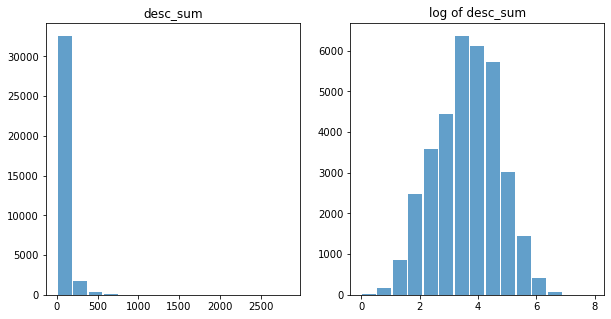

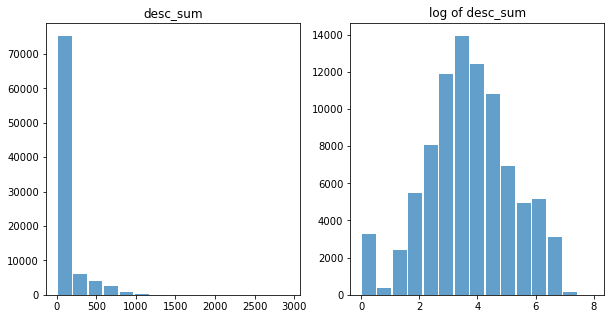

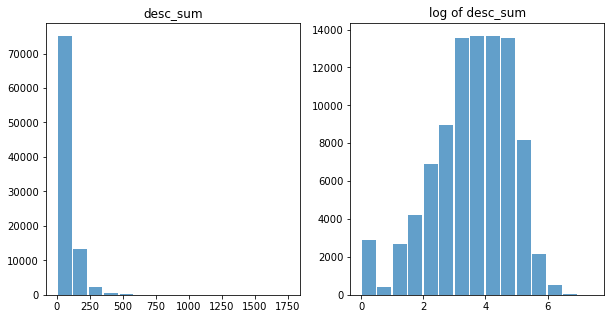

In [176]:
# Посмотрим на влияние логарифма на количество слов в описании
val_log_plot(test, 'desc_sum')
val_log_plot(train, 'desc_sum')
val_log_plot(train21, 'desc_sum')

In [177]:
# Распределение улучшилось. Добавим столбец с логарифмом.
test['desc_sum_log'] = np.log(test['desc_sum'] + 1)
train['desc_sum_log'] = np.log(train['desc_sum'] + 1)
test21['desc_sum_log'] = np.log(test21['desc_sum'] + 1)
train21['desc_sum_log'] = np.log(train21['desc_sum'] + 1)

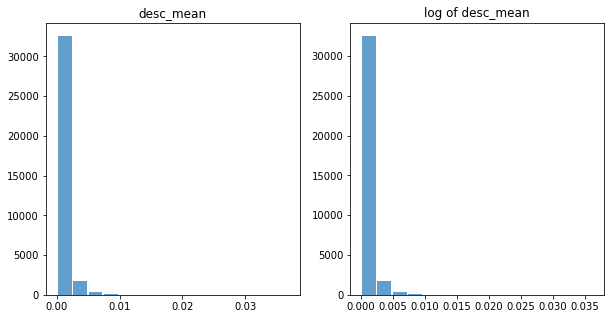

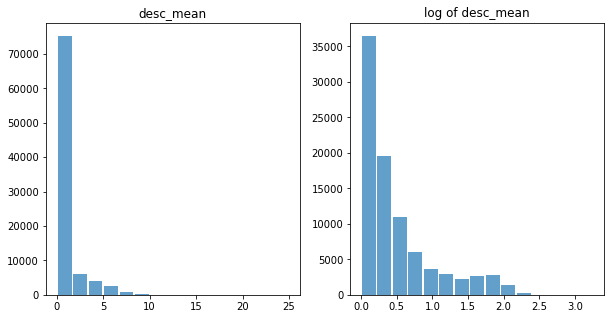

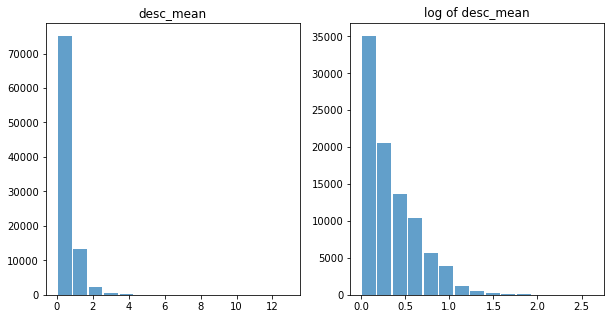

In [178]:
# Посмотрим на влияние логарифма на разреженость матрицы слов в описании
val_log_plot(test, 'desc_mean')
val_log_plot(train, 'desc_mean')
val_log_plot(train21, 'desc_mean')

In [179]:
# Распределение немного улучшилось. Добавим столбец с логарифмом.
test['desc_mean_log'] = np.log(test['desc_mean'] + 1)
train['desc_mean_log'] = np.log(train['desc_mean'] + 1)
test21['desc_mean_log'] = np.log(test21['desc_mean'] + 1)
train21['desc_mean_log'] = np.log(train21['desc_mean'] + 1)

<a id='equip'></a>
## comlectation & equipment

In [180]:
# Посмотрим, что в словаре с комплектацией
display(test.complectation_dict.head())
display(train.complectation_dict.head())
display(train21.complectation_dict.head())

0                                                  NaN
1                                                  NaN
2    {"id":"20026336","name":"Ambition","available_...
3    {"id":"20803582","name":"Ambition","available_...
4                                                  NaN
Name: complectation_dict, dtype: object

0    {'id': '0'}
1    {'id': '0'}
2    {'id': '0'}
3    {'id': '0'}
4    {'id': '0'}
Name: complectation_dict, dtype: object

0                                           {"id":"0"}
1    {"id":"3913761","name":"Базовая","available_op...
2                                           {"id":"0"}
3                                           {"id":"0"}
4    {"id":"20940975","name":"Sport","available_opt...
Name: complectation_dict, dtype: object

In [181]:
# test.complectation_dict = test.complectation_dict.apply(lambda x: x if pd.isna(x) else json.loads(x)['available_options'])
# Не сработало, ошибка EOF

In [182]:
# Немного причешем данные с комплектацией
test.complectation_dict = test.complectation_dict.apply(set_None)
test.complectation_dict_y = test.complectation_dict_y.apply(set_None)
test21.complectation_dict = test21.complectation_dict.apply(set_None)
test21.complectation_dict_y = test21.complectation_dict_y.apply(set_None)

train.complectation_dict = train.complectation_dict.apply(set_None)
train21.complectation_dict = train21.complectation_dict.apply(set_None)

# Заменим пропуски примитивным словарем
test.complectation_dict = test.complectation_dict.apply(lambda x: "{'id': '0'}" if x is None else x)
test.complectation_dict_y = test.complectation_dict_y.apply(lambda x: "{'id': '0'}" if x is None else x)
test21.complectation_dict = test21.complectation_dict.apply(lambda x: "{'id': '0'}" if x is None else x)
test21.complectation_dict_y = test21.complectation_dict_y.apply(lambda x: "{'id': '0'}" if x is None else x)
train21.complectation_dict = train21.complectation_dict.apply(lambda x: "{'id': '0'}" if x is None else x)

In [183]:
# Проверим количество пропусков
temp = train[train.complectation_dict=="{'id': '0'}"]
len(temp)

58840

Пустых значений много, больше половины, но мы все равно пороемся в данных.

In [184]:
# Заменим строку с комплектацией списком оборудования
train.complectation_dict = train.complectation_dict.apply(get_complect)
train21.complectation_dict = train21.complectation_dict.apply(get_complect)

In [185]:
# Получим все возможные опции в автомобиле из столбца с комплектацией
# set_complect_train = set(list(train.complectation_dict.explode()))
# print(set_complect_train)

In [186]:
# То же самое сделаем с test
test.complectation_dict = test.complectation_dict.apply(get_complect)
test.complectation_dict_y = test.complectation_dict_y.apply(get_complect)
test21.complectation_dict = test21.complectation_dict.apply(get_complect)
test21.complectation_dict_y = test21.complectation_dict_y.apply(get_complect)

In [187]:
# Посмотрим, что в словаре с оборудованием
display(test.equipment_dict.head())
display(train21.equipment_dict.head())

0    {"engine-proof":true,"tinted-glass":true,"airb...
1    {"cruise-control":true,"asr":true,"esp":true,"...
2    {"cruise-control":true,"tinted-glass":true,"es...
3    {"cruise-control":true,"roller-blind-for-rear-...
4    {"cruise-control":true,"asr":true,"esp":true,"...
Name: equipment_dict, dtype: object

0    {"cruise-control":true,"led-lights":true,"blue...
1    {"cruise-control":true,"tinted-glass":true,"es...
2    {"esp":true,"airbag-driver":true,"aux":true,"u...
3    {"cruise-control":true,"tinted-glass":true,"es...
4    {"tinted-glass":true,"esp":true,"sport-seats":...
Name: equipment_dict, dtype: object

In [188]:
# Немного причешем данные с оборудованием
test.equipment_dict = test.equipment_dict.apply(set_None)
test.equipment_dict_y = test.equipment_dict_y.apply(set_None)
test21.equipment_dict = test21.equipment_dict.apply(set_None)
test21.equipment_dict_y = test21.equipment_dict_y.apply(set_None)

In [189]:
# Сравним данные по оборудованию и комплектации 39
print(len(train21.complectation_dict.iloc[49]))
print(len(train21.equipment_dict.iloc[49]))
print(train21.complectation_dict.iloc[49])
print(train21.equipment_dict.iloc[49])

41
1012
['sport-seats', 'multi-wheel', 'airbag-passenger', 'lock', 'door-sill-panel', 'electro-mirrors', 'mirrors-heat', 'start-stop-function', 'computer', 'seat-transformation', 'wheel-power', 'airbag-side', 'abs', 'wheel-leather', 'climate-control-1', 'black-roof', 'esp', 'audiopreparation', 'electro-window-back', '18-inch-wheels', 'body-mouldings', 'combo-interior', 'condition', 'park-assist-r', 'airbag-driver', 'isofix', 'aux', 'electro-window-front', 'airbag-curtain', 'leather-gear-stick', 'ptf', 'tyre-pressure', 'audiosystem-cd', 'front-seats-heat', 'power-child-locks-rear-doors', 'bluetooth', 'wheel-configuration2', 'wheel-configuration1', 'immo', '12v-socket', 'third-rear-headrest']
{"tinted-glass":true,"esp":true,"sport-seats":true,"multi-wheel":true,"xenon":true,"spare-wheel":true,"airbag-passenger":true,"front-centre-armrest":true,"front-seat-support":true,"lock":true,"door-sill-panel":true,"drl":true,"electro-mirrors":true,"electro-window-back":true,"18-inch-wheels":true,"m

Похоже, что список оборудования шире комплектации и содержит ее полностью. В таком случае для нового тренировочного набора комплектация не нужна. Достаточно признака с оборудованием.

In [190]:
# print(len(test21.complectation_dict.iloc[4332]))
# print(len(test21.equipment_dict.iloc[4332]))
# print(len(test21.equipment_dict_y.iloc[4332]))
# print(test21.complectation_dict.iloc[4332])
# print(test21.equipment_dict.iloc[4332])
# print(test21.equipment_dict_y.iloc[4332])

In [191]:
intab = '{}:"' 
outtab = "    " 
trantab = str.maketrans(intab, outtab)
test.equipment_dict = test.equipment_dict.apply(lambda x: None if x is None \
                                                else x.translate(trantab).replace('true','').replace(' ','').split(','))
test.equipment_dict_y = test.equipment_dict_y.apply(lambda x: None if x is None \
                                                else x.translate(trantab).replace('true','').replace(' ','').split(','))
test21.equipment_dict = test21.equipment_dict.apply(lambda x: None if x is None \
                                                else x.translate(trantab).replace('true','').replace(' ','').split(','))
test21.equipment_dict_y = test21.equipment_dict_y.apply(lambda x: None if x is None \
                                                else x.translate(trantab).replace('true','').replace(' ','').split(','))
train21.equipment_dict = train21.equipment_dict.apply(lambda x: None if x is None \
                                                else x.translate(trantab).replace('true','').replace(' ','').split(','))

In [192]:
test.equipment_dict = test.equipment_dict.apply(lambda x: [] if x is None else x)
test.equipment_dict_y = test.equipment_dict_y.apply(lambda x: [] if x is None else x)
test21.equipment_dict = test21.equipment_dict.apply(lambda x: [] if x is None else x)
test21.equipment_dict_y = test21.equipment_dict_y.apply(lambda x: [] if x is None else x)
train21.equipment_dict = train21.equipment_dict.apply(lambda x: [] if x is None else x)

In [193]:
# Проверяем старый набор
display(test['equipment_dict'].head(2))
display(test['equipment_dict_y'].head(2))
display(test['complectation_dict'].head(2))
display(test['complectation_dict_y'].head(2))
display(train.complectation_dict.head(2))

0    [engine-proof, tinted-glass, airbag-driver, au...
1    [cruise-control, asr, esp, airbag-driver, isof...
Name: equipment_dict, dtype: object

0    [audiosystem-cd, aux, 12v-socket, condition, c...
1    [fabric-seats, dark-interior, alloy-wheel-disk...
Name: equipment_dict_y, dtype: object

0    []
1    []
Name: complectation_dict, dtype: object

0    [airbag-passenger, isofix-front, bas, lock, el...
1                                                   []
Name: complectation_dict_y, dtype: object

0    []
1    []
Name: complectation_dict, dtype: object

In [194]:
# Проверяем новый набор
display(test21['equipment_dict'].head(2))
display(test21['equipment_dict_y'].head(2))
display(test21['complectation_dict'].head(2))
display(test21['complectation_dict_y'].head(2))
display(train21.complectation_dict.head(2))
display(train21['equipment_dict'].head(2))

0    [engine-proof, tinted-glass, airbag-driver, au...
1    [cruise-control, asr, esp, airbag-driver, isof...
Name: equipment_dict, dtype: object

0    [audiosystem-cd, aux, 12v-socket, condition, c...
1    [fabric-seats, dark-interior, alloy-wheel-disk...
Name: equipment_dict_y, dtype: object

0    []
1    []
Name: complectation_dict, dtype: object

0    [airbag-passenger, isofix-front, bas, lock, el...
1                                                   []
Name: complectation_dict_y, dtype: object

0    []
1    []
Name: complectation_dict, dtype: object

0    [cruise-control, led-lights, bluetooth, progra...
1    [cruise-control, tinted-glass, esp, airbag-dri...
Name: equipment_dict, dtype: object

In [195]:
# Получим списки оборудования
# set_equipment_test = set(list(test.equipment_dict_y.explode()))
# print(set_equipment_test)

Видно, что поля с комплектацией и оборудованием сильно пересекаются.

In [196]:
# Проверим наличие важных и частых признаков среди списков оборудования для старого набора
eq_list = ['electro-window','airbag','wheel-power','lock','climate','cruise',
           'computer','heat','electro-mirrors','ptf','abs','esp','condition',
           'immo','alarm','navigation','park','audio','rain-sensor','alloy-wheel-disks',
           'camera','tyre-pressure','halogen','dark','asr']

for equ in eq_list:
    col = equ
    test[col] = test.apply(find_eq_test, axis=1)
    train[col] = train.apply(find_eq_train, axis=1)
    test21[col] = test21.apply(find_eq_test, axis=1)
    train21[col] = train21.apply(find_eq_train21, axis=1)

In [197]:
print(test['esp'].value_counts())
print(train['esp'].value_counts())

# Пропорция не совпадает. Для трейна маловато данных, но ничего с этим делать пока не будем

1    18946
0    15740
Name: esp, dtype: int64
0    71722
1    17243
Name: esp, dtype: int64


In [198]:
# Для новых наборов создадим столбцы на каждое оборудование, если они встречаются хотя бы в одном из полей:
# equipment_dict, equipment_dict_y, complectation_dict и complectation_dict_y

# Посмотрим на полный список оборудования и на самый частый
set_equipment = set(list(train21.equipment_dict.explode()))
print(set_equipment)

print(train21.equipment_dict.explode().value_counts()[:50].index)

{'', '3L5', 'seat-transformation', 'front-camera', 'black-roof', 'alloy-wheel-disks', 'passenger-seat-manual', 'light-cleaner', 'seats-heat', 'adj-pedals', 'U25', 'electro-mirrors', 'leather-gear-stick', 'usb', 'roller-blind-for-rear-window', 'hatch', 'alcantara', 'light-interior', 'turnbuckle', 'audiosystem-tv', 'windcleaner-heat', 'airbag-passenger', 'paint-metallic', 'glonass', 'laser-lights', '12v-socket', 'dha', 'seats-2', 'activ-suspension', 'wheel-memory', 'airbag-curtain', '881', 'wheel-configuration3', 'wheel-configuration1', 'start-button', 'seats-9', 'auto-mirrors', 'audiosystem', 'front-seat-support', 'entertainment-system-for-rear-seat-passengers', 'sport-suspension', '15-inch-wheels', 'front-centre-armrest', 'dark-interior', 'ptf', 'passenger-seat-updown', 'driver-seat-memory', 'door-sill-panel', 'roller-blinds-for-rear-side-windows', 'engine-proof', 'sport-seats', 'condition', 'audiopreparation', 'driver-seat-updown', 'driver-seat-electric', 'seats-4', 'windscreen-heat',

In [199]:
# Список самого частого оборудования плюс кое-какие фичи, часто упоминаемые в description
eq_list = ['lock', 'abs', 'electro-mirrors', 'computer', 'airbag-driver', 'immo',
       'electro-window-front', 'ptf', 'airbag-passenger', 'wheel-power',
       'front-seats-heat', 'aux', 'usb', 'electro-window-back',
       'wheel-leather', 'esp', 'multi-wheel', 'mirrors-heat',
       'wheel-configuration1', 'airbag-side', '12v-socket',
       'front-centre-armrest', 'tinted-glass', 'bluetooth', 'cruise-control',
       'audiosystem-cd', 'seat-transformation', '', 'light-sensor',
       'rain-sensor', 'fabric-seats', 'isofix', 'alarm', 'alloy-wheel-disks',
       'wheel-configuration2', 'dark-interior', 'park-assist-r',
       'leather-gear-stick', 'light-cleaner', 'auto-mirrors', 'engine-proof',
       'leather', 'airbag-curtain', 'automatic-lighting-control',
       'third-rear-headrest', 'asr',
       'ashtray-and-cigarette-lighter', 'condition', # Это первые 50 частых фич
       'tyre-pressure', 'climate-control',
       'navigation', 'audiosystem','front-camera','rear-camera', '360-camera',
       'park-assist-f','auto-park','parktronik','rear-seats-heat','seats-heat'] # Это фичи, часто упоминающиеся в description

for eq in eq_list: 
    train21[eq+'1'] = train21['equipment_dict'].astype(str).str.contains(eq).astype('int64')  +  \
                  train21['complectation_dict'].astype(str).str.contains(eq).astype('int64')
    train21[eq+'1'] = np.sign(train21[eq+'1'])

    test21[eq+'1'] = test21['equipment_dict'].astype(str).str.contains(eq).astype('int64')  +  \
                 test21['equipment_dict_y'].astype(str).str.contains(eq).astype('int64') +  \
                 test21['complectation_dict'].astype(str).str.contains(eq).astype('int64')  +  \
                 test21['complectation_dict_y'].astype(str).str.contains(eq).astype('int64')
    test21[eq+'1'] = np.sign(test21[eq+'1'])

In [200]:
train21.complectation_dict

0                                                        []
1                                                        []
2                                                        []
3                                                        []
4         [sport-seats, multi-wheel, xenon, airbag-passe...
                                ...                        
100644                                                   []
100645    [multi-wheel, auto-park, airbag-passenger, nav...
100646                                                   []
100647    [cruise-control, multi-wheel, airbag-passenger...
100648                                                   []
Name: complectation_dict, Length: 91357, dtype: object

In [201]:
# Создадим дополнительно столбцы с длиной списка в комплектации и оборудовании
test['compl_len'] = test.complectation_dict_y.apply(lambda x: len(x))
train['compl_len'] = train.complectation_dict.apply(lambda x: len(x))
test21['compl_len'] = test21.complectation_dict_y.apply(lambda x: len(x))
train21['compl_len'] = train21.complectation_dict.apply(lambda x: len(x))

test21['eq_len'] = test21.equipment_dict_y.apply(lambda x: len(x))
train21['eq_len'] = train21.equipment_dict.apply(lambda x: len(x))

<a id='name'></a>
## name

In [202]:
test['name'].unique()[200:220]

array(['3.0 AT (354 л.с.) 4WD', '2.5 AMT (400 л.с.) 4WD',
       '2.0 AT (252 л.с.) 4WD', '4.2 AMT (450 л.с.) 4WD',
       'V10 5.2 AMT (525 л.с.) 4WD', '2.5 AMT (367 л.с.) 4WD',
       '3.2 AT (265 л.с.) 4WD', '4.2 AT (450 л.с.) 4WD',
       '2.9 AT (450 л.с.) 4WD', '2.0 MT (101 л.с.)', '2.0 AMT (190 л.с.)',
       '2.0d AMT (177 л.с.) 4WD', '2.5 AMT (310 л.с.) 4WD',
       '2.0 CVT (200 л.с.)', '4.0 AT (435 л.с.) 4WD',
       '2.0d AMT (170 л.с.) 4WD', '1.8 AT (170 л.с.) 4WD',
       '2.0d MT (177 л.с.)', 'V10 plus 5.2 AMT (550 л.с.) 4WD',
       '5.0 AT (580 л.с.) 4WD'], dtype=object)

Данное поле содержит сведения, которые есть в других столбцах. Его уже использовали для извлечения объема двигателя. Если покопаться, то можно из него извлечь кое из каких строк признак гибрида (это уже есть тоже в признаке fuelType) и длинного кузова, а также экологического топлива. Но как показали эксперименты, эти признаки оказались абсолютно неважными для моделей, так как машин с ними было ничтожно мало. 

Удалим этом признак.

In [203]:
# Столбец удалим из старых наборов, а в новый набор его не скачивали.
train = train.drop(['name'], axis=1)
test = test.drop(['name'], axis=1)
test21 = test21.drop(['name'], axis=1)

<a id='super_gen'></a>
## super_gen

Данный признак отсутствует в тренировочном старом наборе, поэтому проработаем его только в новых наборах.

In [204]:
train21.iloc[48165].super_gen


'{"id":"20330779","name":"I","ru_name":"1","year_from":1993,"year_to":1997,"price_segment":"MEDIUM"}'

In [205]:
test21.iloc[18165].super_gen

'{"id":"20494448","name":"180","nameplate":"180 BlueEFFICIENCY","displacement":1796,"engine_type":"GASOLINE","gear_type":"REAR_DRIVE","transmission":"AUTOMATIC","power":156,"power_kvt":115,"human_name":"180 BlueEFFICIENCY 1.8 AT (156 л.с.)","acceleration":8.9,"clearance_min":150,"fuel_rate":6.9}'

В новой редакции Авто.ру в поле super_gen стала лежать информация другого типа (ну, или было неправильно распарсено). Но в этом поле кроме последних трех данных о времени разгона, клиренсе и расходе топлива, вся остальная информация повторяется по другим столбцам. Поэтому новые признаки для новго набора были скачаны отдельно со страницы информации о модели автомобиля.

In [206]:
test21.super_gen = test21.super_gen.apply(set_None)
test21.super_gen = test21.super_gen.fillna("{'acceleration': 0, 'clearance_min': 0, 'fuel_rate': 0}")
test21.super_gen = test21.super_gen.apply(lambda x: json.loads(x))

In [207]:
test21.super_gen[0]

{'id': '10373605',
 'displacement': 1197,
 'engine_type': 'GASOLINE',
 'gear_type': 'FORWARD_CONTROL',
 'transmission': 'ROBOT',
 'power': 105,
 'power_kvt': 77,
 'human_name': '1.2 AMT (105 л.с.)',
 'acceleration': 10.5,
 'clearance_min': 155,
 'fuel_rate': 5}

In [208]:
# Создаем столбцы с разгоном, клиренсом и расходом топлива
superg_columns = ['acceleration','clearance_min','fuel_rate']
for col in superg_columns:
    test21[col] = test21.super_gen.apply(lambda x: x.get(col) if isinstance(x, dict) else 0)
    test21[col] = test21[col].fillna(0)

In [209]:
# Пропуски заполняем средним значением по модели автомобиля
for col in superg_columns:
    match = dict(np.round(test21[test21[col]>0].groupby('model_name')[col].mean(),1))
    test21[col] = test21.apply(lambda row: match[row['model_name']] if row['model_name'] in match and row[col]==0 else row[col], axis = 1)
    
    # Остатки пропусков заменим средним по всем автомобилям
    # Закомментарено, потому что на этом месте все зависало намертво
    #mean_val = np.round(test21[test21[col]>0].mean(),1)
    #test21[col] = test21[col].apply(lambda x: mean_val if x==0 else x)
    

In [210]:
# Костыль против зависания
test21['acceleration'] = test21['acceleration'].apply(lambda x: 10 if x==0 else x)
test21['clearance_min'] = test21['clearance_min'].apply(lambda x: 180 if x==0 else x)
test21['fuel_rate'] = test21['fuel_rate'].apply(lambda x: 10 if x==0 else x)

In [211]:
# Посмотрим, что лежит в аналогичных столбцах в train21
train21.acceleration.value_counts()[0:10]

11.5    2842
10.5    2651
11.2    2642
12.5    2531
11.7    2343
11.6    1976
10.7    1857
10.3    1619
9.9     1566
11.9    1513
Name: acceleration, dtype: int64

In [212]:
# В некоторых случаях вместо числа лежит какой-то мусор. Заменим его на 0
train21.acceleration = train21.acceleration.apply(lambda x: '-' if '×' in str(x) else x)
train21.acceleration = train21.acceleration.apply(lambda x: 0 if '-' in str(x) else x)

In [213]:
train21.clearance_min = train21.clearance_min.apply(lambda x: '-' if '×' in str(x) else x)
train21.clearance_min = train21.clearance_min.apply(lambda x: 0 if '-' in str(x) else x)
train21.clearance_min = train21.clearance_min.apply(lambda x: str(x).replace(' ',''))

In [214]:
# У некоторых машин с пневматической подвеской 2 значения клиренса. Возьмем среднее между ними.
train21.clearance_min = train21.clearance_min.apply(lambda x: x if not (',' in str(x)) else (float(x.split(',')[1]) + float(x.split(',')[0]))/2)

In [215]:
train21.fuel_rate = train21.fuel_rate.apply(lambda x: '0/0/0' if not ('/' in str(x)) else x)
train21.fuel_rate = train21.fuel_rate.apply(lambda x: str(x).split('/')[2])

In [216]:
# Приведем к числам
train21.fuel_rate = train21.fuel_rate.astype('float64')
train21.acceleration = train21.acceleration.astype('float64')
train21.clearance_min = train21.clearance_min.astype('float64')

In [217]:
# Пропуски заполняем средним значением по модели автомобиля
for col in superg_columns:
    match = dict(np.round(train21[train21[col]>0].groupby('model_name')[col].mean(),1))
    train21[col] = train21.apply(lambda row: match[row['model_name']] if row['model_name'] in match and row[col]==0 else row[col], axis = 1)

In [218]:
# Снова костыль против зависания
train21['acceleration'] = train21['acceleration'].apply(lambda x: 10 if x==0 else x)
train21['clearance_min'] = train21['clearance_min'].apply(lambda x: 180 if x==0 else x)
train21['fuel_rate'] = train21['fuel_rate'].apply(lambda x: 10 if x==0 else x)

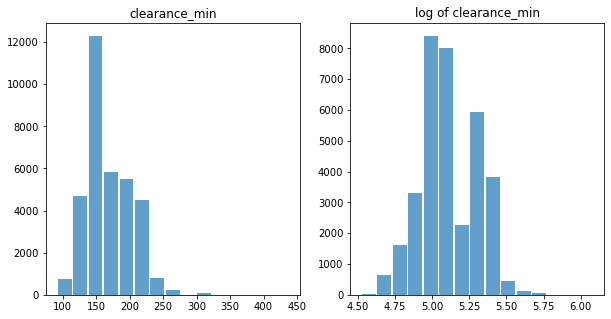

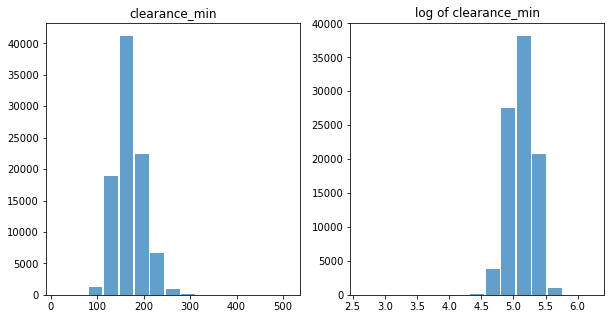

In [219]:
# Проверим влияние логарифма на новые столбцы
val_log_plot(test21, 'clearance_min')
val_log_plot(train21, 'clearance_min')

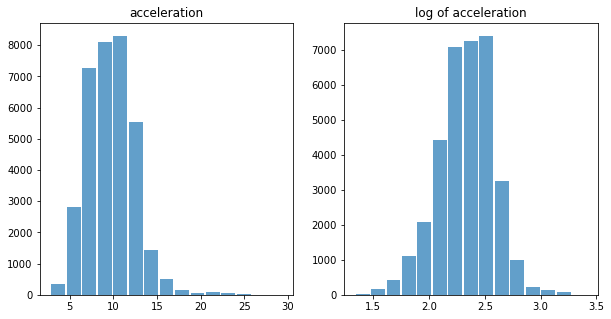

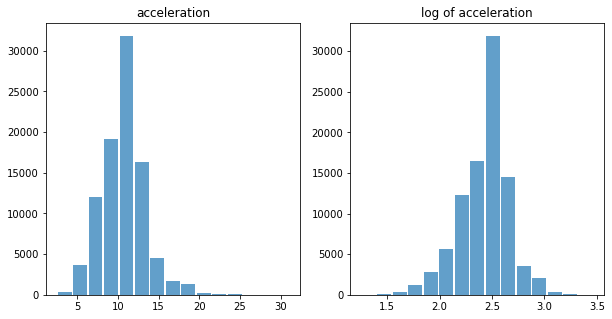

In [220]:
val_log_plot(test21, 'acceleration')
val_log_plot(train21, 'acceleration')

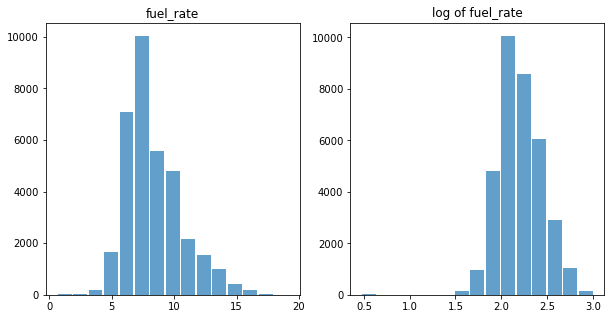

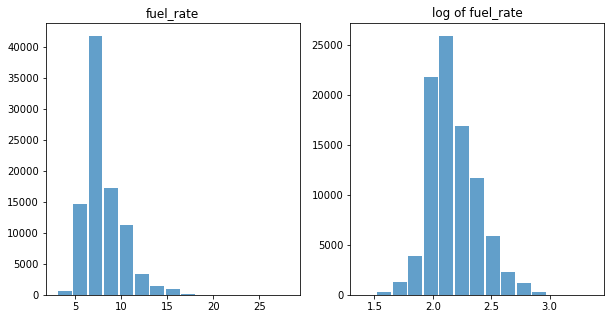

In [221]:
val_log_plot(test21, 'fuel_rate')
val_log_plot(train21, 'fuel_rate')

Особых изменений нет, распределения примерно совпадают.Столбцы логарифмировать не будем. К тому же они не являются самыми важными.

<a id='vendor'></a>
## vendor

In [222]:
print(train21.vendor.unique())
print(test21.vendor.unique())

['EUROPEAN' 'CHINESE' 'AMERICAN' 'RUSSIAN' 'KOREAN' 'JAPANESE']
['EUROPEAN' 'JAPANESE']


Названия совпадают. Из общей статистики, полученной выше на этапе чтения данных, видно, что пропусков нет. Обрабатывать данный признак не надо. 

<a id='impotance'></a>
# Анализ значимости и выбор признаков

<a id='imp_old'></a>
## Корреляция и значимость признаков в старых наборах

In [223]:
# Проверим поля и выделим наборы столбцов для проверки значимости столбцов
print(test.columns)
print(train.columns)

Index(['bodyType', 'brand', 'color', 'complectation_dict', 'description',
       'engineDisplacement', 'enginePower', 'equipment_dict', 'fuelType',
       'mileage', 'modelDate', 'model_info', 'model_name', 'numberOfDoors',
       'productionDate', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'complectation_dict_y', 'equipment_dict_y', 'body',
       'bodyTest', 'brandTest', 'brandRang', 'color_type', 'tax_rate', 'tax',
       'eP_log', 'eP_log_out', 'eD_log', 'eD_log_out', 'mileage_out',
       'milPerYear', 'new_auto', 'model_age', 'model_age_log', 'age',
       'age_log', 'age_cat', 'model_old', 'own_num', 'own_null', 'exState',
       'goodState', 'noSmoke', 'dent', 'salon', 'carter', 'electro-window',
       'airbag', 'wheel-power', 'lock', 'help', 'climate', 'cruise',
       'computer', 'heat', 'electro-mirrors', 'ptf', 'abs', 'esp', 'condition',
       'immo', 'alarm', 'navigation', 'park', 'audio', 'rain-sensor',
       'alloy-wheel-disks', 'c

In [224]:
# Двоичные признаки для старых наборов - train и test
bin_columns = ['Руль', 'bodyTest', 'brandTest', 'eP_log_out', 'eD_log_out',
       'mileage_out', 'exState', 'goodState', 'electro-window', 'airbag', 'wheel-power',
       'lock', 'help', 'climate', 'cruise', 'computer', 'heat', 'own_null', 'noSmoke',
       'electro-mirrors', 'ptf', 'abs', 'esp', 'condition', 'immo', 'alarm',
       'navigation', 'park', 'audio', 'rain-sensor', 'alloy-wheel-disks',
       'camera', 'tyre-pressure', 'halogen', 'dark', 'asr', 'dent', 'salon', 'carter', 'new_auto']

# Числовые признаки
num_columns = ['engineDisplacement', 'enginePower', 
       'mileage', 'modelDate', 'numberOfDoors', 'productionDate',
       'Владельцы', 'tax_rate', 'tax', 'own_num', 'model_age_log',
       'milPerYear', 'model_age', 'age', 'age_cat', 'model_old',
       'eD_log', 'eP_log', 'age_log', 'desc_len','compl_len',
       'desc_mean_log', 'desc_sum_log']

# Категориальные признаки
cat_columns = ['bodyType', 'brand', 'color','fuelType',
       'model_name', 'vehicleTransmission', 'ПТС',
       'Привод', 'body', 'brandRang', 'color_type']

# Служебные признаки
srv_columns = ['price', 'price_log']

In [225]:
# Временно сольем два набора данных и кодируем категориальные признаки для проверки корреляции
columns = bin_columns + num_columns + cat_columns
df_train = train[columns]
df_test = test[columns]

data = df_test.append(df_train, sort=False).reset_index(drop=True) 

for colum in cat_columns:
    data[colum] = data[colum].astype('category').cat.codes

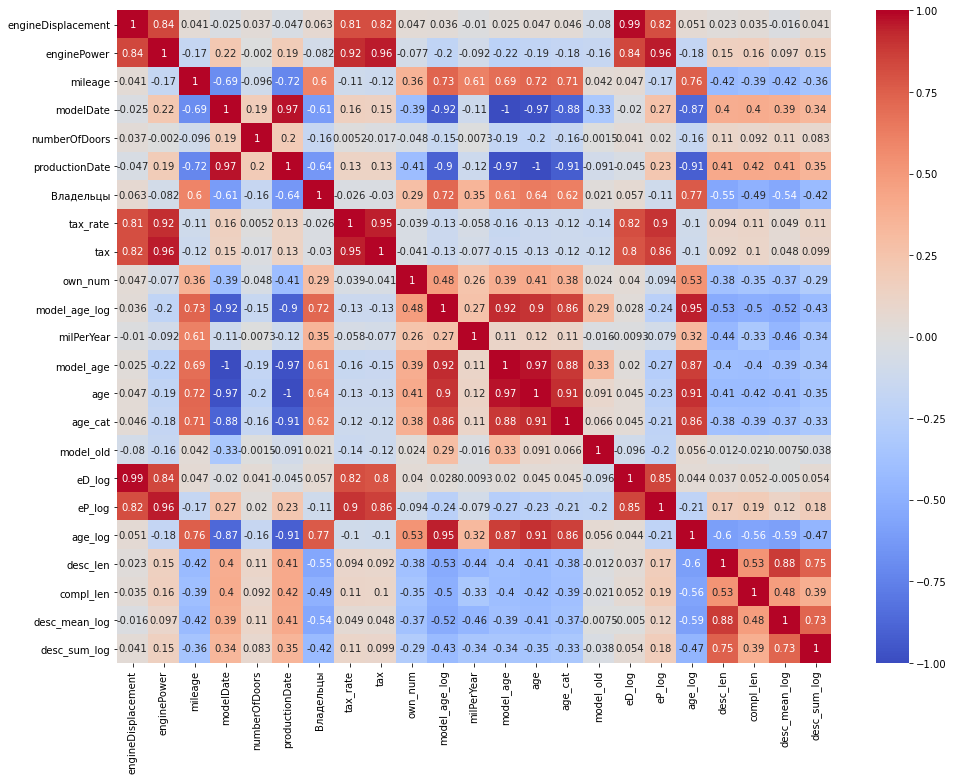

In [226]:
# Проверим корреляцию числовых столбцов в сборном датасете
correlation = data[num_columns].corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

1. modelDate и model_age абсолютно коррелируют, что закономерно. Удалим modelDate, так как там значения больше.
2. productionDate и age абсолютно коррелируют, что закономерно. Удалим productionDate, так как там значения больше.
3. age и model_age очень сильно коррелируют, что закономерно. Но их логарифмы коррелируют уже не так сильно. Оставим логарифмы от обоих возрастов.
4. age_cat очень сильно коррелирует с age, но удалять пока не будем, потому что этот признак повторяет пики зависимости цены от возраста.
5. tax очень сильно коррелирует с tax_rate и enginePower. Удалим tax.

Удаление проведем просто в виде непередачи их в модели.

In [227]:
# Откорректируем набор числовых столбцов в старых наборах, удалив корреллирующие столбцы и нелогарифмы, если есть логарифмы
num_columns = ['engineDisplacement', 'enginePower', 
       'mileage', 'numberOfDoors', 
       'Владельцы', 'tax_rate', 'own_num', 'model_age_log',
       'milPerYear', 'age_cat', 'model_old',
       'eD_log', 'eP_log', 'age_log', 'desc_len','compl_len',
       'desc_mean_log', 'desc_sum_log']

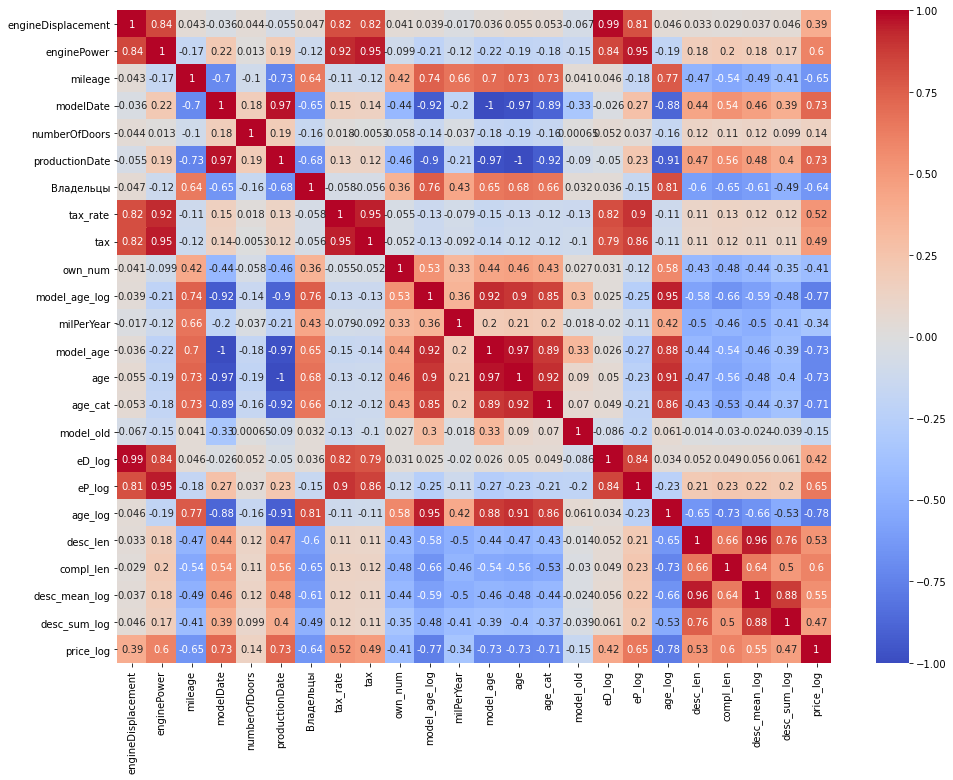

In [228]:
# Проверим корреляцию числовых столбцов в train, чтобы понять, как они влияют на цену
num_train_columns = ['engineDisplacement', 'enginePower', 
       'mileage', 'modelDate', 'numberOfDoors', 'productionDate',
       'Владельцы', 'tax_rate', 'tax', 'own_num', 'model_age_log',
       'milPerYear', 'model_age', 'age', 'age_cat', 'model_old',
       'eD_log', 'eP_log', 'age_log', 'desc_len','compl_len', 
       'desc_mean_log', 'desc_sum_log', 'price_log']
correlation = train[num_train_columns].corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Видно, что однозначной корреляции цены ни с одним признаком нет.
Есть очень сильные зависимости - от возраста, пробега и количества владельцев. Это всё производные возраста. 
Также сильно зависит от мощности автомобиля и длины списка оборудования - чем мощнее и чем больше укомплектован, тем дороже.
При этом зависимость от логарифма признака немного сильнее.

In [229]:
# Проверим статистическую значимость числовых столбцов по Пирсону
get_stat_corr(train, num_columns, 'price_log')

engineDisplacement для price_log - значимость есть
enginePower для price_log - значимость есть
mileage для price_log - значимость есть
numberOfDoors для price_log - значимость есть
Владельцы для price_log - значимость есть
tax_rate для price_log - значимость есть
own_num для price_log - значимость есть
model_age_log для price_log - значимость есть
milPerYear для price_log - значимость есть
age_cat для price_log - значимость есть
model_old для price_log - значимость есть
eD_log для price_log - значимость есть
eP_log для price_log - значимость есть
age_log для price_log - значимость есть
desc_len для price_log - значимость есть
compl_len для price_log - значимость есть
desc_mean_log для price_log - значимость есть
desc_sum_log для price_log - значимость есть


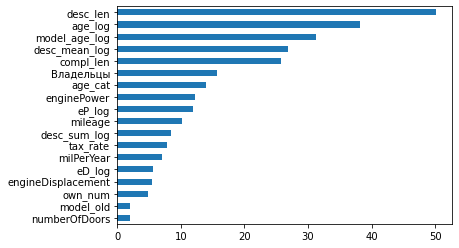

In [230]:
# Проверим значимость признаков на train с непрерывными значениями по тесту ANOVA
imp_num = Series(f_classif(train[num_columns], train['price_log'])[0], index = num_columns)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Возраст и его производные - самый значимый признак. Как ни странно, длина описания - тоже. Наверное, это связано с тем, что самые длинные описания у новых автомобилей, и эти описания идут от торговой площадки.

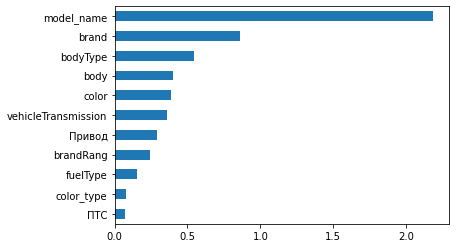

In [231]:
# Посмотрим на значимость категориальных столбцов
model_columns = cat_columns + num_columns + bin_columns + srv_columns
df1 = train[model_columns].copy()

label_encoder = LabelEncoder()
for col in cat_columns:
    df1[col] = label_encoder.fit_transform(df1[col])
    
imp_cat = pd.Series(mutual_info_classif(df1[cat_columns], 
                                        df1['price'], discrete_features = True), 
                    index=cat_columns)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

plt.show()

Самая сильная зависимость наблюдается от модели машины и бренда. Что ничуть не удивительно.

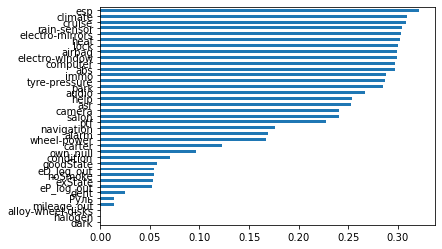

In [232]:
# Проверим значимость двоичных признаков
bin_columns1 = ['Руль',  'eP_log_out', 'eD_log_out',
       'mileage_out', 'exState', 'goodState', 'electro-window', 'airbag', 'wheel-power',
       'lock', 'help', 'climate', 'cruise', 'computer', 'heat', 'own_null', 'noSmoke',
       'electro-mirrors', 'ptf', 'abs', 'esp', 'condition', 'immo', 'alarm',
       'navigation', 'park', 'audio', 'rain-sensor', 'alloy-wheel-disks',
       'camera', 'tyre-pressure', 'halogen', 'dark', 'asr', 'dent', 'salon', 'carter']

imp_cat = pd.Series(mutual_info_classif(df1[bin_columns1], 
                                        df1['price'], discrete_features = True), 
                    index=bin_columns1)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

plt.show()

Самые значимые признаки: 'esp', 'climate', 'cruise', 'rain-sensor', 'electro-mirrors', 'heat', 'lock', 'airbag',
'electro-windows', 'computer', 'abs', 'immo', 'tyre-pressure', 'park', 'audio', 'help', 'asr', 'camera', 'salon', 'ptf'

In [233]:
# Проверим значимость признаков с дискретными значениями по критерию Стьюдента
get_stat_dif(train, cat_columns, 'price_log')

bodyType: порог=4e-06, значимость есть: для ('внедорожник 5 дв.', 'седан') p_value=0.0
brand: порог=7.9e-05, значимость есть: для ('mercedes', 'bmw') p_value=5.879339322658412e-35
color: порог=0.000417, значимости нет
fuelType: порог=0.005, значимость есть: для ('бензин', 'дизель') p_value=0.0
model_name: порог=0.0, значимость есть: для ('focus', 'solaris') p_value=0.0
vehicleTransmission: порог=0.008333, значимость есть: для ('AT', 'MT') p_value=0.0
ПТС: порог=0.016667, значимость есть: для ('ORIGINAL', 'DUPLICATE') p_value=0.0
Привод: порог=0.016667, значимость есть: для ('передний', 'полный') p_value=0.0
body: порог=0.000417, значимость есть: для ('внедорожник', 'седан') p_value=0.0
brandRang: порог=0.008333, значимость есть: для (2, 1) p_value=0.0
color_type: порог=0.016667, значимость есть: для (0, 1) p_value=0.0


In [234]:
get_stat_dif(train, bin_columns, 'price_log')

Руль: порог=0.05, значимость есть: для (0, 1) p_value=4.370494964804084e-258
bodyTest: порог=0.05, значимость есть: для (1, 0) p_value=0.0
brandTest: порог=0.05, значимость есть: для (1, 0) p_value=0.0
eP_log_out: порог=0.05, значимость есть: для (0, 1) p_value=0.0
eD_log_out: порог=0.05, значимость есть: для (0, 1) p_value=0.0
mileage_out: порог=0.05, значимость есть: для (0, 1) p_value=0.0
exState: порог=0.05, значимость есть: для (0, 1) p_value=2.5845851607441047e-27
goodState: порог=0.05, значимость есть: для (0, 1) p_value=0.0
electro-window: порог=0.05, значимость есть: для (0, 1) p_value=0.0
airbag: порог=0.05, значимость есть: для (0, 1) p_value=0.0
wheel-power: порог=0.05, значимость есть: для (0, 1) p_value=0.0
lock: порог=0.05, значимость есть: для (0, 1) p_value=0.0
help: порог=0.05, значимость есть: для (0, 1) p_value=0.0
climate: порог=0.05, значимость есть: для (0, 1) p_value=0.0
cruise: порог=0.05, значимость есть: для (0, 1) p_value=0.0
computer: порог=0.05, значимость

Почти все признаки оказались значимыми. Удалим признаки alloy-wheel-disks, halogen и dark.

<a id='imp_new'></a>
## Корреляция и значимость признаков в новых наборах

In [235]:
# Проверим поля и выделим наборы столбцов для проверки значимости столбцов
print(test21.columns[:49])

Index(['bodyType', 'brand', 'color', 'complectation_dict', 'description',
       'engineDisplacement', 'enginePower', 'equipment_dict', 'fuelType',
       'mileage', 'modelDate', 'model_info', 'model_name', 'numberOfDoors',
       'productionDate', 'super_gen', 'vehicleTransmission', 'vendor',
       'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль',
       'complectation_dict_y', 'equipment_dict_y', 'body', 'bodyTest',
       'brandTest', 'brandRang', 'color_type', 'tax_rate', 'tax', 'eP_log',
       'eP_log_out', 'eD_log', 'eD_log_out', 'mileage_out', 'milPerYear',
       'new_auto', 'model_age', 'model_age_log', 'age', 'age_log', 'age_cat',
       'model_old', 'own_num', 'own_null', 'exState', 'goodState'],
      dtype='object')


In [236]:
print(test21.columns[48:])

Index(['goodState', 'noSmoke', 'dent', 'salon', 'carter', 'electro-window',
       'airbag', 'wheel-power', 'lock', 'help',
       ...
       'park-assist-f1', 'auto-park1', 'parktronik1', 'rear-seats-heat1',
       'seats-heat1', 'compl_len', 'eq_len', 'acceleration', 'clearance_min',
       'fuel_rate'],
      dtype='object', length=101)


In [237]:
# Двоичные признаки для новых наборов - train21 и test21
bin_columns21 = ['Руль','eP_log_out','eD_log_out','mileage_out','own_null',                 # Руль, выбросы и пустые значения
                   'exState', 'goodState', 'noSmoke', 'dent', 'salon', 'carter',            # Признаки из описания и комплектации
                   'electro-window', 'airbag', 'wheel-power', 'lock', 'help', 
                   'climate', 'cruise', 'computer', 'heat',
                   'electro-mirrors', 'ptf', 'abs', 'esp', 'condition', 'immo', 'alarm',
                   'navigation', 'park', 'audio', 'rain-sensor', 'alloy-wheel-disks',
                   'camera', 'tyre-pressure', 'halogen', 'dark', 'asr', 
                   'lock1', 'abs1', 'electro-mirrors1', 'computer1', 'airbag-driver1',      # Признаки из оборудования
                   'immo1', 'electro-window-front1', 'ptf1', 'airbag-passenger1', 
                   'wheel-power1', 'front-seats-heat1', 'aux1', 'usb1', 'electro-window-back1',
                   'wheel-leather1', 'esp1', 'multi-wheel1', 'mirrors-heat1',
                   'wheel-configuration11', 'airbag-side1', '12v-socket1',
                   'front-centre-armrest1', 'tinted-glass1', 'bluetooth1',
                   'cruise-control1', 'audiosystem-cd1', 'seat-transformation1', '1',
                   'light-sensor1', 'rain-sensor1', 'fabric-seats1', 'isofix1', 'alarm1',
                   'alloy-wheel-disks1', 'wheel-configuration21', 'dark-interior1',
                   'park-assist-r1', 'leather-gear-stick1', 'light-cleaner1',
                   'auto-mirrors1', 'engine-proof1', 'leather1', 'airbag-curtain1',
                   'automatic-lighting-control1', 'third-rear-headrest1', 'asr1',
                   'ashtray-and-cigarette-lighter1', 'condition1', 'tyre-pressure1',
                   'climate-control1', 'navigation1', 'audiosystem1', 'front-camera1',
                   'rear-camera1', '360-camera1', 'park-assist-f1', 'auto-park1',
                   'parktronik1', 'rear-seats-heat1', 'seats-heat1']


# Числовые признаки с логарифмами
num_columns21 = ['mileage', 'numberOfDoors','Владельцы',
                 'tax_rate', 'tax', 'eP_log','eD_log','milPerYear',
                 'model_age_log', 'age_log', 'age_cat', 'model_old',
                 'own_num','desc_len', 'compl_len', 'eq_len', 
                 'acceleration','clearance_min', 'fuel_rate',
                 'desc_mean_log', 'desc_sum_log']

# Категориальные признаки
cat_columns21 = ['bodyType', 'brand', 'color','fuelType','model_name',
                 'vehicleTransmission','vendor','ПТС','Привод','body',
                 'brandRang','color_type']

# Служебные признаки
srv_columns21 = ['price', 'price_log']

In [238]:
# Временно сольем два набора данных и кодируем категориальные признаки для проверки корреляции
columns21 = bin_columns21 + num_columns21 + cat_columns21
df_train21 = train21[columns21]
df_test21 = test21[columns21]

data21 = df_test21.append(df_train21, sort=False).reset_index(drop=True) 

for colum in cat_columns21:
    data21[colum] = data21[colum].astype('category').cat.codes

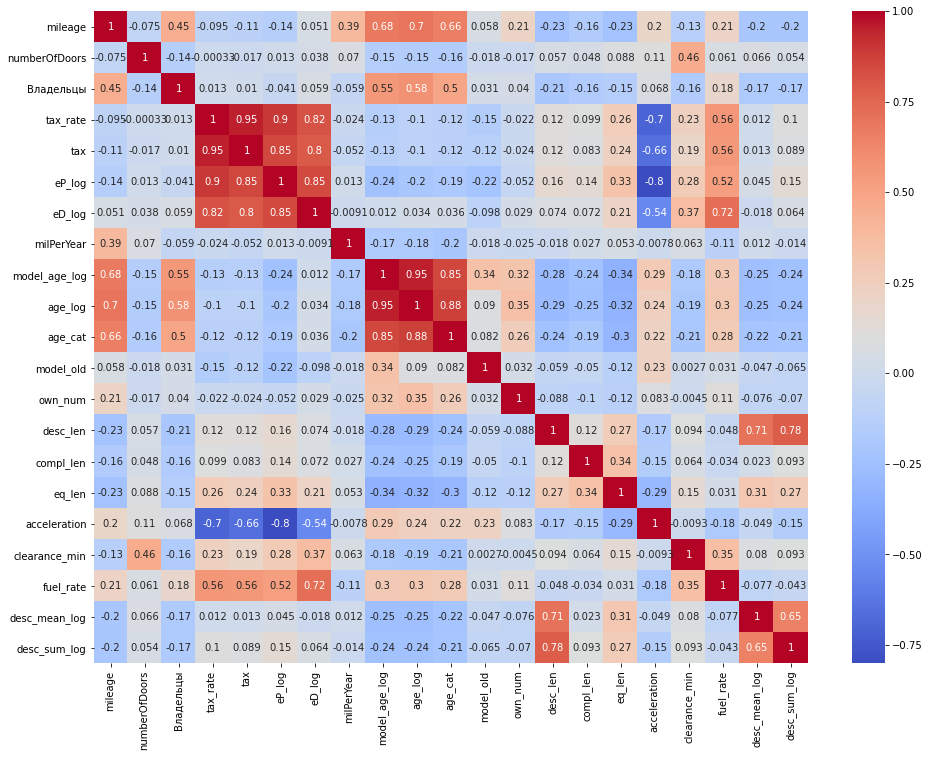

In [239]:
# Проверим корреляцию числовых столбцов в сборном датасете
correlation = data21[num_columns21].corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

1. Для столбцов model_age и age  (их логарифмов) закономерности такие же, как в старых наборах. Оставим логарифмы от возрастов: age_log и model_age_log.
2. tax также очень сильно коррелирует с tax_rate и enginePower. Но попробуем оставить оба признака.
3. У остальных столбцов есть тоже сильные корреляции (например, age_cat с возрастом машины или acceleration c enginePower), но попробуем всё оставить. Непонятно, как они повлияют на модель.

Таким образом, удалять среди оставленных столбцов ничего не будем.

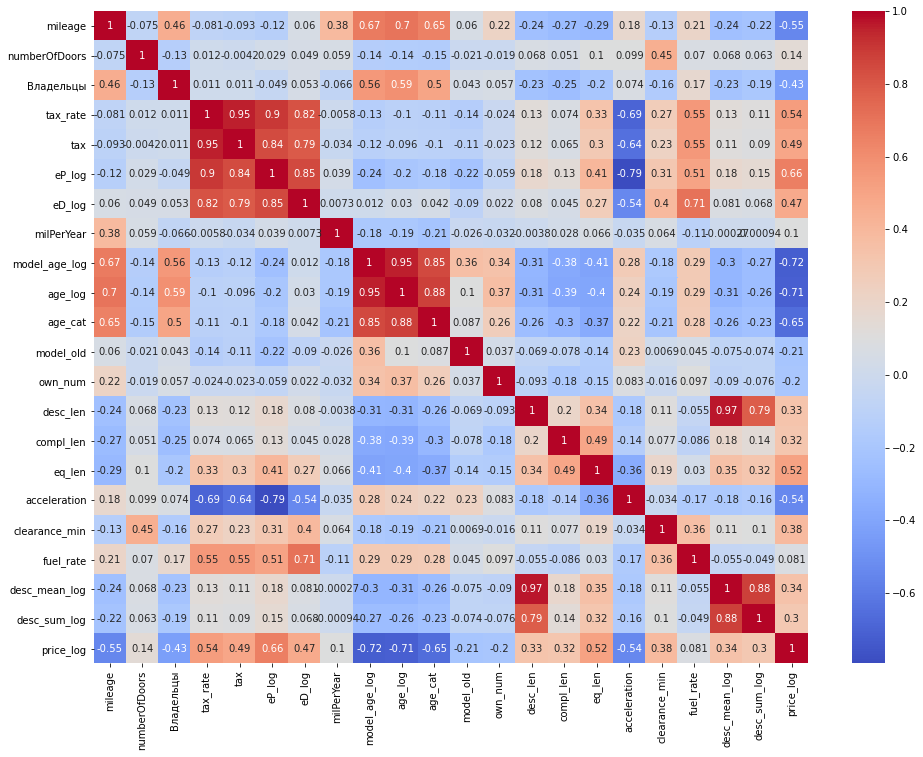

In [240]:
# Проверим корреляцию числовых столбцов в train21, чтобы понять, как они влияют на цену
num_train_columns = ['mileage', 'numberOfDoors','Владельцы',
                 'tax_rate', 'tax', 'eP_log','eD_log','milPerYear',
                 'model_age_log', 'age_log', 'age_cat', 'model_old',
                 'own_num','desc_len', 'compl_len', 'eq_len', 
                 'acceleration','clearance_min', 'fuel_rate',
                 'desc_mean_log', 'desc_sum_log', 'price_log']
correlation = train21[num_train_columns].corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

И снова видно, что однозначной корреляции цены ни с одним признаком нет. Снова есть сильные зависимости - от возраста и мощности автомобиля. А также есть ощутимая зависимость от пробега, укомплектованности и налоговой ставки.

In [241]:
# Проверим статистическую значимость числовых столбцов по Пирсону
get_stat_corr(train21, num_columns21, 'price_log')

mileage для price_log - значимость есть
numberOfDoors для price_log - значимость есть
Владельцы для price_log - значимость есть
tax_rate для price_log - значимость есть
tax для price_log - значимость есть
eP_log для price_log - значимость есть
eD_log для price_log - значимость есть
milPerYear для price_log - значимость есть
model_age_log для price_log - значимость есть
age_log для price_log - значимость есть
age_cat для price_log - значимость есть
model_old для price_log - значимость есть
own_num для price_log - значимость есть
desc_len для price_log - значимость есть
compl_len для price_log - значимость есть
eq_len для price_log - значимость есть
acceleration для price_log - значимость есть
clearance_min для price_log - значимость есть
fuel_rate для price_log - значимость есть
desc_mean_log для price_log - значимость есть
desc_sum_log для price_log - значимость есть


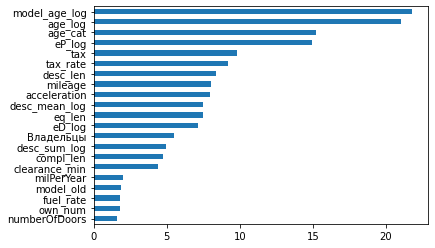

In [242]:
# Проверим значимость признаков на train с непрерывными значениями по тесту ANOVA
imp_num = Series(f_classif(train21[num_columns21], train21['price_log'])[0], index = num_columns21)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Возраст модели и самого автомобиля - самые значимые признаки. После них сильнее всего влияет мощность автомобиля и его производные (разгон до 100 км/ч, налоговая ставка). На третьем месте - комплектация (она присутствует в виде длин списка оборудования и словесного описания).

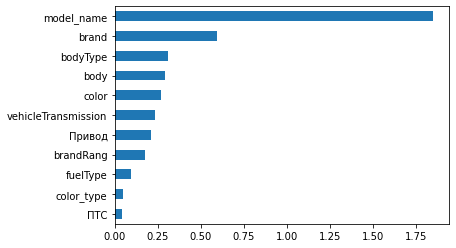

In [243]:
# Посмотрим на значимость категориальных столбцов
model_columns21 = cat_columns21 + num_columns21 + bin_columns21 + srv_columns21
df1 = train21[model_columns21].copy()

label_encoder = LabelEncoder()
for col in cat_columns21:
    df1[col] = label_encoder.fit_transform(df1[col])
    
imp_cat = pd.Series(mutual_info_classif(df1[cat_columns], 
                                        df1['price'], discrete_features = True), 
                    index=cat_columns)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

plt.show()

Как и в старом наборе, самая сильная зависимость наблюдается от модели машины и бренда.

In [244]:
# Проверим значимость признаков с дискретными значениями по критерию Стьюдента
get_stat_dif(train21, cat_columns21, 'price_log')

bodyType: порог=0.000154, значимость есть: для ('седан', 'внедорожник 5 дв.') p_value=0.0
brand: порог=7.9e-05, значимость есть: для ('kia', 'volkswagen') p_value=4.035202072948486e-36
color: порог=0.000417, значимость есть: для ('чёрный', 'белый') p_value=6.393501448496781e-05
fuelType: порог=0.005, значимость есть: для ('бензин', 'дизель') p_value=0.0
model_name: порог=0.0, значимость есть: для ('FOCUS', 'RIO') p_value=1.001610095408365e-193
vehicleTransmission: порог=0.008333, значимость есть: для ('AT', 'MT') p_value=0.0
vendor: порог=0.003333, значимость есть: для ('EUROPEAN', 'JAPANESE') p_value=2.4988433594776654e-116
ПТС: порог=0.05, значимость есть: для ('ORIGINAL', 'DUPLICATE') p_value=0.0
Привод: порог=0.016667, значимость есть: для ('передний', 'полный') p_value=0.0
body: порог=0.000417, значимость есть: для ('седан', 'внедорожник') p_value=0.0
brandRang: порог=0.008333, значимость есть: для (2, 1) p_value=0.0
color_type: порог=0.016667, значимость есть: для (0, 1) p_value=

In [245]:
# Проверим значимость признаков с дискретными значениями по критерию Стьюдента
get_stat_dif(train21, bin_columns21, 'price_log')

Руль: порог=0.05, значимость есть: для (0, 1) p_value=0.0
eP_log_out: порог=0.05, значимость есть: для (0, 1) p_value=0.0
eD_log_out: порог=0.05, значимость есть: для (0, 1) p_value=0.0
mileage_out: порог=0.05, значимость есть: для (0, 1) p_value=0.0
own_null: порог=0.05, значимость есть: для (1, 0) p_value=2.676094204065238e-22
exState: порог=0.05, значимость есть: для (0, 1) p_value=1.8208389374039067e-86
goodState: порог=0.05, значимость есть: для (0, 1) p_value=0.0
noSmoke: порог=0.05, значимость есть: для (0, 1) p_value=4.529411765991724e-35
dent: порог=0.05, значимость есть: для (0, 1) p_value=0.00972103251892786
salon: порог=0.05, значимость есть: для (0, 1) p_value=0.0
carter: порог=0.05, значимость есть: для (0, 1) p_value=8.750063885274403e-175
electro-window: порог=0.05, значимость есть: для (0, 1) p_value=0.0
airbag: порог=0.05, значимость есть: для (0, 1) p_value=0.0
wheel-power: порог=0.05, значимость есть: для (0, 1) p_value=5.713243658421185e-111
lock: порог=0.05, значи

Удалим незначащий признак: '1', который соответствует пустому описанию, и признак halogen.

In [246]:
get_stat_corr(train21, num_columns21, 'price_log')

mileage для price_log - значимость есть
numberOfDoors для price_log - значимость есть
Владельцы для price_log - значимость есть
tax_rate для price_log - значимость есть
tax для price_log - значимость есть
eP_log для price_log - значимость есть
eD_log для price_log - значимость есть
milPerYear для price_log - значимость есть
model_age_log для price_log - значимость есть
age_log для price_log - значимость есть
age_cat для price_log - значимость есть
model_old для price_log - значимость есть
own_num для price_log - значимость есть
desc_len для price_log - значимость есть
compl_len для price_log - значимость есть
eq_len для price_log - значимость есть
acceleration для price_log - значимость есть
clearance_min для price_log - значимость есть
fuel_rate для price_log - значимость есть
desc_mean_log для price_log - значимость есть
desc_sum_log для price_log - значимость есть


<a id='prep_old'></a>
## Подготовка и разбиение данных для старого набора

In [1]:
# Откорректируем набор признаков с учетом их значимости и корреляций между собой

# Двоичные признаки
bin_columns = ['Руль', 'eP_log_out', 'eD_log_out',
       'mileage_out', 'exState', 'goodState', 'electro-window', 'airbag', 'wheel-power',
       'lock', 'help', 'climate', 'cruise', 'computer', 'heat', 'own_null', 'noSmoke',
       'electro-mirrors', 'ptf', 'abs', 'esp', 'condition', 'immo', 'alarm',
       'navigation', 'park', 'audio', 'rain-sensor',
       'camera', 'tyre-pressure', 'asr', 'dent', 'salon', 'carter', 'new_auto']

# Числовые признаки
num_columns = [#'engineDisplacement', 'enginePower', 
       'mileage', 'numberOfDoors', 
       'Владельцы', 'tax_rate', 'own_num', 'model_age_log',
       'milPerYear', 'age_cat', 'model_old',
       'eD_log', 'eP_log', 'age_log', 'desc_len','compl_len',
       'desc_mean_log', 'desc_sum_log']

# Категориальные признаки
cat_columns = ['bodyType', 'brand', 'color','fuelType',
       'model_name', 'vehicleTransmission', 'ПТС',
       'Привод', 'body', 'brandRang', 'color_type']

# Целевые признаки
srv_columns = ['price', 'price_log']

In [248]:
# Подбираем столбцы, кодируем и готовим наборы для модели
columns = bin_columns + num_columns + cat_columns
df_train = train[columns]
df_test = test[columns]

y = train['price']

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

for colum in cat_columns:
    data[colum] = data[colum].astype('category').cat.codes
    
X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

X.shape, len(y)

((88965, 64), 88965)

In [249]:
# Разбиваем тренировочный набор для обучения
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [250]:
# Нормализуем числовые признаки - не стали нормализовать, метрика ухудшалась
# robust = RobustScaler().fit(X[num_columns].values)
# X_num_train = robust.transform(X_train[num_columns].values)
# X_num_test = robust.transform(X_test[num_columns].values)

<a id='prep_new'></a>
## Подготовка и разбиение данных для нового набора

In [251]:
# Откорректируем набор столбцов с учетом их значимости и корреляций между собой

bin_columns21 = ['Руль','eP_log_out','eD_log_out','mileage_out','own_null',                 # Руль, выбросы и пустые значения
                   'exState', 'goodState', 'noSmoke', 'dent', 'salon', 'carter',            # Признаки из описания и комплектации
                   'electro-window', 'airbag', 'wheel-power', 'lock', 'help', 
                   'climate', 'cruise', 'computer', 'heat',
                   'electro-mirrors', 'ptf', 'abs', 'esp', 'condition', 'immo', 'alarm',
                   'navigation', 'park', 'audio', 'rain-sensor', 'alloy-wheel-disks',
                   'camera', 'tyre-pressure', 'dark', 'asr', 
                   'lock1', 'abs1', 'electro-mirrors1', 'computer1', 'airbag-driver1',      # Признаки из оборудования
                   'immo1', 'electro-window-front1', 'ptf1', 'airbag-passenger1', 
                   'wheel-power1', 'front-seats-heat1', 'aux1', 'usb1', 'electro-window-back1',
                   'wheel-leather1', 'esp1', 'multi-wheel1', 'mirrors-heat1',
                   'wheel-configuration11', 'airbag-side1', '12v-socket1',
                   'front-centre-armrest1', 'tinted-glass1', 'bluetooth1',
                   'cruise-control1', 'audiosystem-cd1', 'seat-transformation1', 
                   'light-sensor1', 'rain-sensor1', 'fabric-seats1', 'isofix1', 'alarm1',
                   'alloy-wheel-disks1', 'wheel-configuration21', 'dark-interior1',
                   'park-assist-r1', 'leather-gear-stick1', 'light-cleaner1',
                   'auto-mirrors1', 'engine-proof1', 'leather1', 'airbag-curtain1',
                   'automatic-lighting-control1', 'third-rear-headrest1', 'asr1',
                   'ashtray-and-cigarette-lighter1', 'condition1', 'tyre-pressure1',
                   'climate-control1', 'navigation1', 'audiosystem1', 'front-camera1',
                   'rear-camera1', '360-camera1', 'park-assist-f1', 'auto-park1',
                   'parktronik1', 'rear-seats-heat1', 'seats-heat1']


# Числовые признаки с логарифмами
num_columns21 = ['mileage', 'numberOfDoors','Владельцы',
                 'tax_rate', 'tax', 'eP_log','eD_log','milPerYear',
                 'model_age_log', 'age_log', 'age_cat', 'model_old',
                 'own_num','desc_len', 'compl_len', 'eq_len', 
                 'acceleration','clearance_min', 'fuel_rate',
                 'desc_mean_log', 'desc_sum_log']

# Категориальные признаки
cat_columns21 = ['bodyType', 'brand', 'color','fuelType','model_name',
                 'vehicleTransmission','vendor','ПТС','Привод','body',
                 'brandRang','color_type']


# Целевые признаки
srv_columns = ['price', 'price_log']

In [252]:
# Подбираем столбцы, кодируем и готовим наборы для модели
columns21 =  bin_columns21 + num_columns21 + cat_columns21 #
df_train21 = train21[columns21]
df_test21 = test21[columns21]

y21 = train21['price']

df_train21['sample'] = 1 # помечаем где у нас трейн
df_test21['sample'] = 0 # помечаем где у нас тест

data21 = df_test21.append(df_train21, sort=False).reset_index(drop=True) # объединяем

for colum in cat_columns21:
    data21[colum] = data21[colum].astype('category').cat.codes
    
X21 = data21.query('sample == 1').drop(['sample'], axis=1)
X_sub21 = data21.query('sample == 0').drop(['sample'], axis=1)

X21.shape, len(y21)

((91357, 128), 91357)

In [253]:
# Разбиваем тренировочный набор для обучения
X_train21, X_test21, y_train21, y_test21 = train_test_split(X21, y21, 
                                            test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

<a id='modeling'></a>
# Подбор моделей

<a id='forest'></a>
## Модель 1: Random Forest 

In [254]:
# # Модель с параметрами по умолчанию на старых данных
# model1 = RandomForestRegressor(random_state=RANDOM_SEED)

# # Обучаем модель на тестовом наборе данных
# model1.fit(X_train, np.log(y_train))
# y_pred = model1.predict(X_test)

# # Преобразуем y_test, y_pred к exp значениям для оценки MAPE

# y_pred = np.round(np.exp(y_pred))

# # Вывод результата MAPE
# print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели на старом наборе по метрике MAPE: 12.31%

In [255]:
# # Модель с параметрами по умолчанию на новых данных
# model1_21 = RandomForestRegressor(random_state=RANDOM_SEED)

# # Обучаем модель на тестовом наборе данных
# model1_21.fit(X_train21, np.log(y_train21))
# y_pred21 = model1_21.predict(X_test21)

# y_pred21 = np.round(np.exp(y_pred21))

# # Вывод результата MAPE
# print(f"Точность обученной модели по метрике MAPE: {(mape(y_test21, y_pred21))*100:0.2f}%")

Точность модели на новом наборе: 13.47%

In [256]:
# Подбор оптимальных параметров для RandomForest

# param_grid = {'n_estimators': [100, 200, 300, 400, 500],
#                'max_features': ['auto', 'sqrt'],
#                'max_depth': [8, 10, 12] + [None],
#                'min_samples_split': [2, 5, 10],
#                'min_samples_leaf': [1, 2, 4],
#                'bootstrap': [True, False]}

# model1s = RandomForestRegressor(random_state = RANDOM_SEED)
# grid_search_result = RandomizedSearchCV(estimator = model1s, 
#                                         param_distributions = param_grid, 
#                                         n_iter = 100, 
#                                         cv = 3, 
#                                         verbose=10, 
#                                         random_state=RANDOM_SEED, 
#                                         n_jobs = -1)
# grid_search_result.fit(X_train, y_train)
# grid_search_result.best_params_

# Нашли лучшие параметры:
# {'n_estimators': 300,
#  'min_samples_split': 10,
#  'min_samples_leaf': 1,
#  'max_features': 'sqrt',
#  'max_depth': None,
#  'bootstrap': False}

Подбор параметров шёл около 1,5 часов. В некоторых других моделях доходило до 3,5 часов. Но в среднем по каждой модели подбор гиперпараметров занимал около 2 часов.

In [257]:
# # RandomForest с оптимальными параметрами
# model1s = RandomForestRegressor(random_state=RANDOM_SEED,
#                      n_estimators=300,
#                      min_samples_split=10,
#                      min_samples_leaf=1,
#                      max_features='sqrt',
#                      max_depth=None,
#                      bootstrap=False)

# model1s.fit(X_train, np.log(y_train))
# y_pred = model1s.predict(X_test)

# y_pred = np.round(np.exp(y_pred))

# # Вывод результата MAPE
# print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 12.29%. 
Подбор параметров немного улучшил метрику.

<a id='cat'></a>
## Модель 2: Cat Boosting

In [258]:
# # Модель с параметрами по умолчанию
# model2 = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )
# model2.fit(X_train, np.log(y_train),
#          #cat_features=cat_features_ids,
#          eval_set=(X_test, np.log(y_test)),
#          verbose_eval=0,
#          use_best_model=True,
#          #plot=True
#          )

# # Непонятно, зачем это. Надо почитать.
# # model2.save_model('catboost_single_model_2_baseline.model')

# y_pred = np.exp(model2.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 12.26%. CatBoost значительно улучшил метрику. Точность при сабмите: 13.26%

In [259]:
# Подбор оптимальных параметров для CatBoost

# param_grid = {'iterations': [1000],
#               'learning_rate': [0.01, 0.1, 0.25, 0.5],
#               'l2_leaf_reg': np.arange(1, 8),
#               'depth': np.arange(10, 12, 14),
#               'thread_count': [4]}

# param_grid = {'iterations': [500],
#               'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
#               'thread_count': [4]}

# model2s = CatBoostRegressor()

# grid_search_result = model2s.grid_search(param_grid=param_grid,
#                 X=X,
#                 y=y,
#                 cv=5,
#                 partition_random_seed=0,
#                 search_by_train_test_split=True,
#                 refit=True,
#                 shuffle=True,
#                 stratified=None,
#                 train_size=0.8,
#                 verbose=True,
#                 plot=False)

# #grid_search_result = model2s.grid_search(grid, 
# #                                       X=X_train, 
# #                                       y=y_train, 
# #                                       plot=False)
# print(grid_search_result['params'])

In [260]:
# # Модель с подобранными параметрами
# model2s = CatBoostRegressor(iterations = 500,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                           depth = 10,
#                           l2_leaf_reg = 1,
#                           learning_rate = 0.35,
#                           thread_count = 4
#                          )
# model2s.fit(X_train, np.log(y_train),
#          #cat_features=cat_features_ids,
#          eval_set=(X_test, np.log(y_test)),
#          verbose_eval=0,
#          use_best_model=True,
#          #plot=True
#          )

# y_pred = np.exp(model2s.predict(X_test))
# print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 12.63%. Были опробованы и другие наборы параметров, но ниже этого значения не получалось. Подбор разных параметров ухудшил метрику.

<a id='extra'></a>
## Модель 3: Extra Trees

In [261]:
# # Модель с параметрами по умолчанию 
# model3 = ExtraTreesRegressor(random_state=RANDOM_SEED)

# # Обучаем модель на тестовом наборе данных
# model3.fit(X_train, np.log(y_train))
# y_pred = model3.predict(X_test)

# y_pred = np.round(np.exp(y_pred))

# # Вывод результата MAPE
# print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 13.10%.

In [262]:
# Подбор оптимальных параметров для ExtraTrees

# param_grid = {'n_estimators': [300, 500],
#                'max_features': ['auto', 'sqrt'],
#                'max_depth': [8, 10, 12] + [None],
#                'min_samples_split': [2, 5, 10],
#                'min_samples_leaf': [1, 2, 4],
#                'bootstrap': [True, False]}

# model3s = ExtraTreesRegressor(random_state = RANDOM_SEED)
# grid_search_result = RandomizedSearchCV(estimator = model3s, 
#                                         param_distributions = param_grid, 
#                                         n_iter = 100, 
#                                         cv = 3, 
#                                         verbose=10, 
#                                         random_state=RANDOM_SEED, 
#                                         n_jobs = -1)
# grid_search_result.fit(X_train, y_train)
# grid_search_result.best_params_

# Нашли лучшие параметры:
# {'n_estimators': 300,
#  'min_samples_split': 2,
#  'min_samples_leaf': 1,
#  'max_features': 'auto',
#  'max_depth': None,
#  'bootstrap': True}

In [263]:
# # Модель с подобранными параметрами
# model3s = ExtraTreesRegressor(random_state=RANDOM_SEED,
#                              n_estimators = 300,
#                              min_samples_split = 2,
#                              min_samples_leaf = 1,
#                              max_features = 'auto',
#                              max_depth = None,
#                              bootstrap = True)

# # Обучаем модель на тестовом наборе данных
# model3s.fit(X_train, np.log(y_train))
# y_pred = model3s.predict(X_test)

# y_pred = np.round(np.exp(y_pred))

# # Вывод результата MAPE
# print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 12.66%. Подбор параметров значительно улучшил метрику.

<a id='gradient'></a>
## Модель 4: Gradient Boosting

In [264]:
# # Модель с параметрами по умолчанию 
# model4 = GradientBoostingRegressor(random_state=RANDOM_SEED) 

# # Обучаем модель на тестовом наборе данных
# model4.fit(X_train, np.log(y_train))
# y_pred = model4.predict(X_test)

# # Преобразуем y_test, y_pred к exp значениям для оценки MAPE 

# y_pred = np.round(np.exp(y_pred))

# # Вывод результата MAPE 
# print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 18.18%. Очень плохая точность, если не подбирать параметры.

In [265]:
# Подбор параметров для GradientBoosting

# param_grid = = {'n_estimators': [400, 600, 800],
#                'max_features': ['auto', 'sqrt', 'log2'],
#                'max_depth': [8, 9, 10, 11, 12] + [None],
#                'min_samples_split': [2, 5, 10],
#                'min_samples_leaf': [1, 2, 4]} 

# model4s = GradientBoostingRegressor()
# grid_search_result = RandomizedSearchCV(estimator = model4s, 
#                                         param_distributions = param_grid, 
#                                         n_iter = 100, 
#                                         cv = 3,  
#                                         verbose=10, 
#                                         random_state=RANDOM_SEED, 
#                                         n_jobs = -1)

# grid_search_result.fit(X_train, np.log(y_train))
# grid_search_result.best_params_

# Нашли лучшие параметры:
# {'n_estimators': 800,
#  'min_samples_split': 5,
#  'min_samples_leaf': 4,
#  'max_features': 'sqrt',
#  'max_depth': 9}

Подбор шёл очень и очень долго. Часть параметров пришлось подбирать методом тыка.

In [266]:
# # Модель с подобранными параметрами 
# model4s = GradientBoostingRegressor(random_state=RANDOM_SEED
#                       , n_estimators=800
#                       , min_samples_split=5
#                       , min_samples_leaf=4
#                       , max_features='sqrt'
#                       , max_depth=9)

# # Обучаем модель на тестовом наборе данных
# model4s.fit(X_train, np.log(y_train))
# y_pred = model4s.predict(X_test)

# y_pred = np.round(np.exp(y_pred) )

# # Вывод результата MAPE
# print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 12.20%. Но точность при самбите почему-то: 17....

<a id='xgb'></a>
## Модель 5: XGB

In [267]:
# Модель с параметрами по умолчанию
# y = train['price']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# model5 = xgb.XGBRegressor()
# model5.fit(X_train, np.log(y_train))

# y_pred = np.exp(model5.predict(X_test))

# # Вывод результата MAPE
# print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 13.42%

In [268]:
# # Подбор параметров для XGB
# param_grid = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['reg:squarederror'],
#               'learning_rate': [0.03, 0.05, 0.07], 
#               'max_depth': [10, 12, 14],
#               'alpha': [0, 1],
#               'colsample_bytree': [0.3, 0.5, 0.7],
#               'n_estimators': [1000]}

# xgbRegr = xgb.XGBRegressor()
# grid_search_result = GridSearchCV(xgbRegr,
#                         param_grid,
#                         cv = 2,
#                         n_jobs = -1,
#                         verbose=True)

# grid_search_result.fit(X_train, y_train)
# print(grid_search_result.best_params_)

In [269]:
# Модель с подобранными параметрами
# {'colsample_bytree': 0.5, 
#  'learning_rate': 0.05, 
#  'max_depth': 12, 
#  'alpha': 1, 
#  'n_estimators': 1000, 
#  'nthread': 4, 
#  'objective': 'reg:squarederror'
# }


# model5s = xgb.XGBRegressor(objective='reg:squarederror', 
#                           colsample_bytree=0.5,
#                           learning_rate=0.05, 
#                           max_depth=12, 
#                           alpha=1,
#                           n_estimators=1000)

# model5s.fit(X_train, np.log(y_train))
# # y_pred = model5s.predict(X_test)
# y_pred = np.exp(model5s.predict(X_test))

# # Вывод результата MAPE
# print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 11.87%. Подбор параметров существенно улучшил метрику! Сабмит при этом оказался еще лучше: 11.56%

In [270]:
# model5s_21 = xgb.XGBRegressor(objective='reg:squarederror', 
#                           colsample_bytree=0.5,
#                           learning_rate=0.05, 
#                           max_depth=12, 
#                           alpha=1,
#                           n_estimators=1000)

# model5s_21.fit(X_train21, np.log(y_train21))

# y_pred21 = np.exp(model5s_21.predict(X_test21))

# # Вывод результата MAPE
# print(f"Точность обученной модели по метрике MAPE: {(mape(y_test21, y_pred21))*100:0.2f}%")

In [271]:
# predict_submission = np.exp(model5s_21.predict(X_sub21))/1.2

# sample_submission['price'] = predict_submission
# sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
# sample_submission.head(10)

<a id='kn'></a>
## Модель 6: KNeighbors

In [272]:
# # Модель с параметрами по умолчанию
# model6 = KNeighborsRegressor(n_jobs=-1)

# model6.fit(X_train, np.log(y_train))
# y_pred = np.exp(model6.predict(X_test))

# print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 42.72%. Наихудшая точность из всех рассмотренных методов.

In [273]:
# # Подбор параметров для KNeighbors
# param_grid = {'n_neighbors': [3, 5, 7, 9],
#         'weights': ['uniform', 'distance'],
#         'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#         'leaf_size': [20, 30, 40, 50, 60]}


# model6 = KNeighborsRegressor()
# grid_search_result = GridSearchCV(model6, 
#                                   param_grid=param_grid, 
#                                   cv=5,
#                                   n_jobs = -1)

# grid_search_result.fit(X_train, np.log(y_train))

# print(grid_search_result.best_params_)

# # Нашли лучшие параметры:
# # {'algorithm': 'auto', 'leaf_size': 60, 'n_neighbors': 9, 'weights': 'distance'}

In [274]:
# Модель с подобранными параметрами
# model6s = KNeighborsRegressor(n_jobs=-1,
#                               algorithm='auto', 
#                               leaf_size=60, 
#                               n_neighbors=9, 
#                               weights='distance')

# model6s.fit(X_train, np.log(y_train)) 
# y_pred = np.exp(model6s.predict(X_test))

# print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 39.61%. Это очень плохой результат, не помог даже подбор гиперпараметров. Эту модель рассматривать далее не будем.

Выводы:
1. Наилучшими на тренировочных данных оказались: XGB, Cat Boosting, Gradient Boosting.
2. Наилучшими на тестовых данных при сабмите оказались: XGB, Cat Boosting, Random Forest.
3. Использование логарифма целевой переменной дает метрику лучше, чем использование непосредственной переменной.
4. Подбор гиперпараметров существенно улучшает метрику.

<a id='bagging'></a>
# Бэггинг

<a id='bagRF'></a>
## Бэггинг для модели 1: Random Forest

In [275]:
# bag_model1s = BaggingRegressor(model1s, n_estimators=5, random_state=RANDOM_SEED)

# bag_model1s.fit(X_train, np.log(y_train))
# y_pred = np.exp(bag_model1s.predict(X_test))

# print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность обученной модели по метрике MAPE: 12,95%. Метрика вышла хуже, чем непосредственное использование Random Forest, но, возможно, на сабмите она стала бы лучше, нежели при сабмите результатов Random Forest, так как бэггинг усредняет ошибку и показывает более устойчивый результат. Самбит не делался, так как результат хуже, чем в XGB.

<a id='baggingCB'></a>
## Бэггинг для модели 2: Cat Boost

In [276]:
# # Для бэггинга возьмем модель без подбора параметров. Она показала лучшую метрику
# bag_model2 = BaggingRegressor(model2, n_estimators=5, random_state=RANDOM_SEED)

# bag_model2.fit(X_train, np.log(y_train))
# y_pred = np.exp(bag_model2.predict(X_test))

# print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность обученной модели по метрике MAPE: 12.57%.

<a id='baggingXGB'></a>
## Бэггинг для модели 5: XGB

In [277]:
# model5s
# bag_model5s = BaggingRegressor(model5s, n_estimators=3, random_state=RANDOM_SEED)

# bag_model5s.fit(X_train, np.log(y_train))
# y_pred = np.exp(bag_model5s.predict(X_test))

# print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

# colsample_bytree=0.5,
#                           learning_rate=0.05, 
#                           max_depth=12, 
#                           alpha=1,
#                           n_estimators=1000

Точность обученной модели по метрике MAPE: 12.00%, при сабмите вышло 12.28%

Вывод: бэггинг показал себя хуже, чем простая модель.

<a id='stacking'></a>
# Стекинг

In [278]:
# # Стекинг с наилучшими моделями
# estimators=[
#         ('rfr', RandomForestRegressor(random_state=RANDOM_SEED, 
#                                      n_estimators=500,
#                                      min_samples_split=10,
#                                      min_samples_leaf=1,
#                                      max_features='sqrt',
#                                      max_depth=None,
#                                      bootstrap=False, 
#                                      n_jobs=-1))
#         ,('cbr', CatBoostRegressor(iterations = 500,
#                                       random_seed = RANDOM_SEED,
#                                       eval_metric='MAPE',
#                                       custom_metric=['R2', 'MAE'],
#                                       silent=True,
#                                       depth = 10,
#                                       l2_leaf_reg = 1,
#                                       learning_rate = 0.05,
#                                       thread_count = 4))
#         ,('xgbr', xgb.XGBRegressor(objective='reg:squarederror', 
#                                       colsample_bytree=0.5,
#                                       learning_rate=0.35, 
#                                       max_depth=12, 
#                                       alpha=1,
#                                       n_estimators=500)
#         )
#             ]

# stack1 = StackingRegressor(estimators=estimators,
#      final_estimator = GradientBoostingRegressor(random_state=RANDOM_SEED,
#                                       n_estimators=800,
#                                       min_samples_split=5,
#                                       min_samples_leaf=4,
#                                       max_features='sqrt',
#                                       max_depth=9)
#                     )

    
# stack1.fit(X_train, np.log(y_train))
# y_pred = np.exp(stack1.predict(X_test))

# print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 12.51%

In [279]:
# # Попробуем в качестве мета-модели тоже выбрать XGB
# estimators=[
#         ('rfr', RandomForestRegressor(random_state=RANDOM_SEED, 
#                                      n_estimators=300,
#                                      min_samples_split=10,
#                                      min_samples_leaf=1,
#                                      max_features='sqrt',
#                                      max_depth=None,
#                                      bootstrap=False, 
#                                      n_jobs=-1))
#         ,('cbr', CatBoostRegressor(iterations = 300,
#                                       random_seed = RANDOM_SEED,
#                                       eval_metric='MAPE',
#                                       custom_metric=['R2', 'MAE'],
#                                       silent=True,
#                                       depth = 10,
#                                       l2_leaf_reg = 1,
#                                       learning_rate = 0.35,
#                                       thread_count = 4))
#         ,('xgbr', xgb.XGBRegressor(objective='reg:squarederror', 
#                                       colsample_bytree=0.5,
#                                       learning_rate=0.05, 
#                                       max_depth=12, 
#                                       alpha=1,
#                                       n_estimators=300)
#         )
#             ]

# stack2 = StackingRegressor(estimators=estimators,
#      final_estimator = xgb.XGBRegressor(objective='reg:squarederror', 
#                                       colsample_bytree=0.5,
#                                       learning_rate=0.05, 
#                                       max_depth=12, 
#                                       alpha=1,
#                                       n_estimators=300)
#                     )

    
# stack2.fit(X_train, np.log(y_train))
# y_pred = np.exp(stack2.predict(X_test))

# print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 12.21% Модель XGB опять показала свою эффективность.

Вывод: стекинг проявил себя хуже применения простых моделей. 
Возможно, плохо были подобраны гипер-параметры регрессоров и мета-модели

<a id='best'></a>
# Улучшение метрики

<a id='stat'></a>
## Включение статистик

In [280]:
# Добавим столбцы со статистиками по важным категориям (бренд, модель, кузов, привод, трансмиссия, топливо) + 
#    и важным двоичным признакам для самых важных числовых признаков. 
#    Важность признаков определили по результатам корреляционного анализа.

# Статистику возьмем только по автомобилям с пробегом

train0 = train[train.new_auto==0]
data0 = test.append(train0, sort=False).reset_index(drop=True) # объединяем

# 5.93
# num_feature = ['price', 'mileage', 'age', 'engineDisplacement', 'enginePower', 
#                'desc_len', 'compl_len']#, 'model_age', 'milPerYear']
# cat_feature = ['brand', 'bodyType', 'fuelType','model_name', 'vehicleTransmission',
#                'Привод', 'ПТС', 'color', 'Руль']#, 'airbag','abs', 'esp', 'condition',
#                #'asr', 'dent', 'salon', 'carter', 'climate', 'cruise', 'noSmoke', 'ptf']

# 3.83
num_feature = ['price', 'mileage', 'age', 'model_age', 'enginePower', 
               'desc_len', 'compl_len']
cat_feature = ['brand', 'bodyType', 'fuelType','model_name', 'vehicleTransmission',
               'Привод',  'salon'] 


new_columns = []

for nf in num_feature:
    for cf in cat_feature:
        if nf=='price':
            mean_nf = train0[nf].mean()
            median_nf = train0[nf].median()
            max_nf = train0[nf].max()
            min_nf = train0[nf].min()
            std_nf = train0[nf].std()
        else:
            mean_nf = data0[nf].mean()
            median_nf = data0[nf].median()
            max_nf = data0[nf].max()
            min_nf = data0[nf].min()
            std_nf = data0[nf].std()
        
        # Среднее
        match = dict(train.groupby(cf)[nf].mean())
        test['mean_'+cf+'_'+nf] = np.log(test[cf].apply(lambda x: match[x] if x in match else mean_nf )+1)
        train['mean_'+cf+'_'+nf] = np.log(train[cf].apply(lambda x: match[x])+1)
        new_columns.append('mean_'+cf+'_'+nf)
        
        # Медиана
        match = dict(train.groupby(cf)[nf].median())
        test['median_'+cf+'_'+nf] = np.log(test[cf].apply(lambda x: match[x] if x in match else median_nf )+1)
        train['median_'+cf+'_'+nf] = np.log(train[cf].apply(lambda x: match[x])+1)
        new_columns.append('median_'+cf+'_'+nf)
        
        # Максимум
        match = dict(train.groupby(cf)[nf].max())
        test['max_'+cf+'_'+nf] = np.log(test[cf].apply(lambda x: match[x] if x in match else max_nf )+1)
        train['max_'+cf+'_'+nf] = np.log(train[cf].apply(lambda x: match[x])+1)
        new_columns.append('max_'+cf+'_'+nf)
        
        # Минимум
        match = dict(train.groupby(cf)[nf].min())
        test['min_'+cf+'_'+nf] = np.log(test[cf].apply(lambda x: match[x] if x in match else min_nf )+1)
        train['min_'+cf+'_'+nf] = np.log(train[cf].apply(lambda x: match[x])+1)
        new_columns.append('min_'+cf+'_'+nf)
        
        # Разброс
        match = dict(train.groupby(cf)[nf].std())
        test['std_'+cf+'_'+nf] = np.log(test[cf].apply(lambda x: match[x] if x in match else std_nf )+1)
        train['std_'+cf+'_'+nf] = np.log(train[cf].apply(lambda x: match[x])+1)
        new_columns.append('std_'+cf+'_'+nf)

Применение потом модели model5n (XGBR) показало: Точность модели по метрике MAPE: 11.17%. 
Наличие столбцов со статистикой значительно улучшило метрику. На сабмите точность 11.45%.

<a id='dubl'></a>
## Дублирование тренировочного набора

In [281]:
# Откорректируем набор признаков с учетом выявленной важности

# Двоичные признаки 
bin_columns = ['Руль', 'eP_log_out', 'eD_log_out',
        'mileage_out', 'esp', 'climate', 'cruise', 
        'rain-sensor', 'electro-mirrors', 'heat', 
        'lock', 'airbag', 'electro-windows', 'computer', 
        'abs', 'immo', 'tyre-pressure', 'park', 'audio', 
        'help', 'asr', 'camera', 'salon', 'ptf', 'new_auto']

# Числовые признаки
num_columns = ['mileage', 'numberOfDoors', 
       'Владельцы', 'tax_rate', 'own_num', 'model_age_log',
       'milPerYear', 'age_cat', 'model_old',
       'eD_log', 'eP_log', 'age_log', 'desc_len','compl_len',
       'desc_mean_log', 'desc_sum_log']

# Категориальные признаки
cat_columns = ['bodyType', 'brand', 'fuelType',
       'model_name', 'vehicleTransmission', 'ПТС',
       'Привод', 'body', 'brandRang', 'color_type'] 

# Целевые признаки
srv_columns = ['price', 'price_log']

In [282]:
# Заново формируем данные для модели с учетом новых столбцов
columns = bin_columns + num_columns + cat_columns + new_columns + ['description']

train_dubl = train.copy()
train_dubl = train_dubl.append(train, sort=False).reset_index(drop=True)

train_dubl1 = train.copy()
train_dubl = train_dubl.append(train_dubl1, sort=False).reset_index(drop=True)

train_dubl2 = train.copy()
train_dubl = train_dubl.append(train_dubl2, sort=False).reset_index(drop=True)

df_train = train_dubl[columns]
df_test = test[columns]

y = train_dubl['price']

df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) 

Точность модели при дублировании данных по метрике MAPE: 6.35% Это неудивительно и объяснимо тем, что в X_test попали прямые дубли из X_train. Удивительно то, что при сабмите метрика тоже улучшилась и стала 11.23%. Кажется, мы смоделировали oversampling.

Утроение и учетверение набора еще более улучшали метрику.

<a id='tfidf'></a>
## Анализ текста TF-IDF и снижение размерности

In [283]:
# Разбираем на слова признак 'description'
description = data['description'].copy(deep=True)
tokenizer = CountVectorizer(stop_words=stopwords).build_analyzer()
tokenized_text_feature = description.apply(tokenizer)

# Создаем разреженную матрицу слов
tf_idf = TfidfVectorizer(max_features=50, stop_words=stopwords)
tf_idf_feature = tf_idf.fit_transform(description).toarray()

# Уменьшаем до 2 размерность матрицы слов
pca = PCA(n_components=2, random_state=0)
tf_idf_pc = pca.fit_transform(tf_idf_feature)
df_tfidf = pd.DataFrame(tf_idf_pc, columns=['tfidf1', 'tfidf2'])

# Добавляем к данным матрицу слов со сниженной размерностью
data = pd.concat([data, df_tfidf], axis=1)
data = data.drop(['description'],axis=1)

In [284]:
# Заново кодируем и разделяем наборы
for colum in cat_columns:
    data[colum] = data[colum].astype('category').cat.codes
    
X = data.query('sample == 1').drop(['sample'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

X.shape, len(y)

((355860, 297), 355860)

In [285]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)
print('Обучение модели...')
model5n = xgb.XGBRegressor(objective='reg:squarederror', 
                          colsample_bytree=0.5,
                          learning_rate=0.05, 
                          max_depth=12, 
                          alpha=1,
                          n_estimators=1000)

model5n.fit(X_train, np.log(y_train))
y_pred = np.exp(model5n.predict(X_test))

# Вывод результата MAPE
print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Обучение модели...
Точность обученной модели по метрике MAPE: 3.83%


Точность модели при дублировании данных и подключении tdidf по метрике MAPE: 3.83%. Но сабмите точность 10.79%

<a id='stat_new'></a>
## Добавление средней цены по категориям в новом наборе

Улучшение метрики на новом наборе не сабмитилось, так как старый набор показал себя лучше.

In [286]:
# # Средняя цена по категориям
# num_feature = ['price']
# cat_feature = ['body', 'brand', 'fuelType','model_name', 'vehicleTransmission','Привод', 'vendor']

# for nf in num_feature:
#     for cf in cat_feature:
#         mean_nf = train21[nf].mean()
#         match = dict(train21.groupby(cf)[nf].mean())
#         test21[cf[:6]+'_'+nf] = np.log(test21[cf].apply(lambda x: match[x] if x in match else mean_nf ))
#         train21[cf[:6]+'_'+nf] = np.log(train21[cf].apply(lambda x: match[x]))

In [287]:
# # Формируем список новых столбцов
# new_columns21 = ['body_price', 'brand_price', 'fuelTy_price',
#        'model__price', 'vehicl_price', 'Привод_price', 'vendor_price']

# # Заново формируем данные для модели с учетом новых столбцов
# columns21 = bin_columns21 + num_columns21 + cat_columns21 + new_columns21

# # Берем для модели только московские автомобили
# df_train21 = train21[(train21['msk']==1)]
# y21 = df_train21['price']
# df_train21 = df_train21[columns21]

# # y21 = train21['price']
# # df_train21 = train21[columns21]

# df_test21 = test21[columns21]

# df_train21['sample'] = 1 # помечаем где у нас трейн
# df_test21['sample'] = 0 # помечаем где у нас тест


# data21 = df_test21.append(df_train21, sort=False).reset_index(drop=True) # объединяем

# for colum in cat_columns21:
#     data21[colum] = data21[colum].astype('category').cat.codes
    
# X21 = data21.query('sample == 1').drop(['sample'], axis=1)
# X_sub21 = data21.query('sample == 0').drop(['sample'], axis=1)

# X21.shape, len(y21)

In [288]:
# Подбор гипер-параметров
# param_grid = {'nthread':[4], #when use hyperthread, xgboost may become slower
#               'objective':['reg:squarederror'],
#               'learning_rate': [0.03. 0.05, 0.07], 
#               'max_depth': [10, 12],
#               'alpha': [0, 1],
#               'colsample_bytree': [0.5, 0.7],
#               'n_estimators': [1000]}

# xgbRegr = xgb.XGBRegressor()
# grid_search_result = GridSearchCV(xgbRegr,
#                         param_grid,
#                         cv = 2,
#                         n_jobs = -1,
#                         verbose=True)

# grid_search_result.fit(X_train21, y_train21)
# print(grid_search_result.best_params_)

In [289]:
# X_train21, X_test21, y_train21, y_test21 = train_test_split(X21, y21, 
#                                                             test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# model5n_21 = xgb.XGBRegressor(objective='reg:squarederror', 
#                           colsample_bytree=0.7,
#                           learning_rate=0.03, 
#                           max_depth=10, 
#                           alpha=1,
#                           n_estimators=1000)

# model5n_21.fit(X_train21, np.log(y_train21))
# y_pred21 = np.exp(model5n_21.predict(X_test21))

# # Вывод результата MAPE
# print(f"Точность обученной модели по метрике MAPE: {(mape(y_test21, y_pred21))*100:0.2f}%")

Точность модели на новом наборе 11.62%. Собранный датасет оказался немного хуже того, что дан по умолчанию. При этом набор, собранный из нескольких городов, гораздо хуже, нежели набор московский.

<a id='poly'></a>
## Включение полиномиальных признаков

In [290]:
# # Попробуем включить полиномиальные признаки на старом наборе данных

# # pf = PolynomialFeatures(3)
# # poly_features = pf.fit_transform(data[['age_log', 'eP_log']])
# # poly = pd.DataFrame(poly_features).drop([0,1,2], axis = 1)
# # poly.columns = ['dp3', 'dp4', 'dp5', 'dp6', 'dp7', 'dp8', 'dp9']

# # for col in list(poly.columns):
# #     col_max = poly[col].max()    
# #     poly[col] = poly[col].apply(lambda x: int(round(x/col_max, 0)))

# # data = pd.concat([data, poly], axis=1)



# pf = PolynomialFeatures(degree=3, include_bias=False)
# poly_features = pf.fit_transform(data[['eD_log', 'eP_log', 'age_log']])
# poly = pd.DataFrame(poly_features)
# data = pd.concat([data, poly], axis=1)

# X = data.query('sample == 1').drop(['sample'], axis=1)
# X_sub = data.query('sample == 0').drop(['sample'], axis=1)

In [291]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# model5p = xgb.XGBRegressor(objective='reg:squarederror', 
#                           colsample_bytree=0.5,
#                           learning_rate=0.05, 
#                           max_depth=12, 
#                           alpha=1,
#                           n_estimators=1000)

# model5p.fit(X_train, np.log(y_train))
# y_pred = np.exp(model5p.predict(X_test))

# # Вывод результата MAPE
# print(f"Точность обученной модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели для столбцов 'eD_log', 'eP_log', 'age_log','own_num': 11.43%

Введение полиномиальных признаков, если и улучшило результат, то на сотую долю MAPЕ. Использование их не имеет особого смысла.

<a id='submit'></a>
# Submission

In [292]:
predict_submission = np.exp(model5n.predict(X_sub))

sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v25.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,5.948301e+05
1,1100549428,9.492774e+05
2,1100658222,8.480581e+05
3,1100937408,6.434603e+05
4,1101037972,6.707662e+05
5,1100912634,7.226621e+05
6,1101228730,6.130521e+05
7,1100165896,4.033498e+05
8,1100768262,1.834260e+06
9,1101218501,7.110837e+05


<a id='result'></a>
# Резюме по проекту

1. Для построения моделей использовались 2 набора данных: загруженный по умолчанию с неполным составом столбцов и скачанный с сайта Auto.ru. Парсер описывается в отдельном ноутбуке. Скачивание данных выполнялось по таким шагам:
    *     Был создан список марок автомобилей, равный всем уникальным значениям из набора по умолчанию (36 самых частых марок на Auto.ru). Далее шел цикл по каждой марке.
    *     Для каждой марки определялось количество страниц с объявлениями. Для каждой страницы составлялся список объявлений на ней.
    *     Для каждого объявления парсились необходимые данные со страницы объявления
    *     Для каждого объявления дополнительно шел переход на страницу с описанием модели автомобиля и оттуда скачивались дополнительные технические данные (например, клиренс).
2. Дополнительно с сайта Auto.ru были скачаны данные с комплектацией и оборудованием для автомобилей из валидационного набора test. Изначально в test в полях с комплектацией и оборудованием было много пропусков. Скачивание по приведенным ссылкам данных ощутимо заполнило эти пропуски.
3. Были исследованы и обработаны признаки:
    *     У числовых признаков выявлены и помечены дополнительным признаком выбросы; прологарифмированы, есди это улучшало распределение; удалены строки с пустыми значениями, если наличие данных было принципиально; заполнено средним по моделям или другим категориальным признакам, если была возможность заполнить.
    *     Категориальные признаки очищены от мусора и унифицированы, чтобы данные в тренировочном и валидационном наборе были одинаковые.
    *     Из текстовых признаков получены дополнительные числовые или бинарные признаки 
Обработка и исследование шли параллельно для двух наборов данных.
4. Был проведен анализ значимости столбцов. На основе анализа были удалены незначимые признаки.
5. Были опробованы модели регрессии:
    *     Random Forest
    *     Extra Tree
    *     Cat Boost
    *     KNeighbors
    *     Gradient Boost
    *     XGBR

Для каждой модели был проведен поиск оптимальных гипер-параметров. Лучшей оказалась модель XBGR.
6. Был опробован бэггинг на трех лучших моделях. Бэггинг проявил себя плохо.
7. Был опробован стекинг на трех лучших моделях с лучшей моделью в качестве мета-модели. Стекинг не улучшил метрику.
8. Были опробованы методы обогащения данных:
    *     Для каждой из особо значимых категориальных переменных были рассчитаны статистики по особо значимым числовым переменным. Это значительно улучшило метрику.
    *     Был проведен разбор текста по методу TD-IDF со снижением размерности и показатели сниженной размерности добавлены в качестве новых признаков. Это также улучшило метрику.
    *     Было опробовано дублирование тренировочного набора при обучении модели. Это также улучшило метрику.

Итоговый сабмит принес оценку 10.79%. На момент сабмита с этим результатом позиция в лидерборде = 11.